# Capstone Project - Cryptocurrencies

### Phase 4a - ARIMA/SARIMA modeling

- Maybe come back and tinker with the TI's used in your forecasting (as a new copy or new cells below)

- 1. Trend visualization & prediction - regressors & ARIMA/SARIMA
- 2. Technical Indicator Evaluation - Binary? classifier on if it goes up or down/stays the same
- 3. (Bonus - if there's time):  Far trend prediction with LSTM

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
pd.set_option('display.max_columns', None)

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import datetime as dt
import os
import time
import itertools

from tqdm import tqdm # a progress bar

from ta import add_all_ta_features # This auto calculates your TI columns
from ta.utils import dropna

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
import cbpro

cbpro_nickname = os.environ.get("CBPRO_NICKNAME")

cbpro_api_key = os.environ.get("CBPRO_API")

cbpro_paraphrase = os.environ.get("CBPRO_PHRASE")


api_url = 'https://api.pro.coinbase.com/'


auth = cbpro.AuthenticatedClient(cbpro_nickname,
                            cbpro_api_key,
                            cbpro_paraphrase, api_url)


## Load & Prepare Data

## With a script 

In [5]:
# Script saved in this directory
# Will load all 6 datasets ready for modeling

import data_loading_phase4 as data


Available data:     tablename
0     BTCUSD
1     BTC_TA
2    DASHUSD
3    DASH_TA
4     ETHUSD
5     ETH_TA
6    LINKUSD
7    LINK_TA
8     LTCUSD
9     LTC_TA
10    XLMUSD
11    XLM_TA
Data Loaded. For now just add for example btc_ta = data_loading_phase_4.btc_ta as a variable for your data.


### Data with Technical Indicators

- Saved in csvs
- Cleaned in script

In [139]:
# Check that they're all loaded
# Fix this formatting in future

btc_ta = data.btc_ta
eth_ta = data.eth_ta
ltc_ta = data.ltc_ta
xlm_ta = data.xlm_ta
dash_ta = data.dash_ta
link_ta = data.link_ta


# 4: Modeling phase

In [105]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import pmdarima as pmd
from pmdarima import pipeline, model_selection
from sklearn.metrics import mean_squared_error


### What can DS, ML & DL do here??

### Reword each step, cut & paste below

1. Basic ARIMA/SARIMAX Modeling with OHLCV data


- Predicting based only on close price, and 2 SMA Indicators (Possibly 2 EMA Indicators as well)

- Don't expect scores to be good (and that in practice ARIMA/SARIMAX not used in financial time-series)

- Looking into autocorrelations and partial autocorrelations, and a 5 day (120) hour forecast as of end of Jan 2021, with scraping for actual 'test' data to evaluate with. 

- Further inpection/analysis with residual plots and RMSE as a scoring metric. 



2. **Evaluate performance of multiple Technical Indicators??**
- Classifier models (Supervised & Unsupervised) could be used here?
- Make a binary column on price increase (1) and decrease/no change (0). 
- Change/edit TI parameters as needed?

#### Bonus (if there's time, or post Capstone)

3. **LSTM Model for 'far' future predictions**
- Will need to look up & learn how to implement


- **Other non crypto indexes (features) to consider and potentially add to the model**

- Gold prices
- Equities - Blue Chip indexes e.g. S&P 500, FTSE 100, etc. (how many to use?)
- GDP growth per country (time-scale?, OECD countries?)

- You can download from yahoo finance, available for free as a csv


### Requirements

#### Begin with an executive summary:

- What is your goal?
- What are your metrics?
- What were your findings?
- What risks/limitations/assumptions affect these findings?
- Walk through your model step by step, starting with EDA


- What are your variables of interest?
- What outliers did you remove?
- What types of data imputation did you perform?

#### Summarize your statistical analysis, including:

- Model selection
- Implementation
- Evaluation
- Inference


Clearly document and label each section

Logically organize your information in a persuasive, informative manner
Include notebook headers and subheaders, as well as clearly formatted markdown for all written components
Include graphs/plots/visualizations with clear labels
Comment and explain the purpose of each major section/subsection of your code
Document your code for your future self, as if another person needed to replicate your approach
Host your notebook and any other materials in your own public Github Repository

Include a technical appendix, including links and explanations to any outside libraries or source code used
Host a local copy of your dataset or include a link to a remotely hosted version
BONUS

Describe how this model could be put into real world production. Consider:

How could you continue to validate your model's performance over time?
What steps might you need to take to productionize your model for an enterprise environment?
How would you deploy your model publicly? What could you do to setup your model and share it online right now?
Create a blog post of at least 1000 words summarizing your approach in a tutorial format and link to it in your notebook.

In your tutorial, address a slightly less technical audience; think back to Day 1 of the program - how would you explain and walk through your capstone project to your earlier self?

# Phase 4a: ARIMA/SARIMA modeling

## Summary of time series modeling

- Visualize the time series
- Make the time series stationary
 - Is there a clear trend in the data?
 - Are there periodic patterns / seasonal effects?
- Plot ACF/PACF to seek optimal parameters
- Build the ARIMA model
    - Evaluate the model with AIC or BIC 
- Predict the future
    - Obtain in-sample and out-of-sample forecasts
    - Evaluate model scores (MSE, residuals)

In [106]:
# Test with btc
# Using Simple Moving Averages

btc_ta[['close', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']].head(3)


close  trend_sma_fast  trend_sma_slow  trend_ema_fast  \
time                                                                          
2016-01-03 00:00:00  435.40      435.400000      435.400000      435.400000   
2016-01-03 01:00:00  433.52      434.460000      434.460000      435.110769   
2016-01-03 02:00:00  433.43      434.116667      434.116667      434.852189   

                     trend_ema_slow  
time                                 
2016-01-03 00:00:00      435.400000  
2016-01-03 01:00:00      435.260741  
2016-01-03 02:00:00      435.125130

In [45]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax


## Scraping from API to get actual test data

In [107]:
# We can actually compare the predictions here with actual data
# 31st Jan to 5th Feb

def test_data(ticker):
    
    # Chosen dates of actual data - 3600 seconds = 1 hour
    crypto_lst = auth.get_product_historic_rates(ticker, start="2021-01-31", 
                                            end="2021-02-06", granularity=3600)


    # Note formatting returned by API
    crypto_df = pd.DataFrame(crypto_lst, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
    crypto_df['time'] = pd.to_datetime(crypto_df['time'], unit='s')


    # Remove duplicates for double 'time' observations made by date_range function
    # reorder cols to be OHLCV

    crypto_df = crypto_df.drop_duplicates(subset=['time'])
    crypto_df = crypto_df.reindex(columns=['time', 'open', 'high', 'low', 'close', 'volume'])

    crypto_df.index = crypto_df['time']
    crypto_df.index = pd.to_datetime(crypto_df.index)
    crypto_df.sort_index(inplace=True)
    crypto_df.drop(columns=['time'], inplace=True)
    
    return crypto_df


# MODELS BELOW

### Updated Function (you can add your own custom indicators in a list)

- Just make sure that they're in the dataframes as well
- When fixed delete the above function

### TI Presets

In [108]:
# Presets (categorical)
# It will work with other currencies too as they share column/ti names

volume_tis = [ti for ti in btc_ta.filter(regex='^volume_',axis=1).columns]

volatility_tis = [ti for ti in btc_ta.filter(regex='^volatility_',axis=1).columns]

trend_tis = [ti for ti in btc_ta.filter(regex='^trend_',axis=1).columns]

momentum_tis = [ti for ti in btc_ta.filter(regex='^momentum_',axis=1).columns]

others_tis = [ti for ti in btc_ta.filter(regex='^others_',axis=1).columns]


In [140]:
len(volume_tis)

10

In [141]:
len(volatility_tis)

21

In [142]:
len(trend_tis)

34

In [143]:
len(momentum_tis)

15

In [109]:
# Edit your custom tis here

custom_lst = ['trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']
# custom_lst2 = []


### Function

In [122]:
def model_4a(df, ticker, indicator_lst=['trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']):
    
    """ ARIMA models, including autocorrelation plots, model summaries,
        residual plots, MSE scores, forecasting for 5 days (120 hours),
        and more. Only works with df's formatted like BTC example:
        Chronological, DateIndexed (OHLCV) + bukosabino's Technical Analysis Library"""
    
    try:
    
        ti_cols = df[indicator_lst]
    except:
        print("Make sure your indicator list matches those in your DataFrame.")

    data = df[['close']].join(ti_cols)
    
    # Check for stationarity
    
    min_d = pmd.arima.ndiffs(df.close)
    top_d = 2 # Check if ti ndiffs exceed this, if so change
    
    print("'close' Stationarity: ", pmd.arima.ndiffs(df.close))
    
    for ti in indicator_lst:
        print(f"{ti} Stationarity: ", pmd.arima.ndiffs(df[ti]))

    
    # Autocorrelation checks:
    # Expect autocorrelation to be extremely high

    autocorrelations = acf(df['close'], nlags=30, fft=False)
    
    print("\n")
    print("Total period: \n")
    for i in [1, 6, 12, 24]:
        print('{} Hour Lag AutoCorr'.format(i), autocorrelations[i])
    
    # Recent period (1440 hours or ~60 days)
    autocorrelations_r = acf(df['close'][-1440:], nlags=168, fft=False)
    
    print("\n")
    print("Recent period (60 Days): \n")
    for i in [12, 24, 48, 120]:
        print('{} Hour Lag AutoCorr'.format(i), autocorrelations_r[i])
        
    # Plot autocorrelations only for recent period
    
    autocorr_plots(df['close'][-1440:], lags=120);
    
    # Implement the model and print its summary:
    # In future make d appropriate to stationarity check above
    
    model_auto = pmd.arima.auto_arima(df.close, exogenous=df[[str(ti) for ti in indicator_lst]],
                                  max_order=5, d=min_d, max_d=top_d, seasonal=False,
                                  error_action='warn', trace=False,
                                  supress_warnings=True, stepwise=True,
                                  random_state=1, n_fits=50)
    
    print("\n")
    print(model_auto.summary())
    
    # Get model predictions for forecasting
    # Out of sample predictions will be 5 days (120 hours) + 2 day (48H) overlap with existing data
    
    pred_in_sample = model_auto.predict_in_sample(X=df[[str(ti) for ti in indicator_lst]])
    
    pred_outof_sample = model_auto.predict_in_sample(
        start=len(df.index)-48, end=len(df.index)+120, X=df[[str(ti) for ti in indicator_lst]].iloc[-121:])

    pred_outof_sample.index = (df.index + dt.timedelta(hours=120))[-169:]
    
    
    # Plot the most recent data (with predictions)
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.close[-100:], 'bo', pred_in_sample[-100:], 'g--', pred_outof_sample[-200:], 'r-.')
    plt.xticks(rotation=45)
    plt.legend(['Close', 'non-dynamical forecasting', 'dynamical forecasting'])
    
    
    # Get real data to compare with predictions (new API call)
    
    test_samples = test_data(ticker)
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_samples.close, 'bo', pred_outof_sample[-200:], 'r-.')
    plt.legend(['close', 'dynamical forecasting'])
    
    
    # Plot residuals diagnostics

    model_auto.plot_diagnostics(figsize=(12, 12))
    plt.show()
    
    # Get the MSE (close[2:], ti in indicator_lst[1:])
    print("RMSE: ", mean_squared_error(df['close'], model_auto.predict_in_sample(X=df[[str(ti) for ti in indicator_lst]]))**0.5)

- Trend strategy for all, and 1 other for each

In [138]:
# Test
# Make sure length works
# 1440 hours - most recent 60 days
# In this case total period == recent period
# maybe re run these?

# Remember default is sma & ema only

# btc_arima_test = model_4a(btc_ta.tail(1440), "BTC-USD")
# btc_arima_test


# BTC MODEL AND PLOTS

'close' Stationarity:  1
trend_macd Stationarity:  1
trend_macd_signal Stationarity:  1
trend_macd_diff Stationarity:  0
trend_sma_fast Stationarity:  2
trend_sma_slow Stationarity:  2
trend_ema_fast Stationarity:  2
trend_ema_slow Stationarity:  2
trend_adx Stationarity:  0
trend_adx_pos Stationarity:  1
trend_adx_neg Stationarity:  1
trend_vortex_ind_pos Stationarity:  1
trend_vortex_ind_neg Stationarity:  1
trend_vortex_ind_diff Stationarity:  1
trend_trix Stationarity:  0
trend_mass_index Stationarity:  0
trend_cci Stationarity:  1
trend_dpo Stationarity:  1
trend_kst Stationarity:  0
trend_kst_sig Stationarity:  0
trend_kst_diff Stationarity:  0
trend_ichimoku_conv Stationarity:  2
trend_ichimoku_base Stationarity:  2
trend_ichimoku_a Stationarity:  2
trend_ichimoku_b Stationarity:  2
trend_visual_ichimoku_a Stationarity:  2
trend_visual_ichimoku_b Stationarity:  2
trend_aroon_up Stationarity:  1
trend_aroon_down Stationarity:  1
trend_aroon_ind Stationarity:  1
trend_psar_up Stat

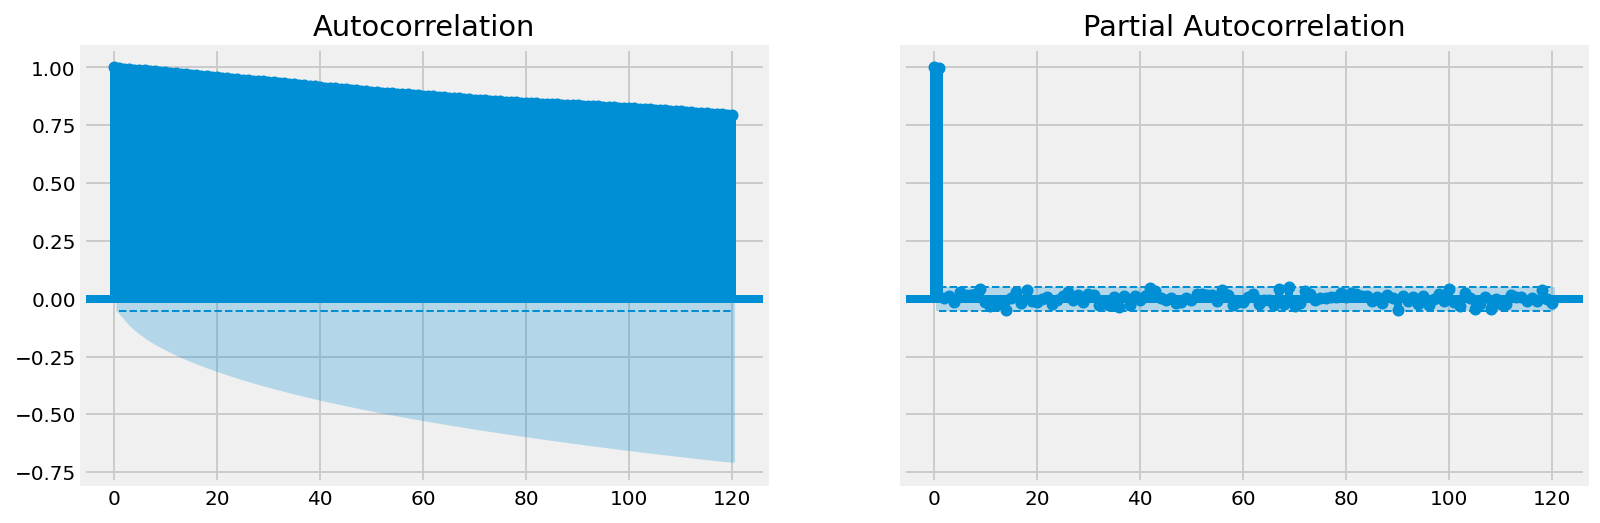

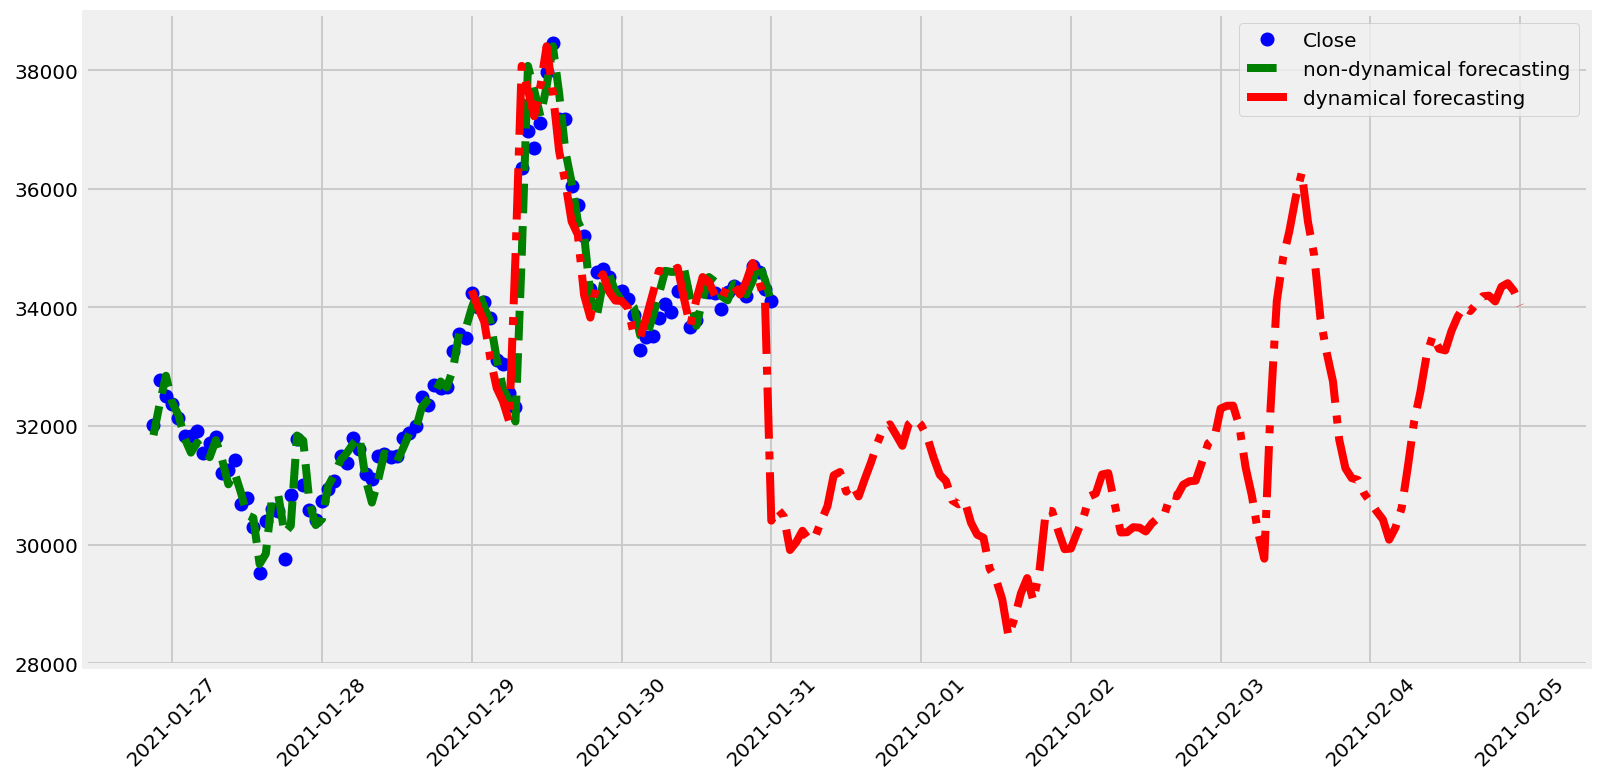

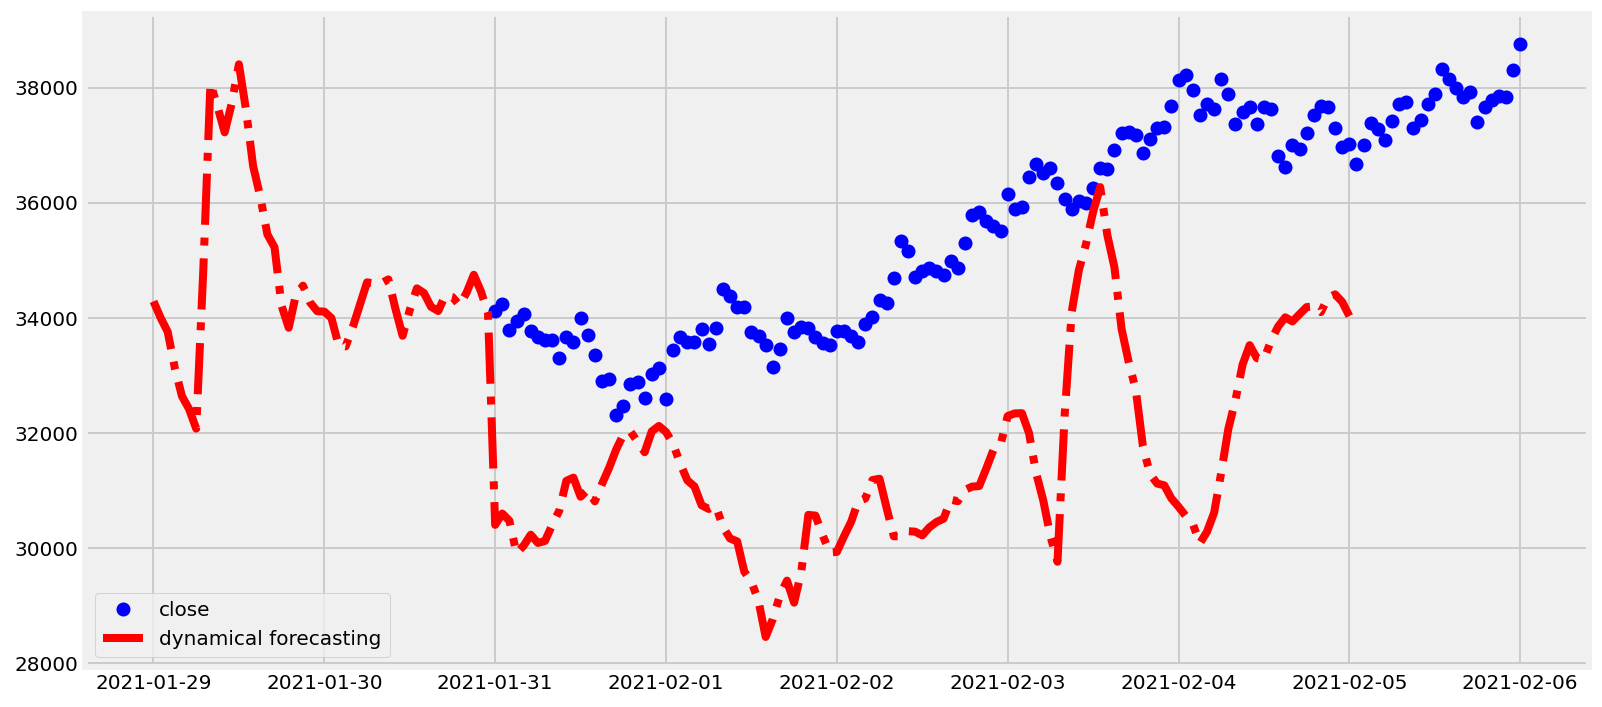

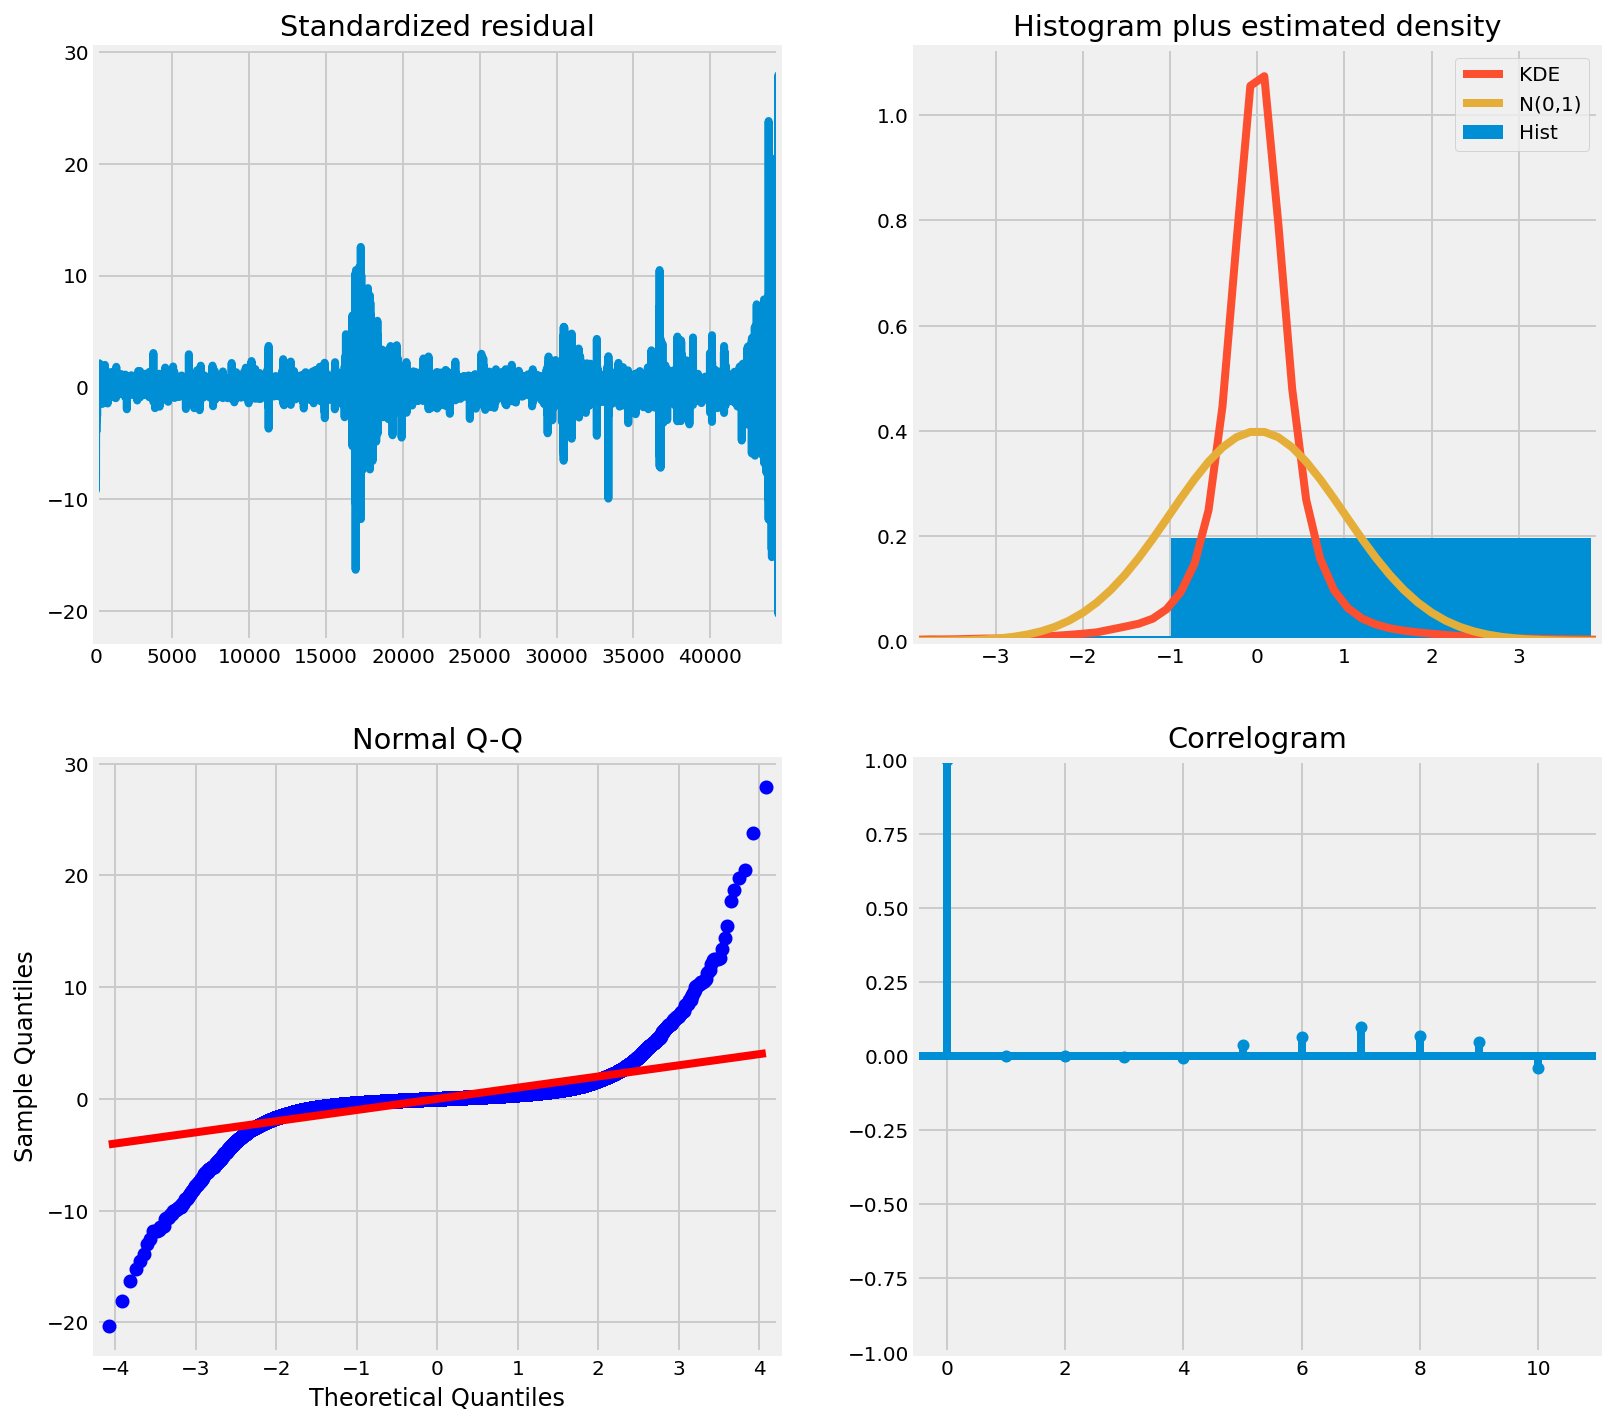

RMSE:  60.293459871640856


In [126]:
# Test BTC with model 4a:
# Try out different tis per currency

btc_arima = model_4a(btc_ta, "BTC-USD", trend_tis)
btc_arima


'close' Stationarity:  1
volatility_atr Stationarity:  1
volatility_bbm Stationarity:  2
volatility_bbh Stationarity:  2
volatility_bbl Stationarity:  1
volatility_bbw Stationarity:  1
volatility_bbp Stationarity:  1
volatility_bbhi Stationarity:  0
volatility_bbli Stationarity:  0
volatility_kcc Stationarity:  2
volatility_kch Stationarity:  2
volatility_kcl Stationarity:  2
volatility_kcw Stationarity:  1
volatility_kcp Stationarity:  1
volatility_kchi Stationarity:  1
volatility_kcli Stationarity:  1
volatility_dcl Stationarity:  1
volatility_dch Stationarity:  2
volatility_dcm Stationarity:  2
volatility_dcw Stationarity:  1
volatility_dcp Stationarity:  1
volatility_ui Stationarity:  1


Total period: 

1 Hour Lag AutoCorr 0.9996072983478607
6 Hour Lag AutoCorr 0.9977127427299818
12 Hour Lag AutoCorr 0.9955333198191737
24 Hour Lag AutoCorr 0.9909306218446579


Recent period (60 Days): 

12 Hour Lag AutoCorr 0.9758461106674979
24 Hour Lag AutoCorr 0.9499270280606557
48 Hour Lag Aut

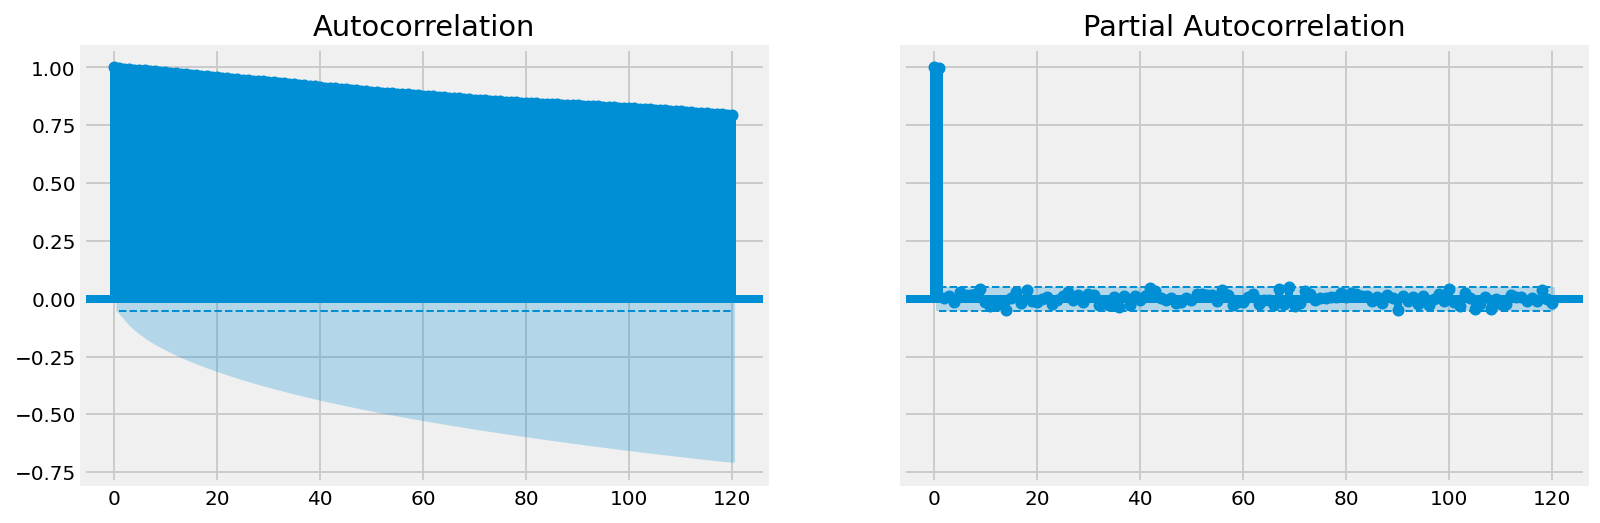

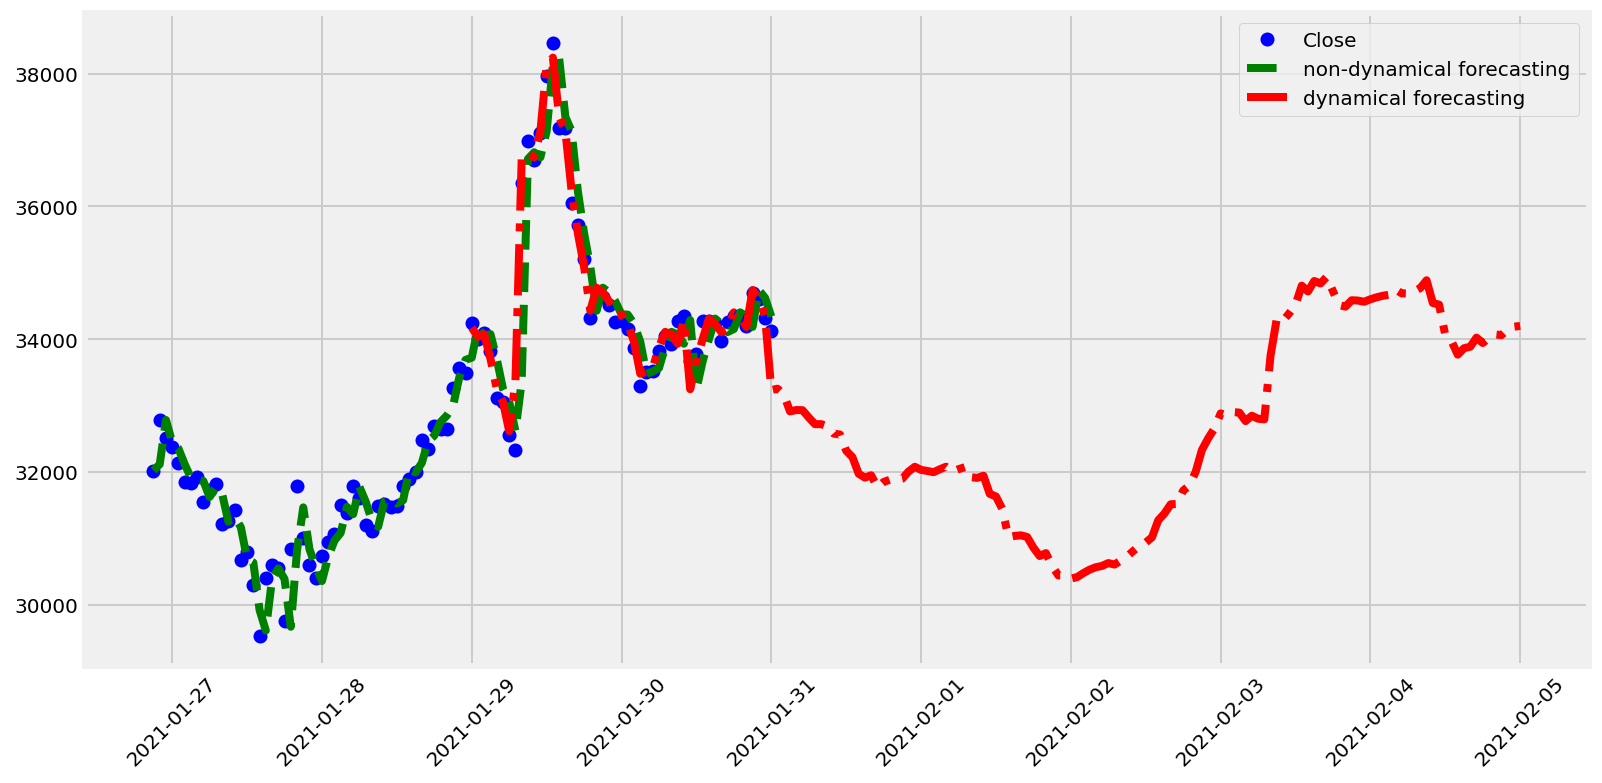

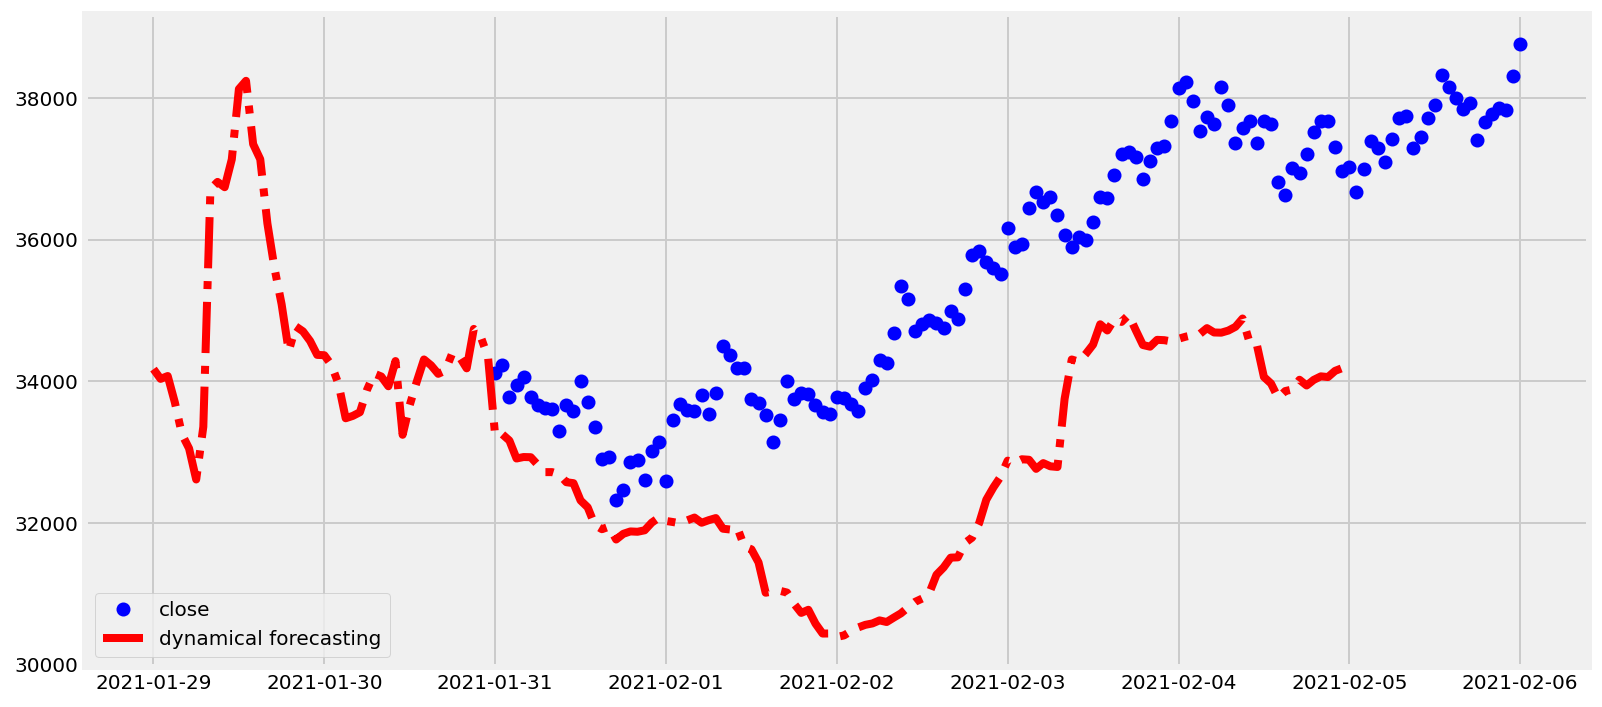

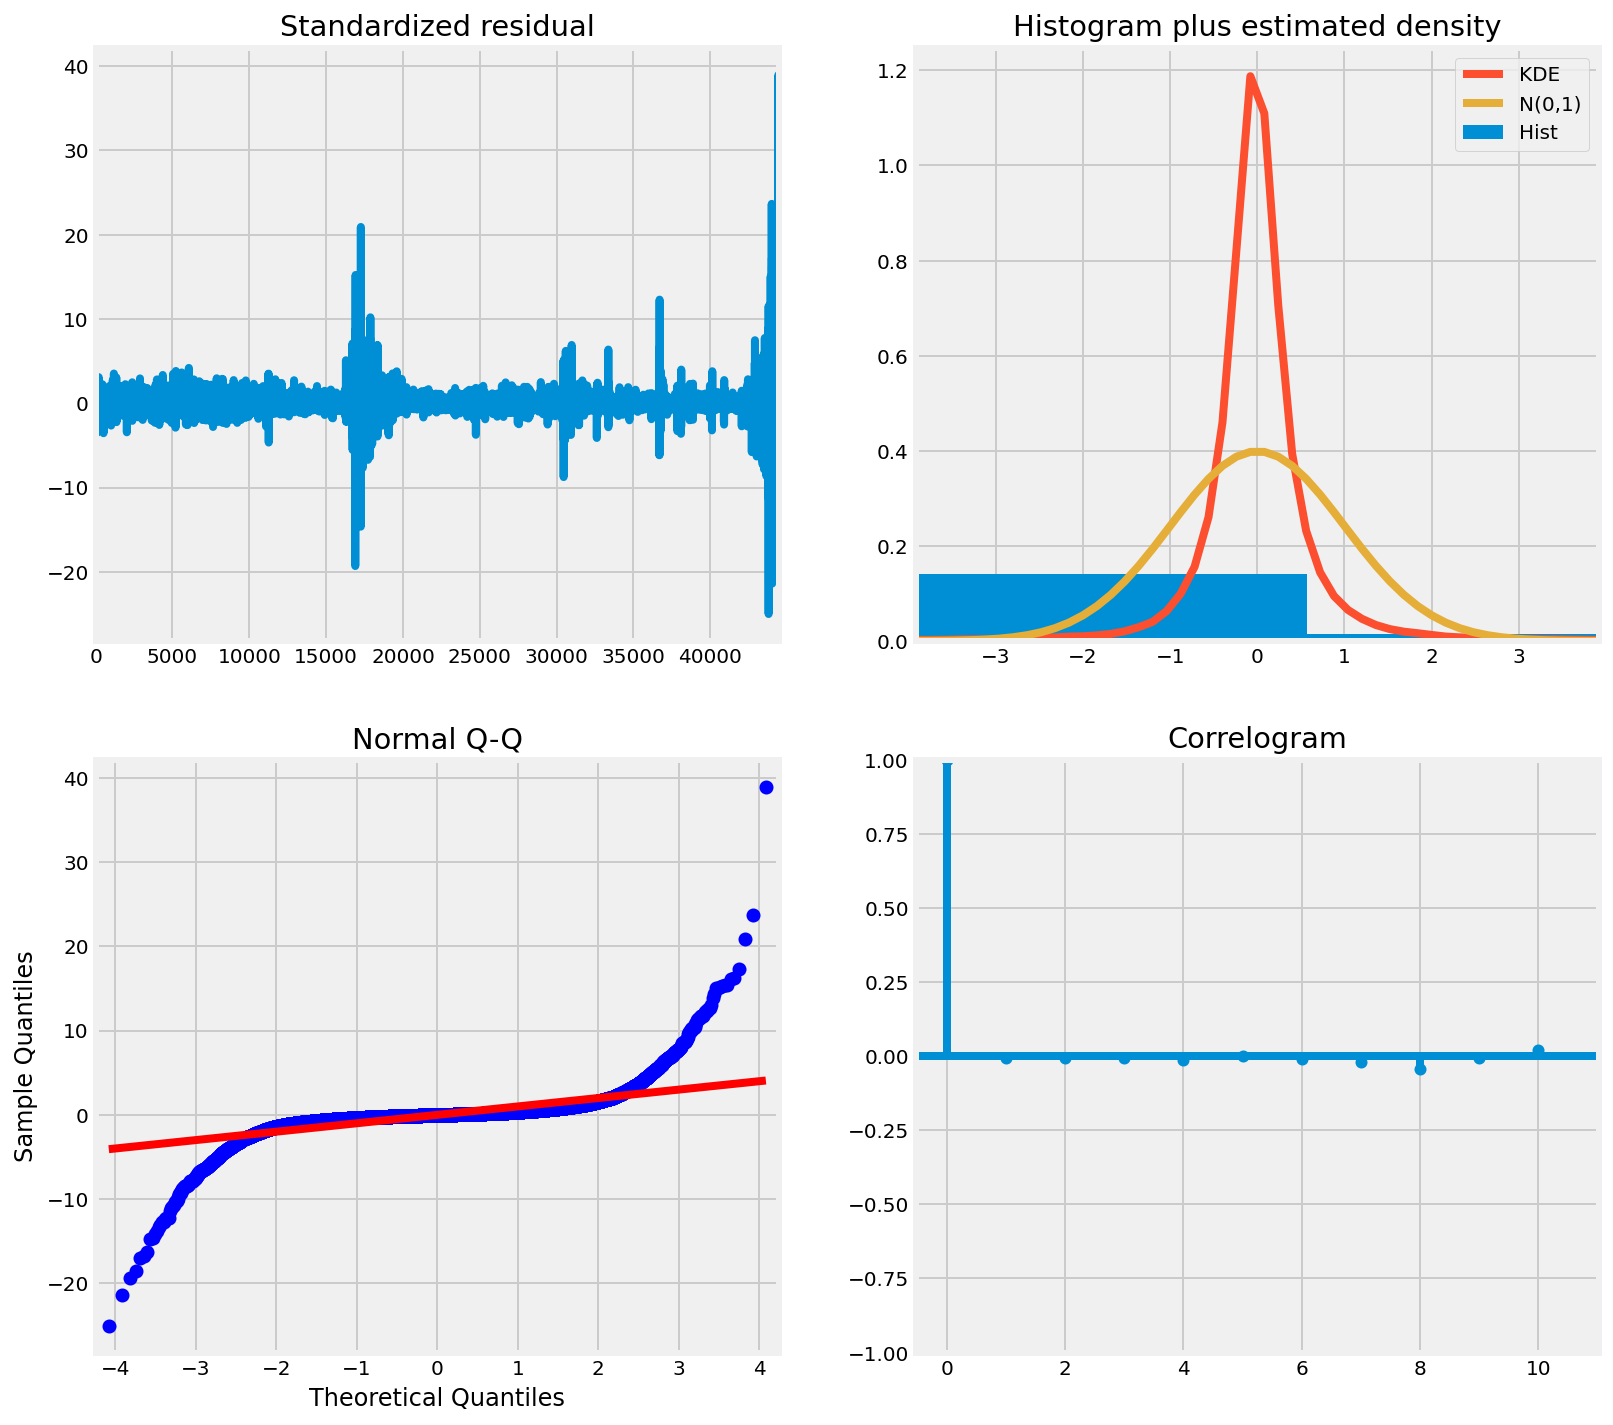

RMSE:  76.52524054293453


In [127]:
# Do volatility

btc_arima_volatility = model_4a(btc_ta, "BTC-USD", volatility_tis)
btc_arima_volatility


# ETH MODEL AND PLOTS

'close' Stationarity:  1
trend_macd Stationarity:  1
trend_macd_signal Stationarity:  1
trend_macd_diff Stationarity:  0
trend_sma_fast Stationarity:  1
trend_sma_slow Stationarity:  2
trend_ema_fast Stationarity:  1
trend_ema_slow Stationarity:  2
trend_adx Stationarity:  0
trend_adx_pos Stationarity:  1
trend_adx_neg Stationarity:  1
trend_vortex_ind_pos Stationarity:  1
trend_vortex_ind_neg Stationarity:  1
trend_vortex_ind_diff Stationarity:  1
trend_trix Stationarity:  0
trend_mass_index Stationarity:  0
trend_cci Stationarity:  0
trend_dpo Stationarity:  0
trend_kst Stationarity:  0
trend_kst_sig Stationarity:  0
trend_kst_diff Stationarity:  0
trend_ichimoku_conv Stationarity:  1
trend_ichimoku_base Stationarity:  1
trend_ichimoku_a Stationarity:  1
trend_ichimoku_b Stationarity:  2
trend_visual_ichimoku_a Stationarity:  2
trend_visual_ichimoku_b Stationarity:  2
trend_aroon_up Stationarity:  1
trend_aroon_down Stationarity:  1
trend_aroon_ind Stationarity:  1
trend_psar_up Stat

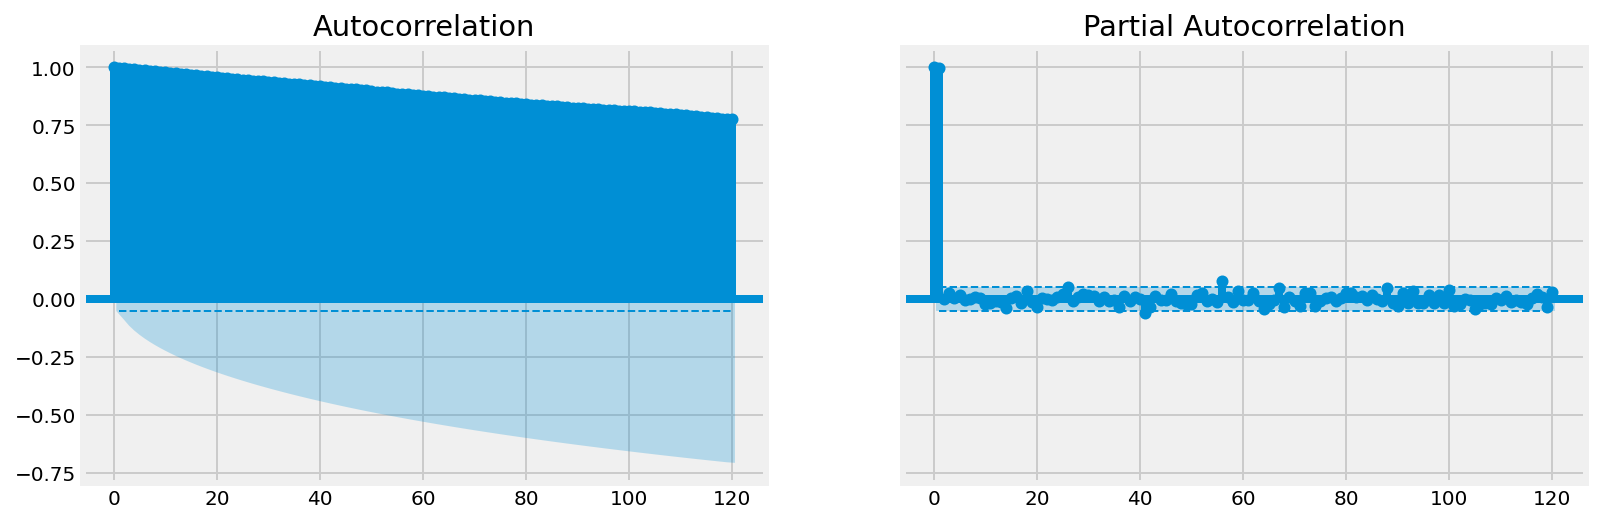

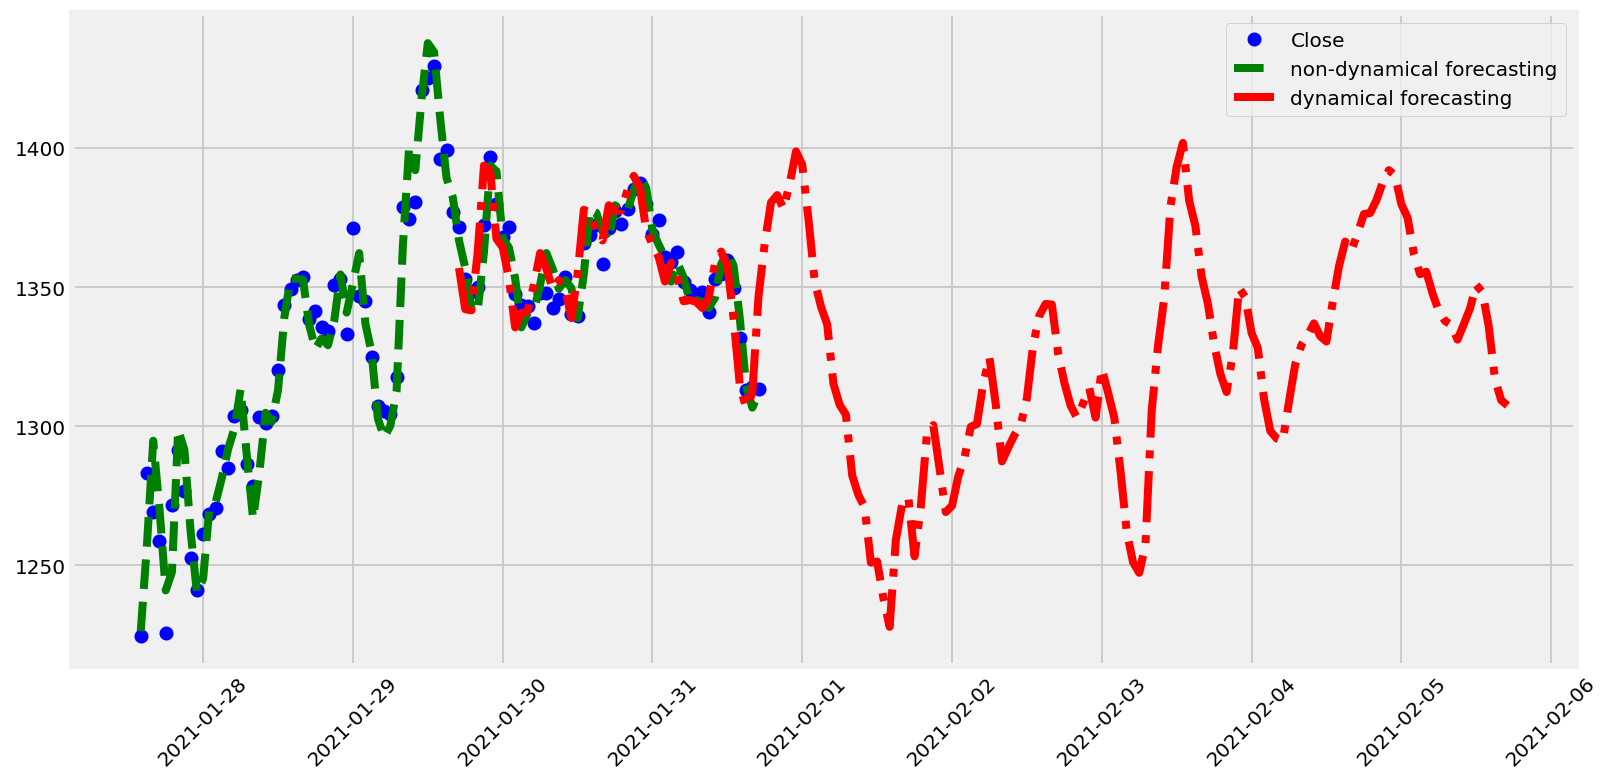

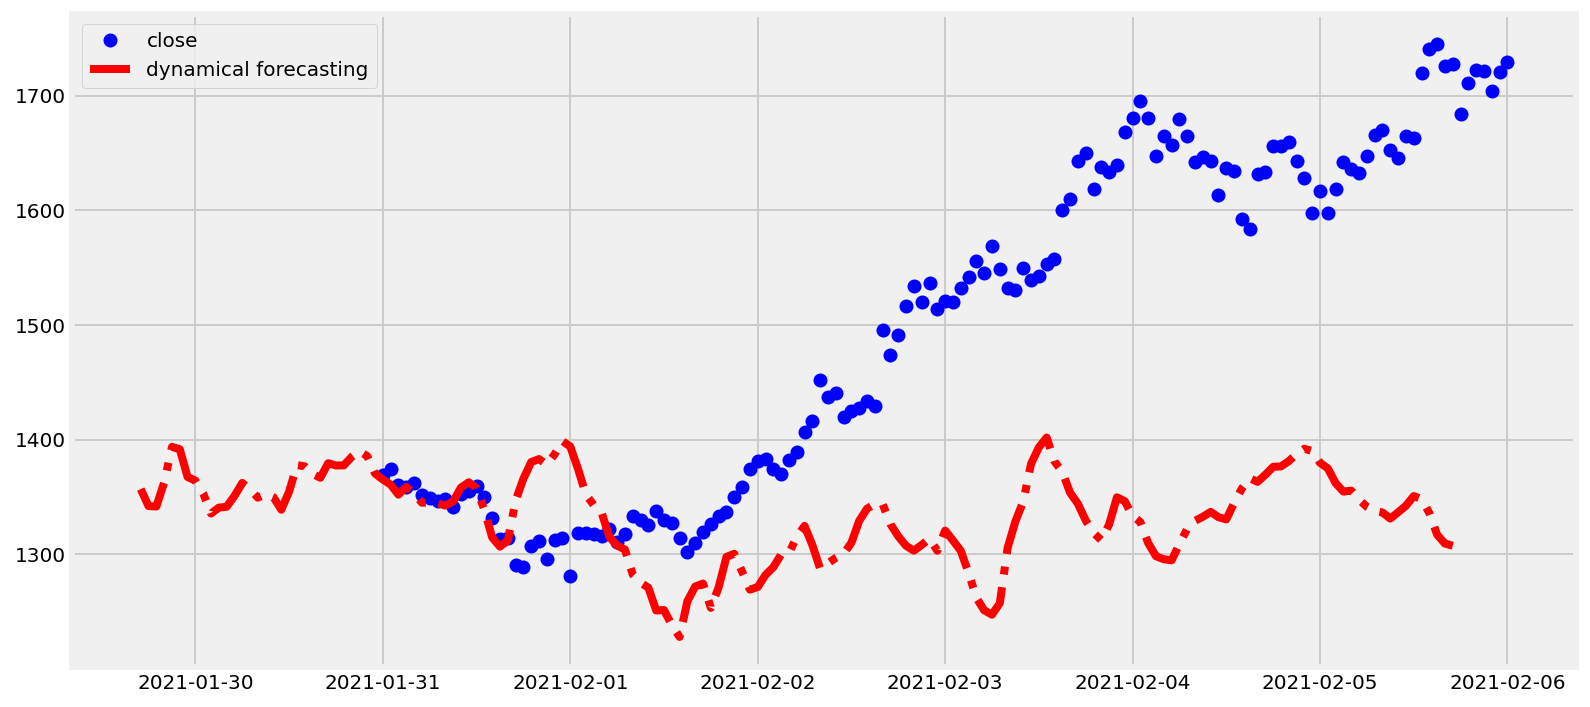

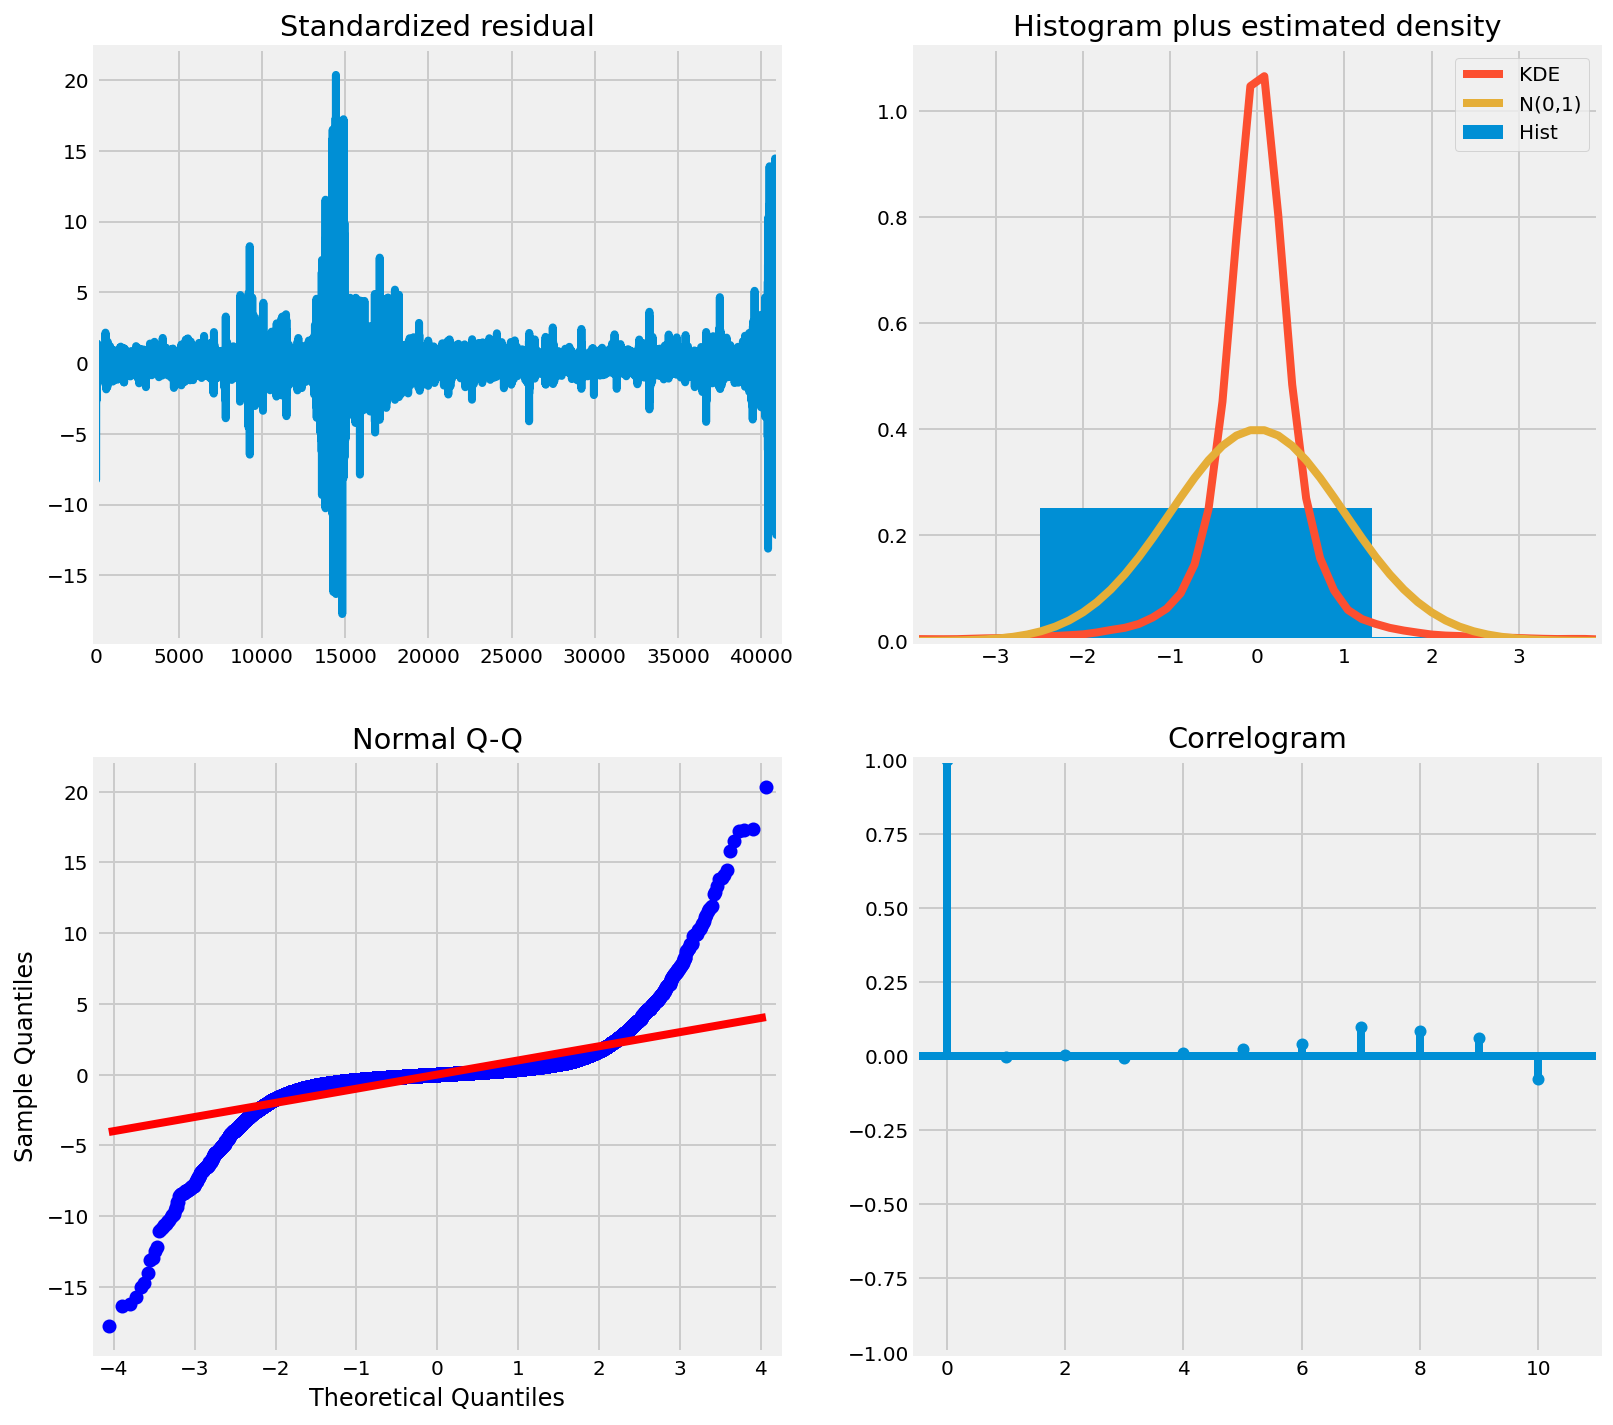

RMSE:  3.262480997091161


In [128]:
eth_arima_trend = model_4a(eth_ta, "ETH-USD", trend_tis)
eth_arima_trend


'close' Stationarity:  1
momentum_rsi Stationarity:  1
momentum_stoch_rsi Stationarity:  0
momentum_stoch_rsi_k Stationarity:  0
momentum_stoch_rsi_d Stationarity:  0
momentum_tsi Stationarity:  1
momentum_uo Stationarity:  1
momentum_stoch Stationarity:  1
momentum_stoch_signal Stationarity:  1
momentum_wr Stationarity:  1
momentum_ao Stationarity:  1
momentum_kama Stationarity:  1
momentum_roc Stationarity:  0
momentum_ppo Stationarity:  0
momentum_ppo_signal Stationarity:  0
momentum_ppo_hist Stationarity:  0


Total period: 

1 Hour Lag AutoCorr 0.9995626646070446
6 Hour Lag AutoCorr 0.9975606948925989
12 Hour Lag AutoCorr 0.9951873510480378
24 Hour Lag AutoCorr 0.9898811790505392


Recent period (60 Days): 

12 Hour Lag AutoCorr 0.9760507536752219
24 Hour Lag AutoCorr 0.9495044735882652
48 Hour Lag AutoCorr 0.9029817522493803
120 Hour Lag AutoCorr 0.7755630766539903


                               SARIMAX Results                                
Dep. Variable:                     

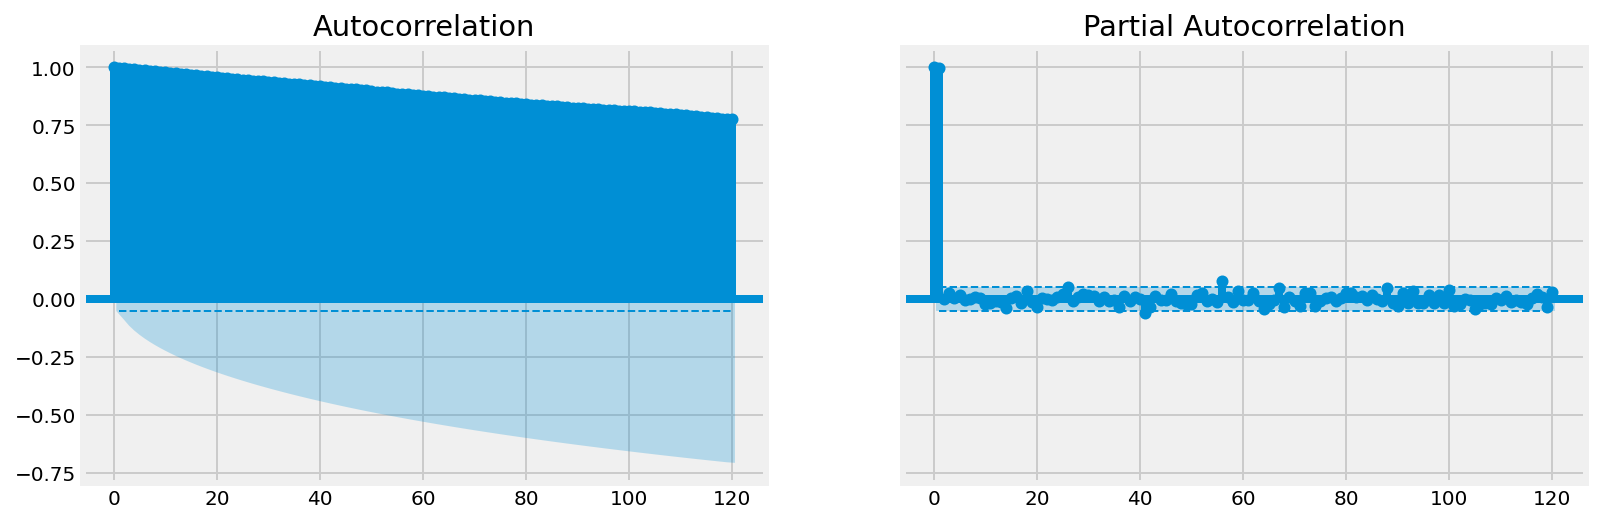

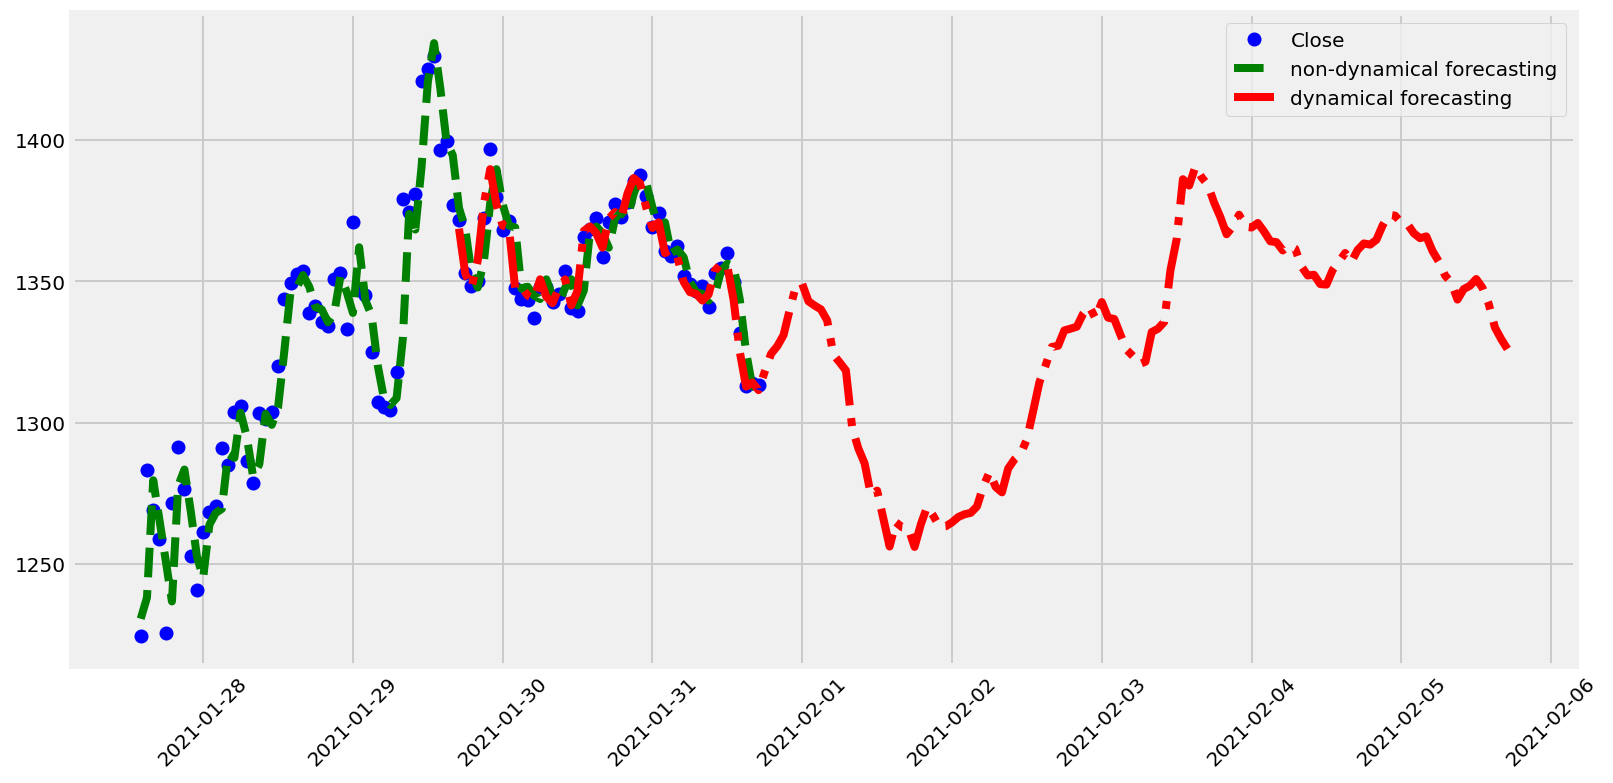

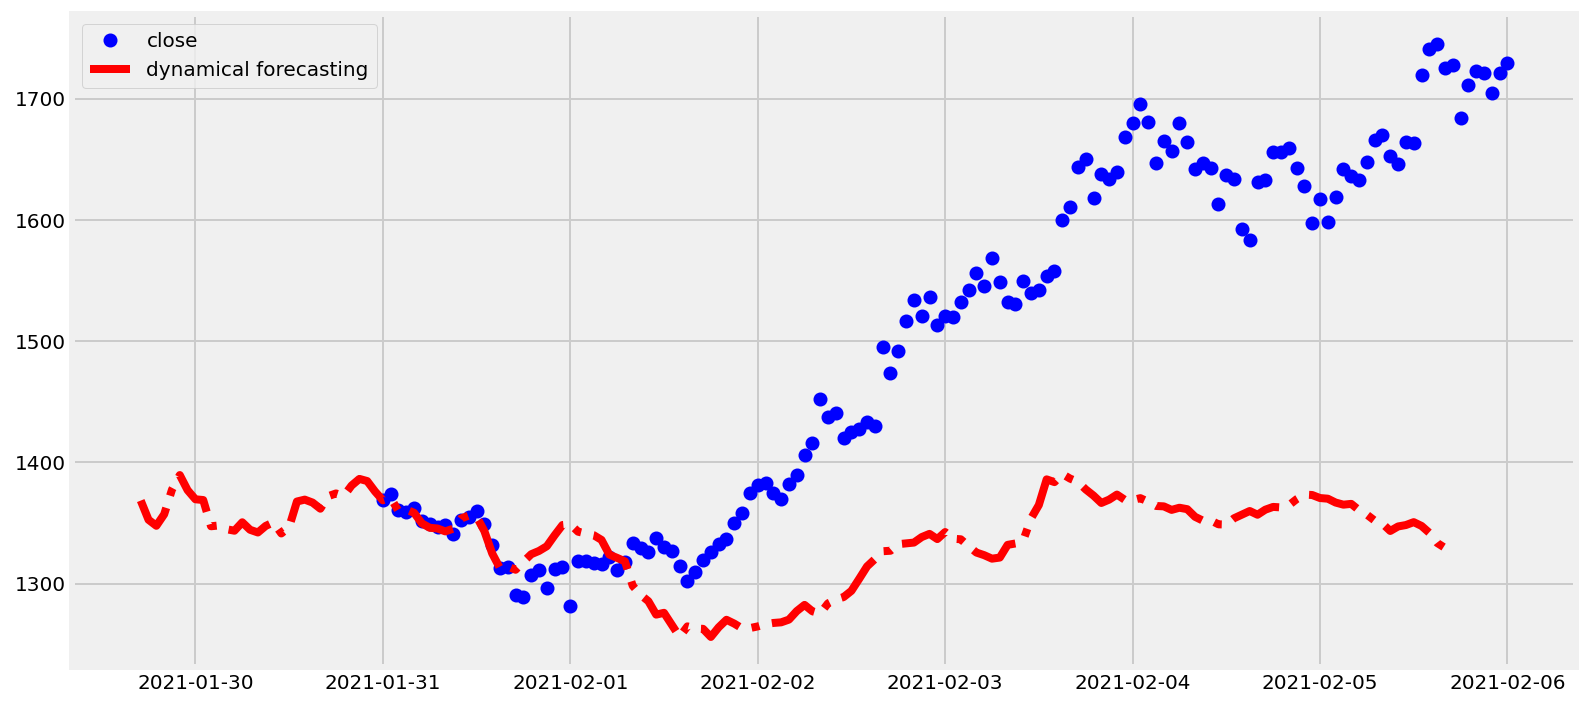

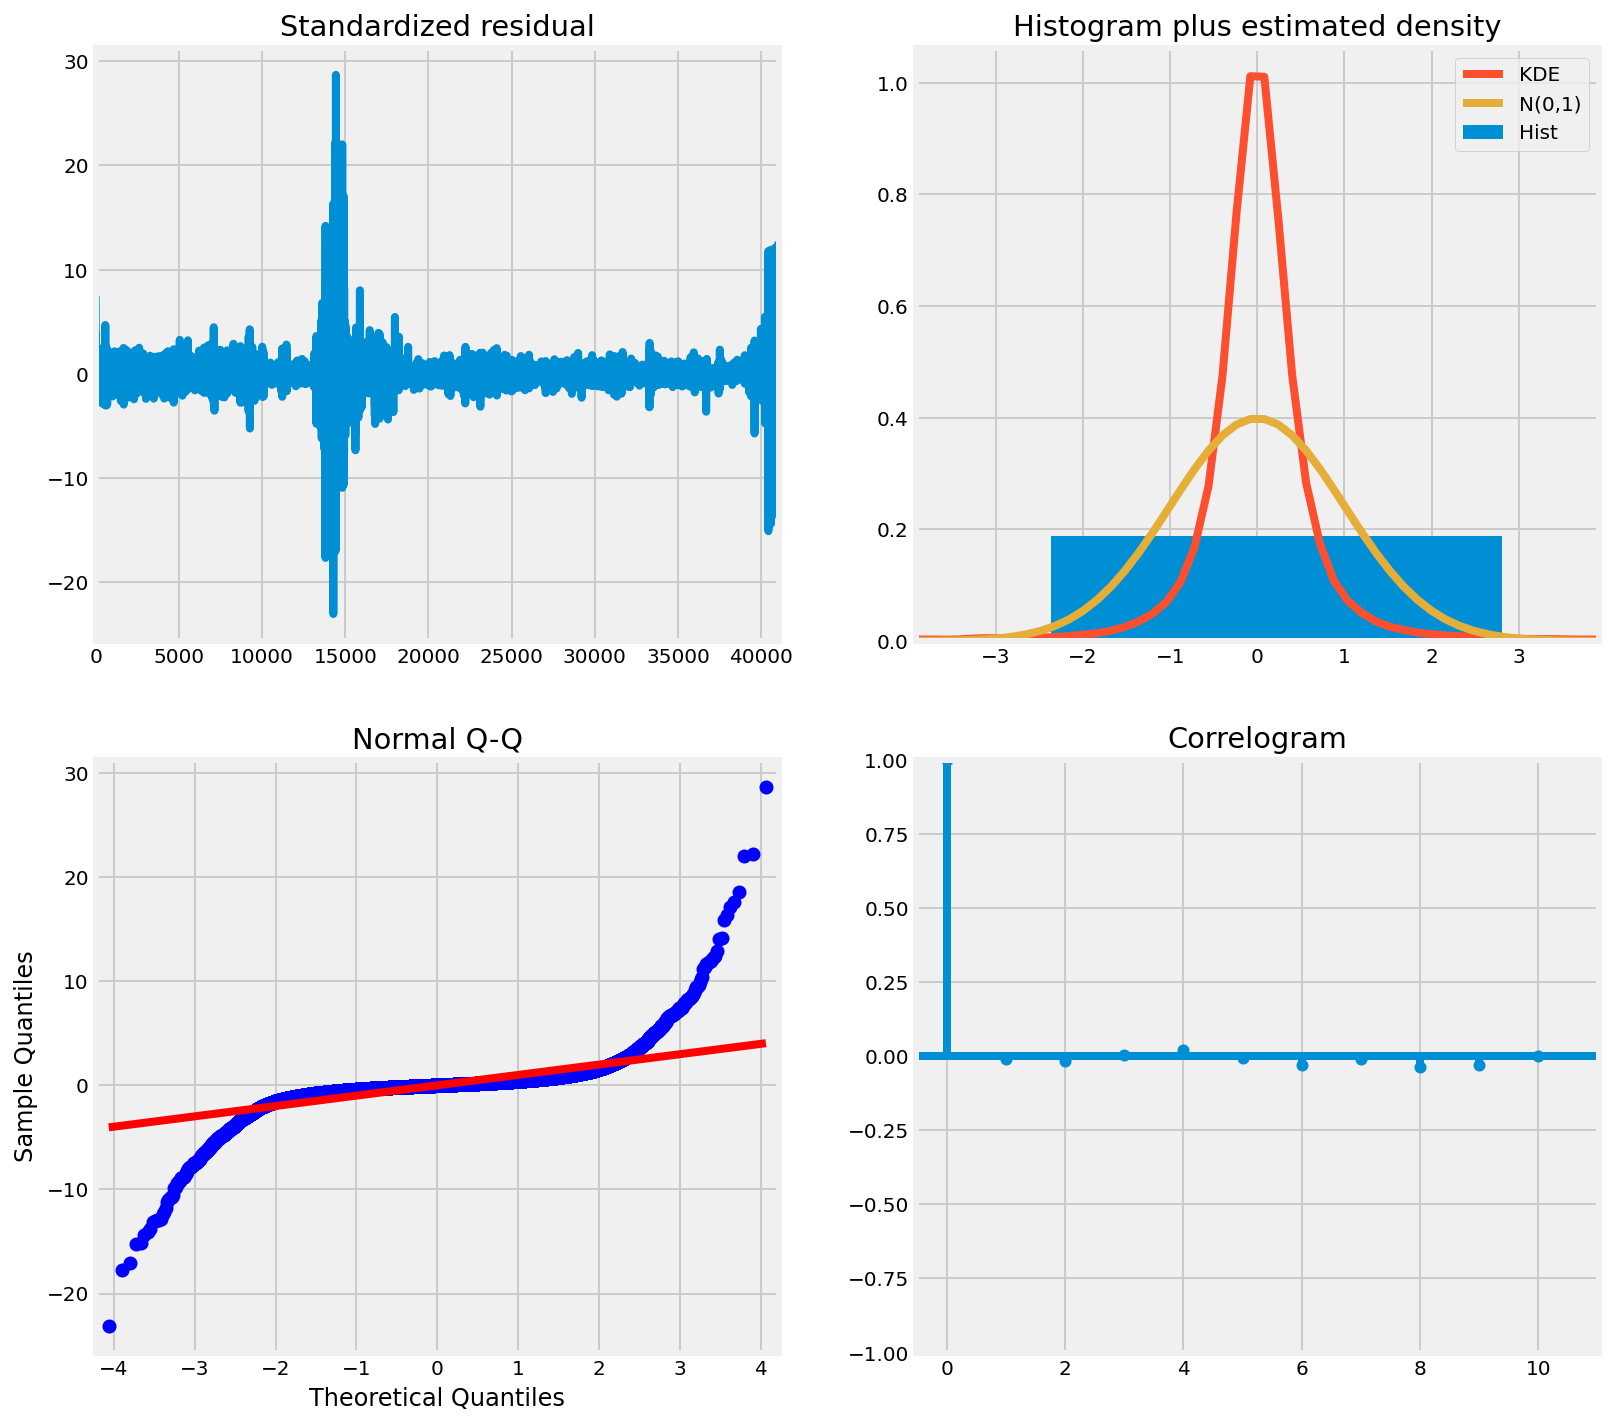

RMSE:  3.944778423140555


In [129]:
eth_arima_momentum = model_4a(eth_ta, "ETH-USD", momentum_tis)
eth_arima_momentum


# LTC MODEL & PLOTS

'close' Stationarity:  1
trend_macd Stationarity:  0
trend_macd_signal Stationarity:  0
trend_macd_diff Stationarity:  0
trend_sma_fast Stationarity:  1
trend_sma_slow Stationarity:  1
trend_ema_fast Stationarity:  1
trend_ema_slow Stationarity:  1
trend_adx Stationarity:  0
trend_adx_pos Stationarity:  1
trend_adx_neg Stationarity:  1
trend_vortex_ind_pos Stationarity:  1
trend_vortex_ind_neg Stationarity:  1
trend_vortex_ind_diff Stationarity:  0
trend_trix Stationarity:  0
trend_mass_index Stationarity:  0
trend_cci Stationarity:  0
trend_dpo Stationarity:  0
trend_kst Stationarity:  0
trend_kst_sig Stationarity:  0
trend_kst_diff Stationarity:  0
trend_ichimoku_conv Stationarity:  1
trend_ichimoku_base Stationarity:  1
trend_ichimoku_a Stationarity:  1
trend_ichimoku_b Stationarity:  1
trend_visual_ichimoku_a Stationarity:  1
trend_visual_ichimoku_b Stationarity:  1
trend_aroon_up Stationarity:  1
trend_aroon_down Stationarity:  1
trend_aroon_ind Stationarity:  1
trend_psar_up Stat

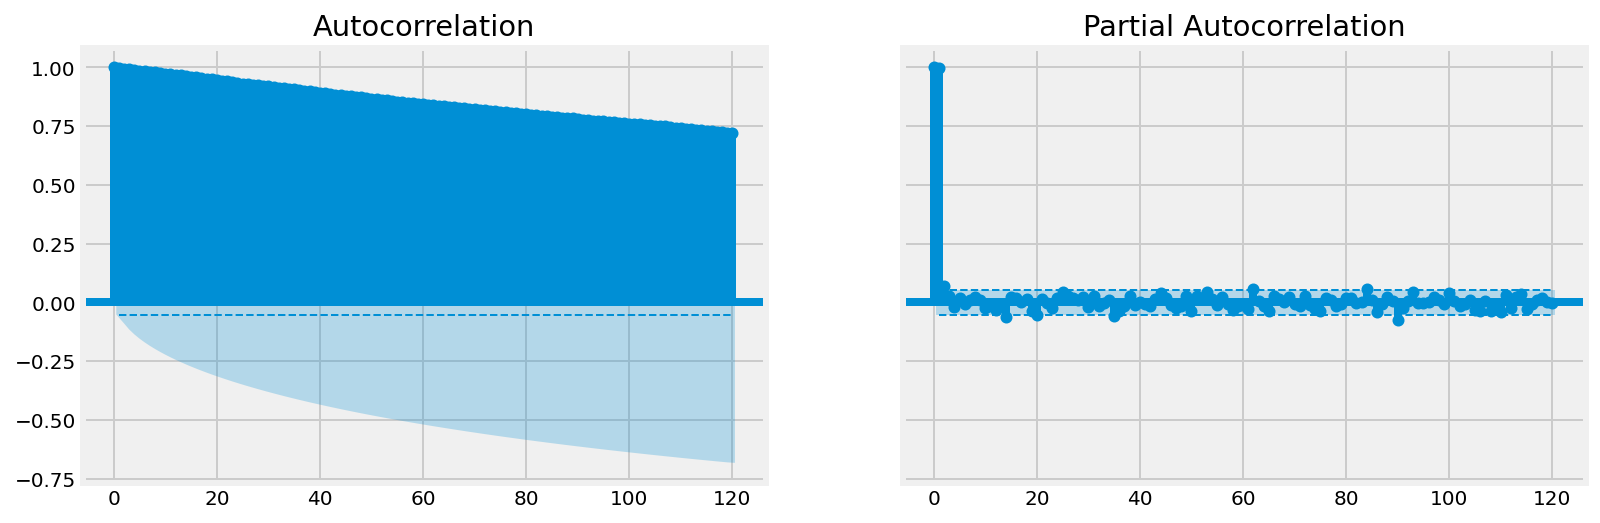

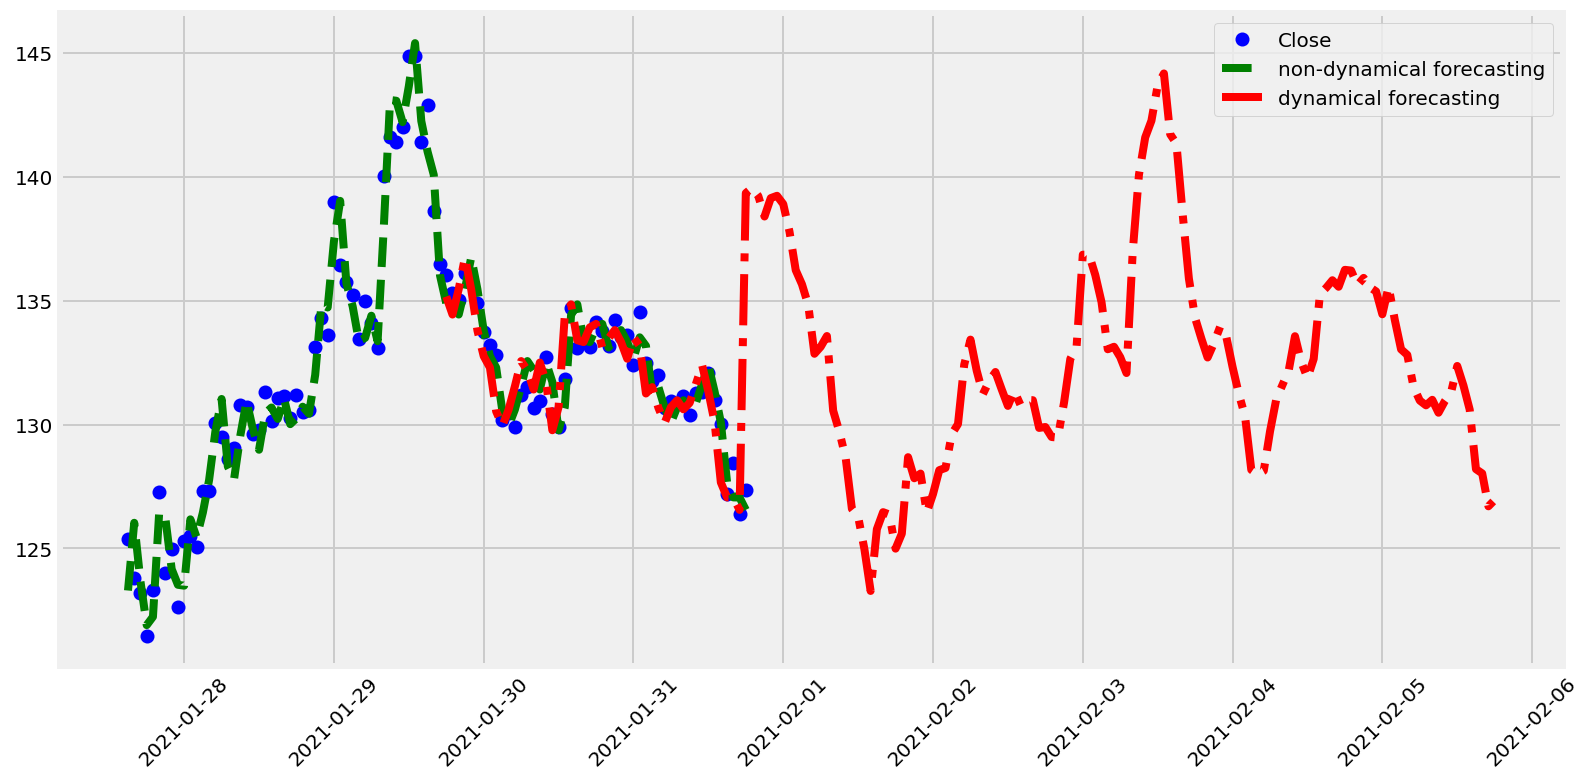

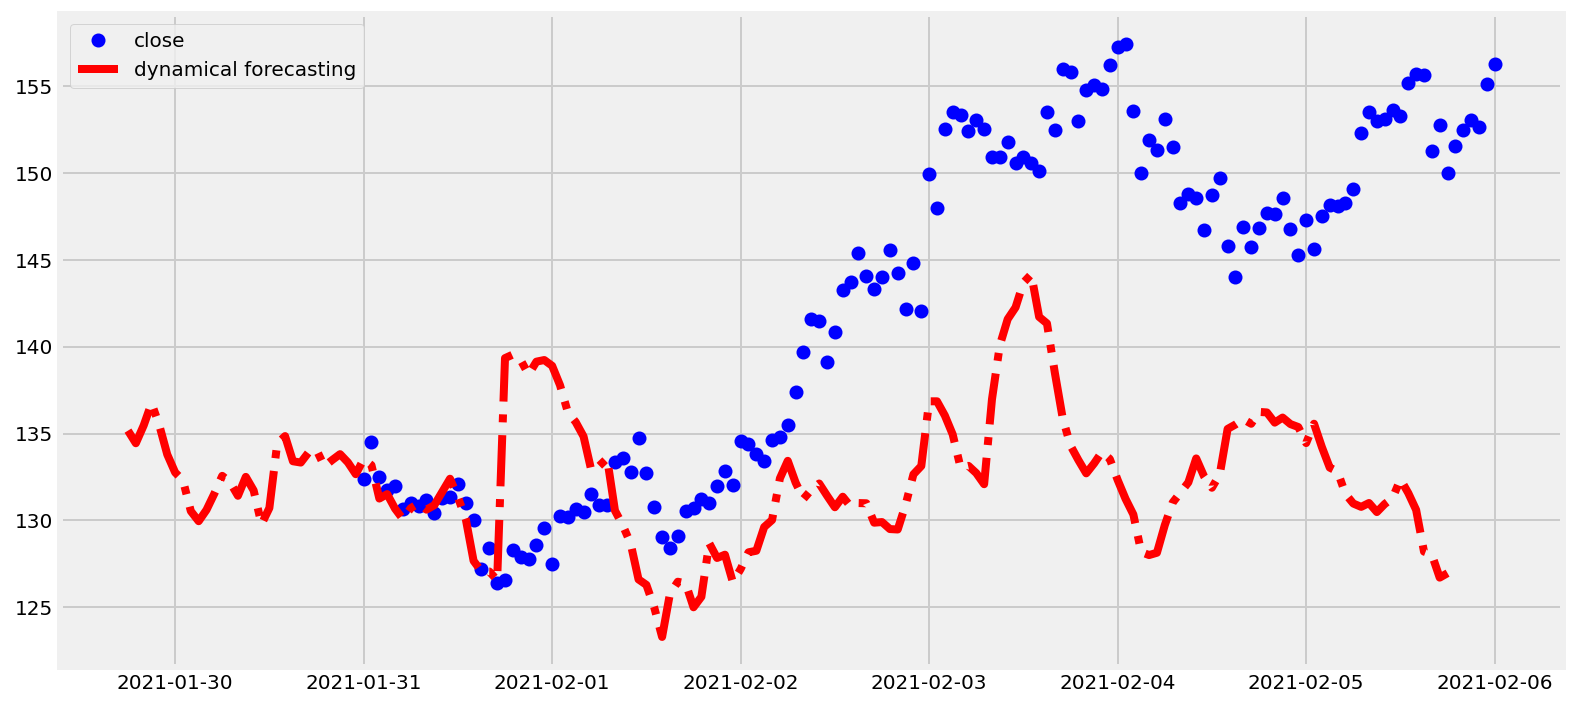

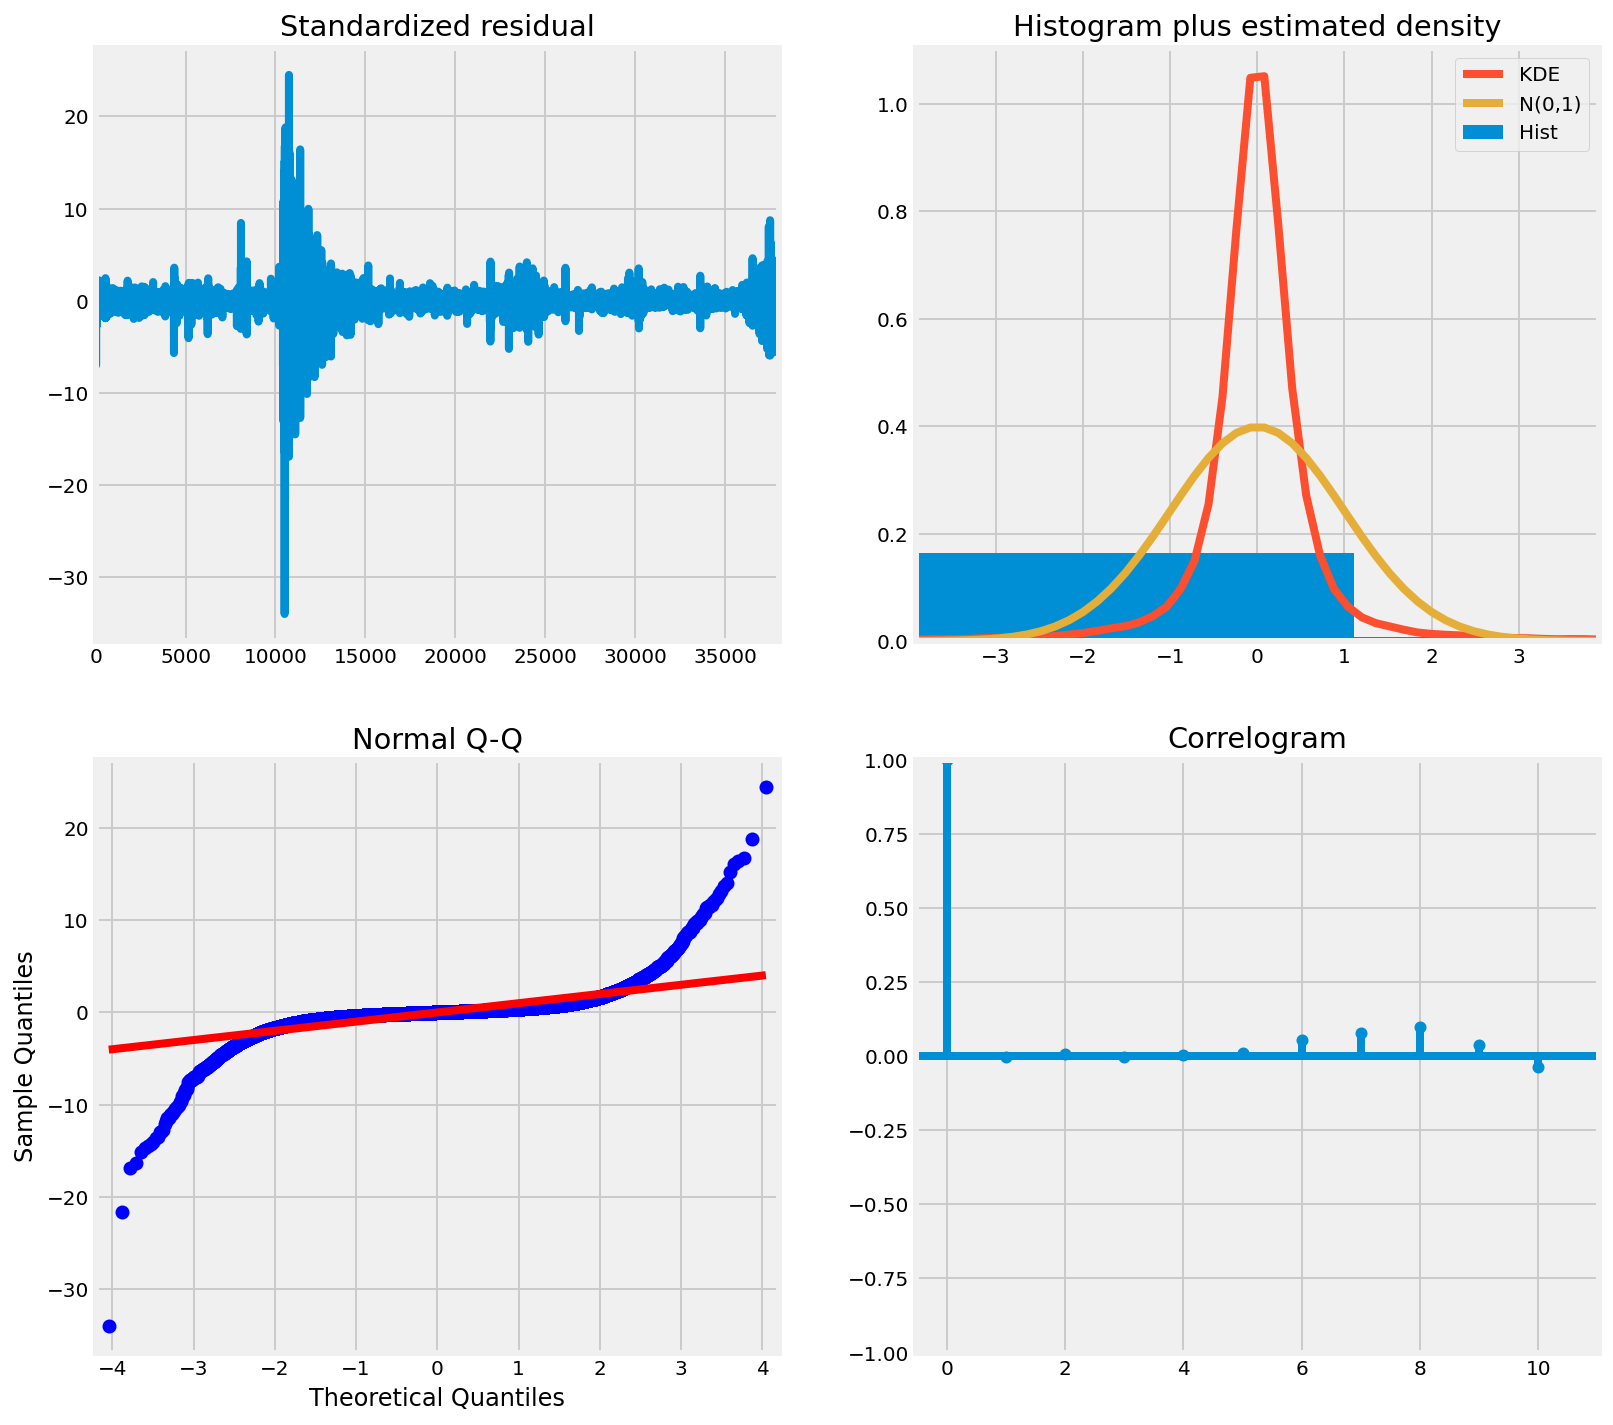

RMSE:  0.8691363754957917


In [130]:
ltc_arima_trend = model_4a(ltc_ta, "LTC-USD", trend_tis)
ltc_arima_trend


'close' Stationarity:  1
volatility_atr Stationarity:  1
volatility_bbm Stationarity:  1
volatility_bbh Stationarity:  1
volatility_bbl Stationarity:  1
volatility_bbw Stationarity:  1
volatility_bbp Stationarity:  0
volatility_bbhi Stationarity:  0
volatility_bbli Stationarity:  1
volatility_kcc Stationarity:  1
volatility_kch Stationarity:  1
volatility_kcl Stationarity:  1
volatility_kcw Stationarity:  1
volatility_kcp Stationarity:  0
volatility_kchi Stationarity:  1
volatility_kcli Stationarity:  1
volatility_dcl Stationarity:  1
volatility_dch Stationarity:  1
volatility_dcm Stationarity:  1
volatility_dcw Stationarity:  1
volatility_dcp Stationarity:  1
volatility_ui Stationarity:  1


Total period: 

1 Hour Lag AutoCorr 0.9995879244805232
6 Hour Lag AutoCorr 0.9977359945062857
12 Hour Lag AutoCorr 0.9954890955576485
24 Hour Lag AutoCorr 0.9899235294789455


Recent period (60 Days): 

12 Hour Lag AutoCorr 0.9691629320875639
24 Hour Lag AutoCorr 0.934358297017731
48 Hour Lag Auto

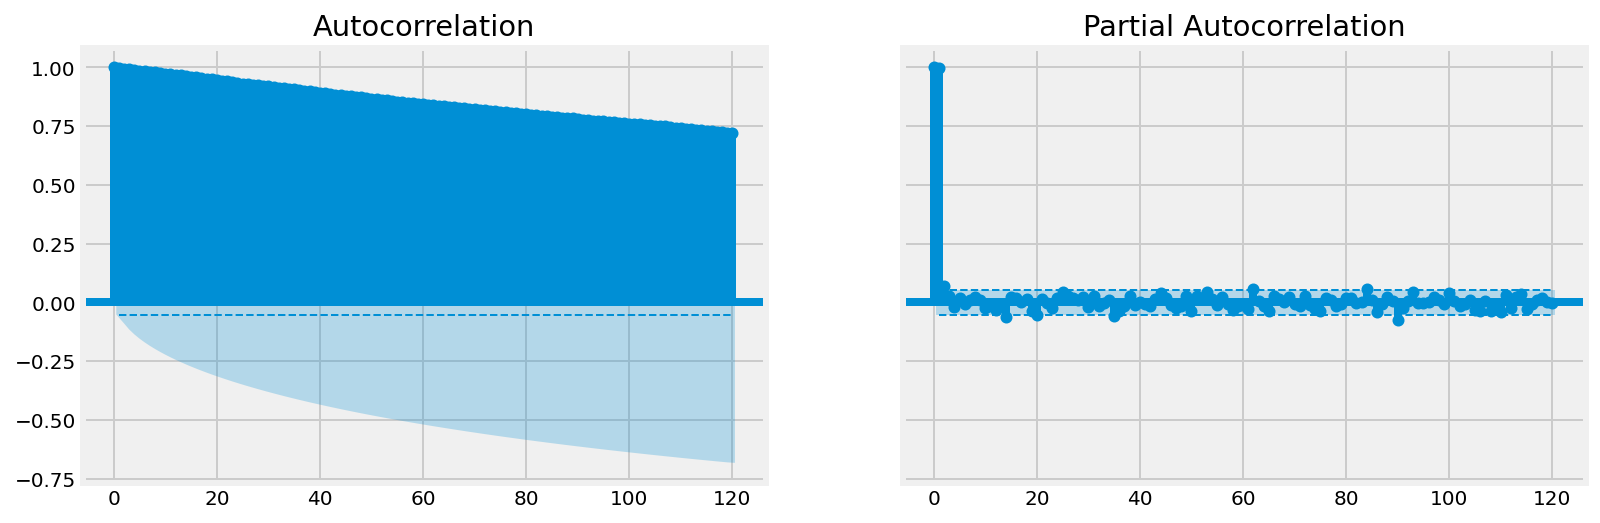

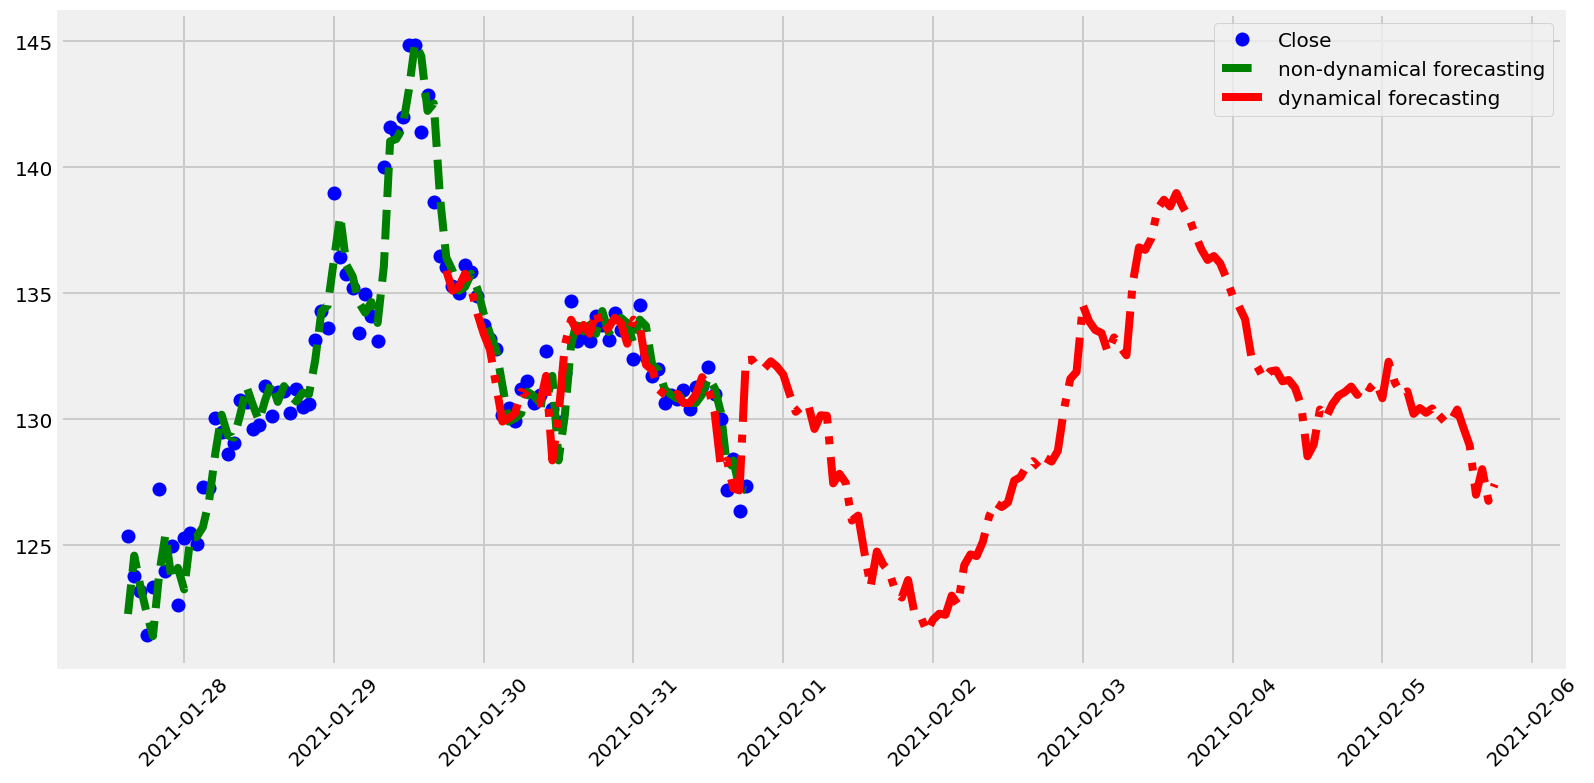

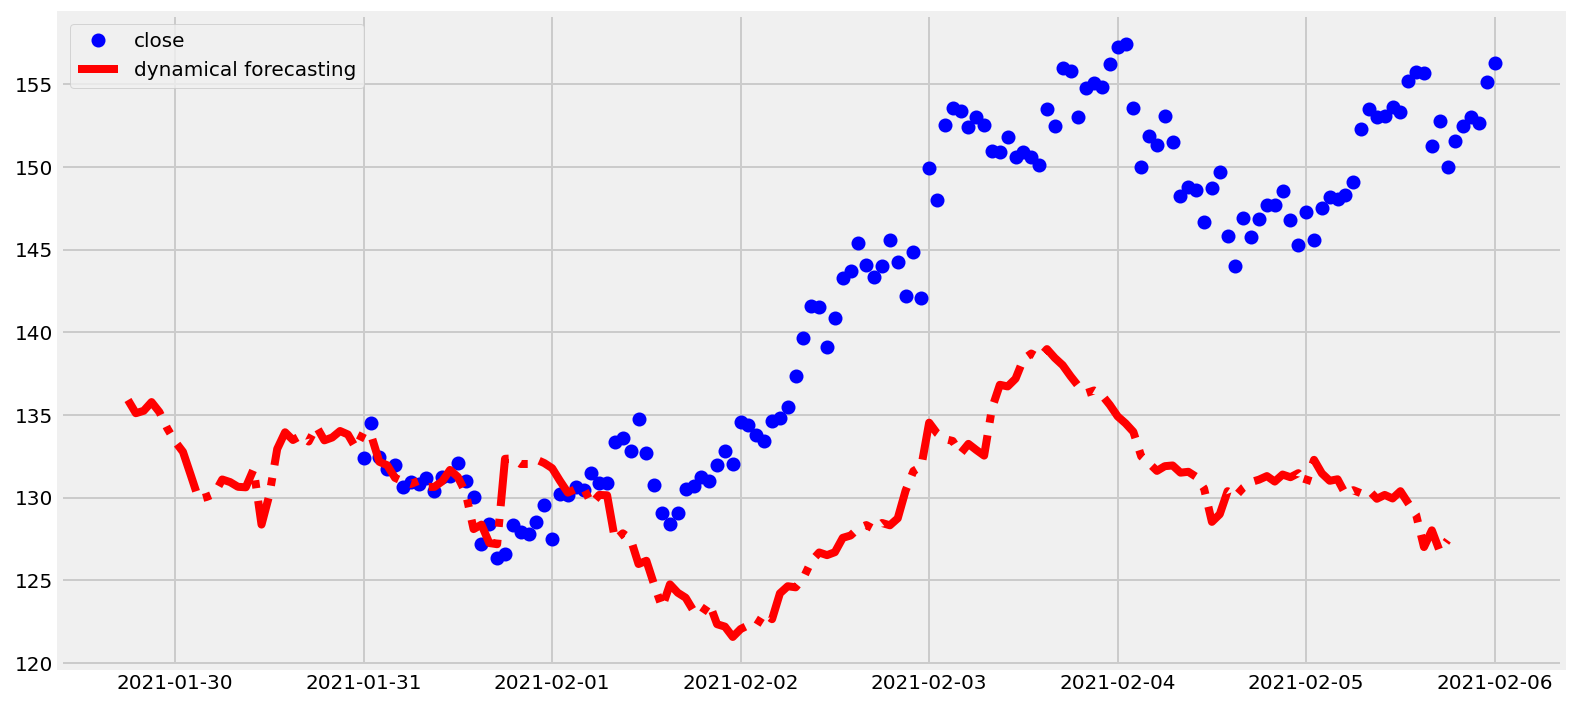

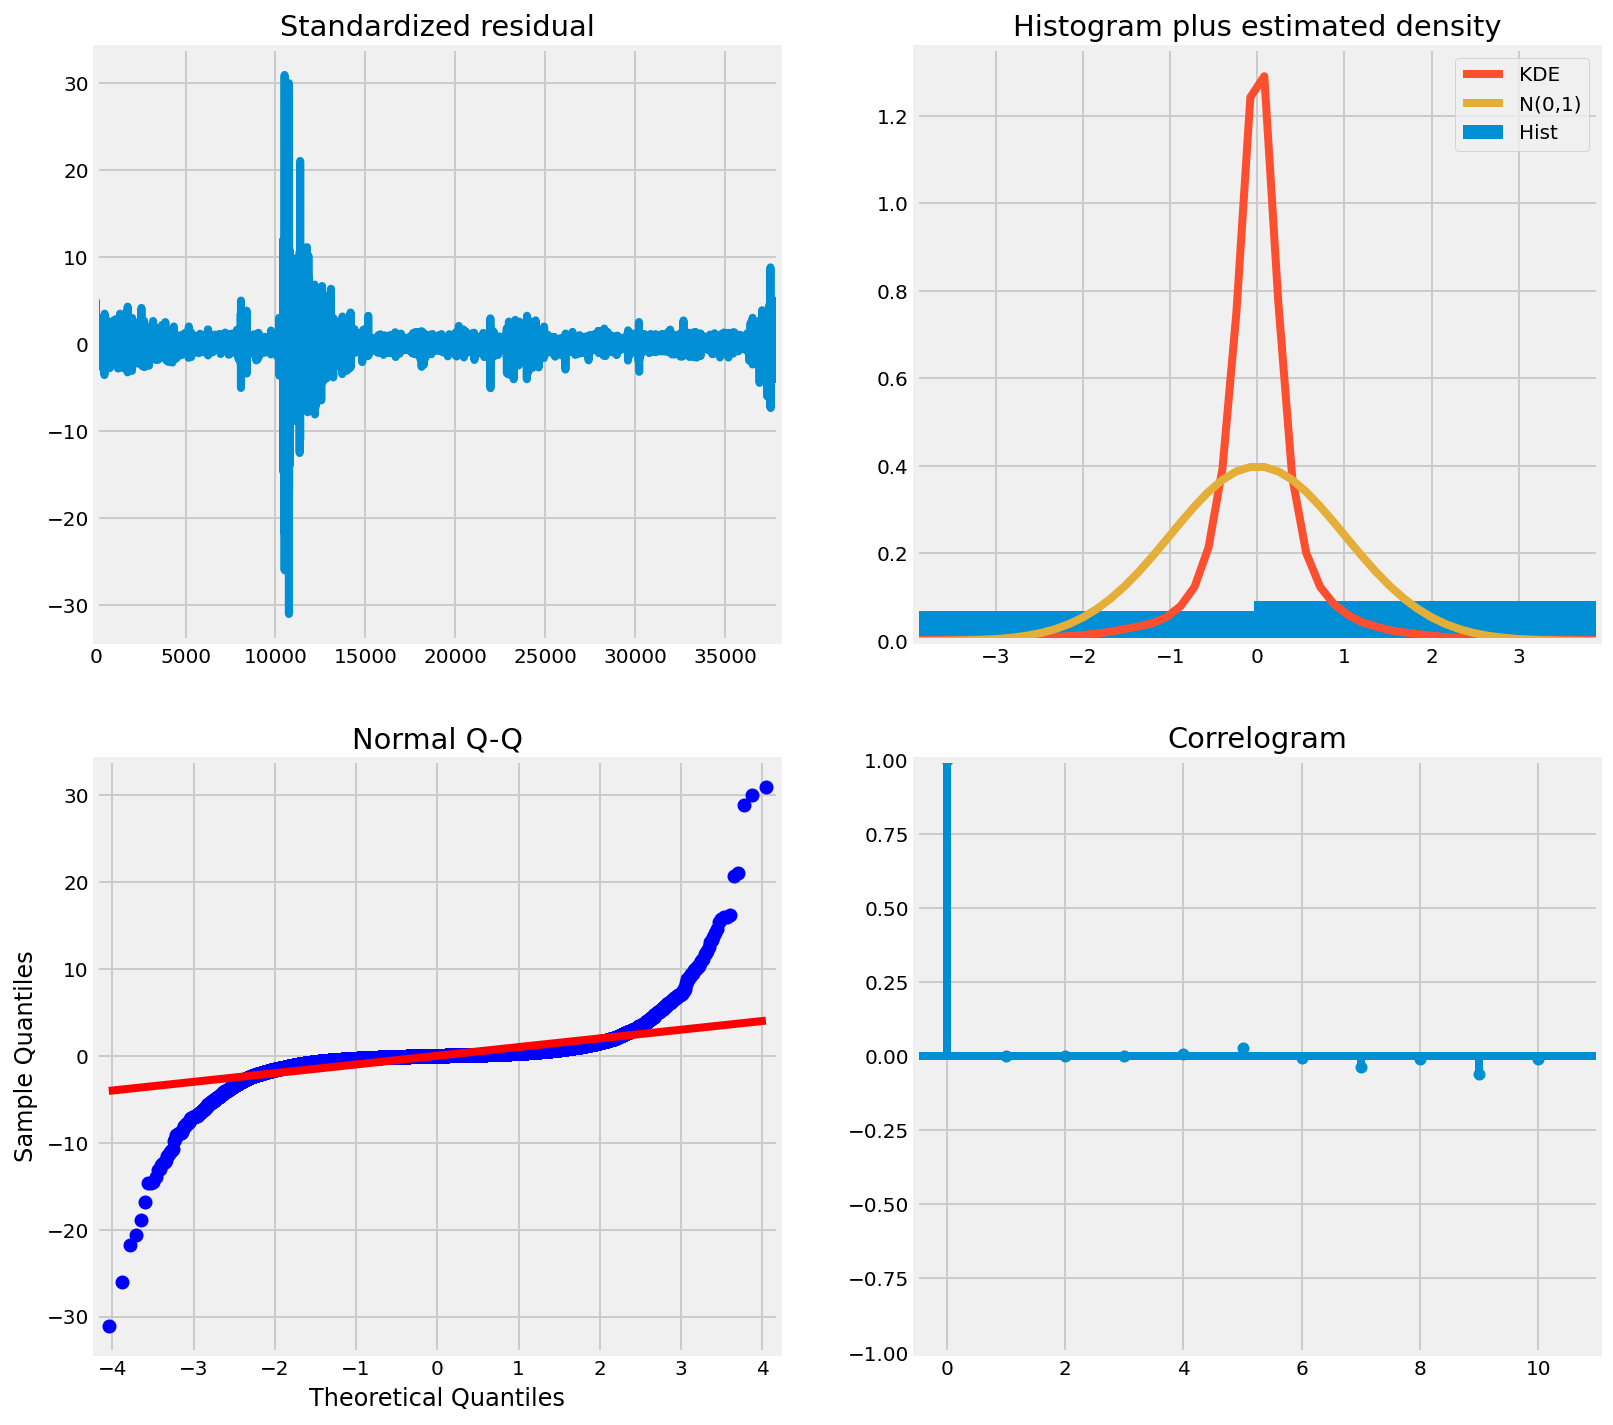

RMSE:  1.1749595886067439


In [131]:
ltc_arima_volatility = model_4a(ltc_ta, "LTC-USD", volatility_tis)
ltc_arima_volatility


# XLM MODEL & PLOTS

'close' Stationarity:  1
trend_macd Stationarity:  1
trend_macd_signal Stationarity:  1
trend_macd_diff Stationarity:  0
trend_sma_fast Stationarity:  1
trend_sma_slow Stationarity:  2
trend_ema_fast Stationarity:  2
trend_ema_slow Stationarity:  2
trend_adx Stationarity:  0
trend_adx_pos Stationarity:  0
trend_adx_neg Stationarity:  1
trend_vortex_ind_pos Stationarity:  1
trend_vortex_ind_neg Stationarity:  1
trend_vortex_ind_diff Stationarity:  1
trend_trix Stationarity:  1
trend_mass_index Stationarity:  0
trend_cci Stationarity:  1
trend_dpo Stationarity:  0
trend_kst Stationarity:  1
trend_kst_sig Stationarity:  1
trend_kst_diff Stationarity:  0
trend_ichimoku_conv Stationarity:  1
trend_ichimoku_base Stationarity:  2
trend_ichimoku_a Stationarity:  2
trend_ichimoku_b Stationarity:  2
trend_visual_ichimoku_a Stationarity:  1
trend_visual_ichimoku_b Stationarity:  2
trend_aroon_up Stationarity:  0
trend_aroon_down Stationarity:  0
trend_aroon_ind Stationarity:  1
trend_psar_up Stat

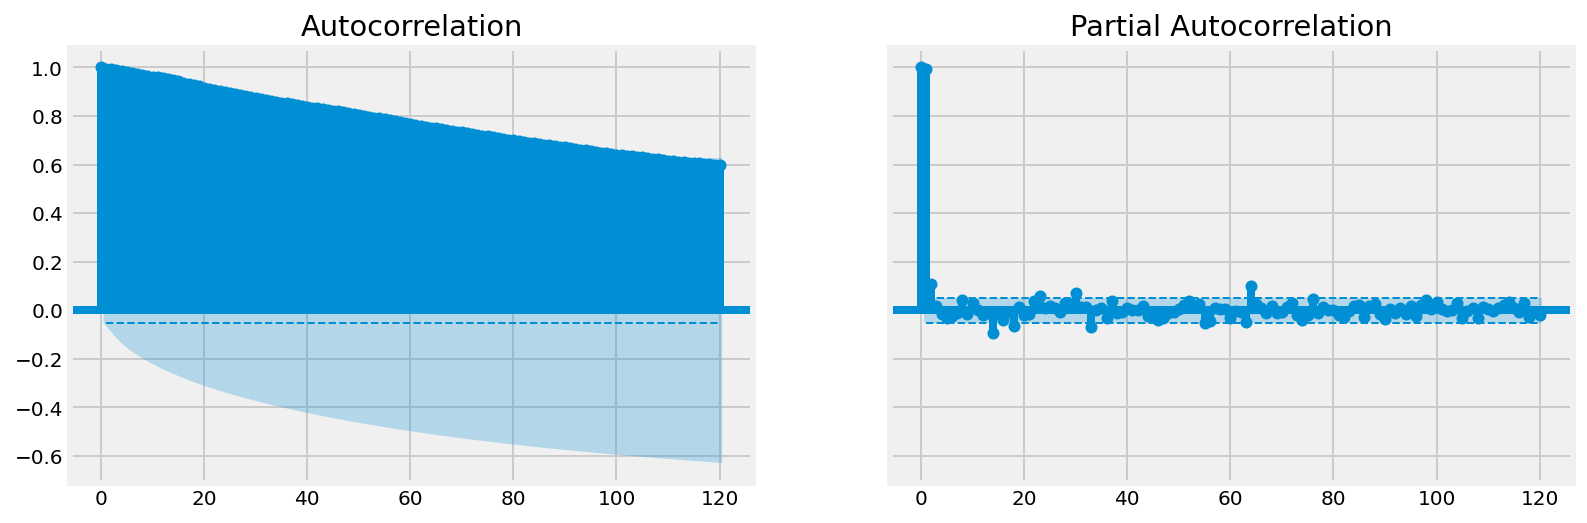

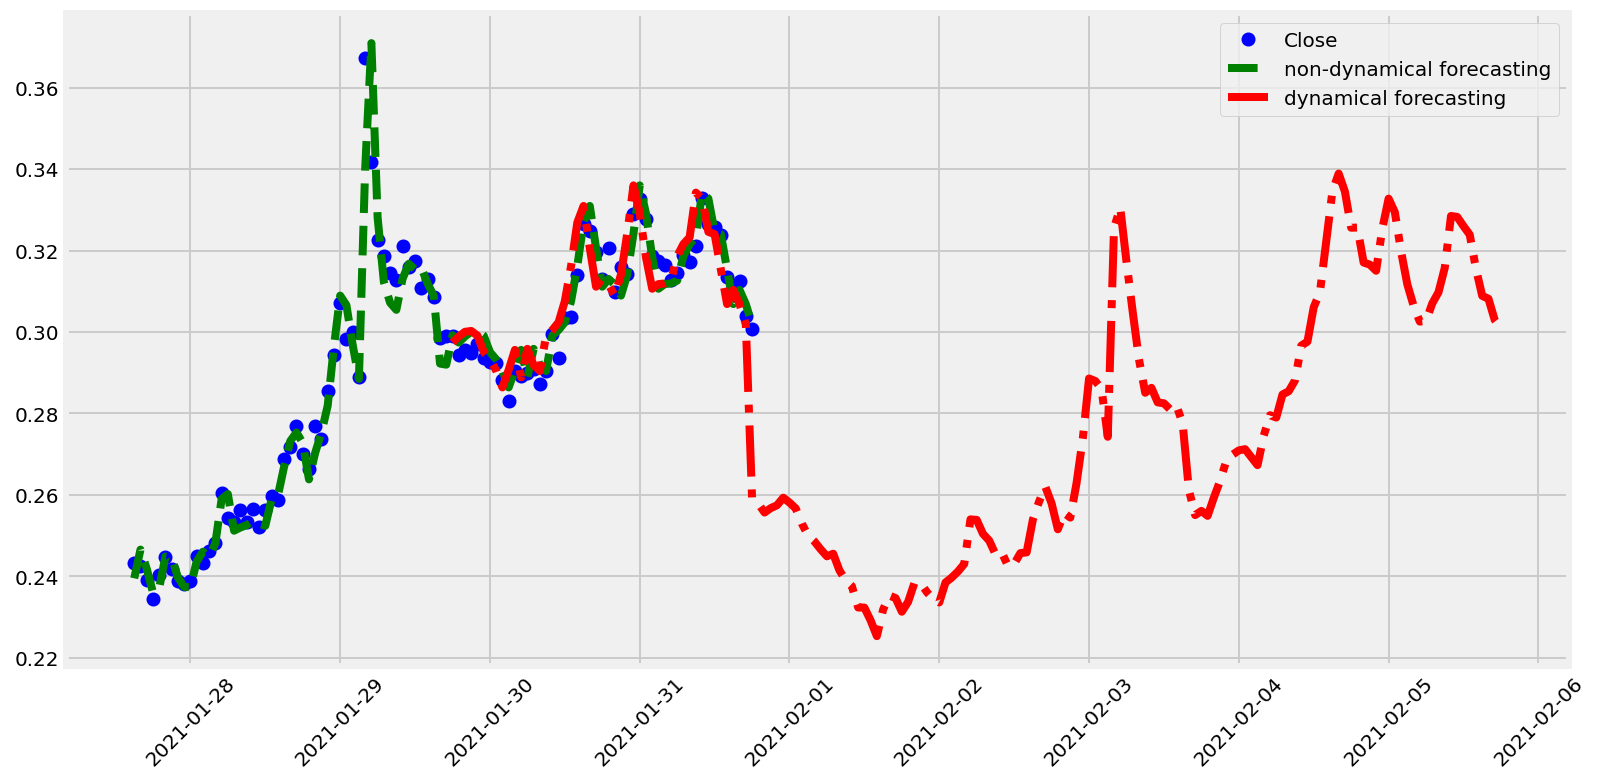

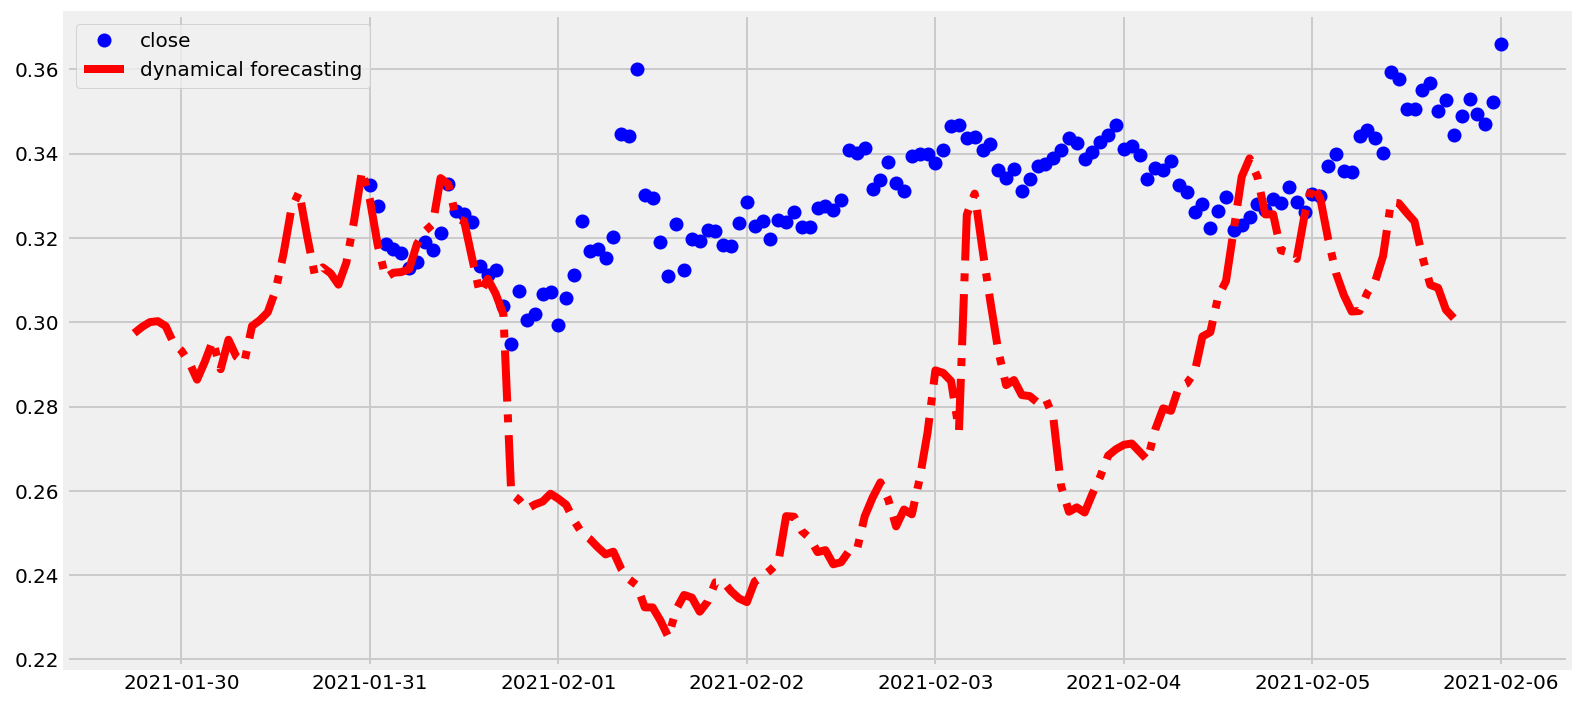

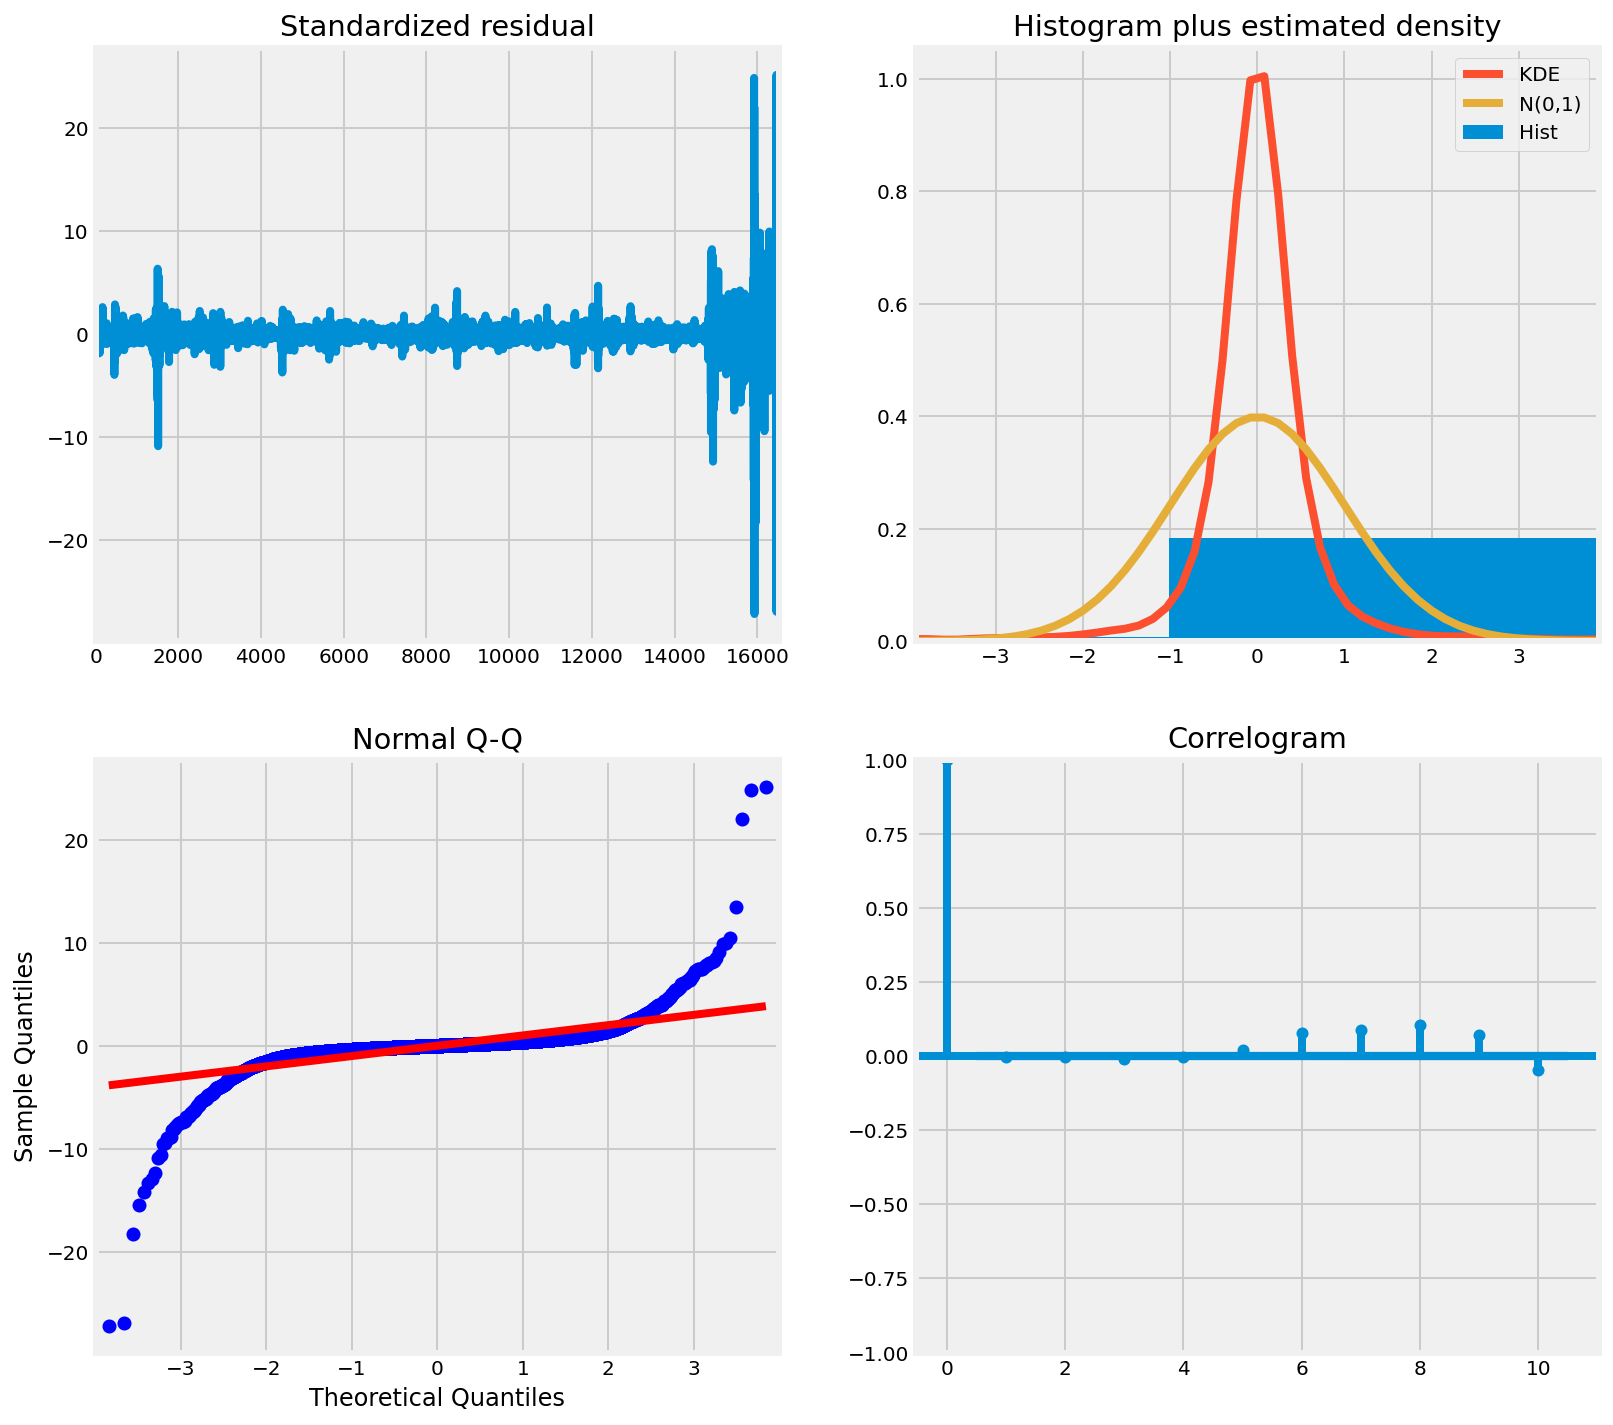

RMSE:  0.00123801283073268


In [132]:
xlm_arima_trend = model_4a(xlm_ta, "XLM-USD", trend_tis)
xlm_arima_trend


'close' Stationarity:  1
volume_adi Stationarity:  2
volume_obv Stationarity:  1
volume_cmf Stationarity:  1
volume_fi Stationarity:  1
volume_mfi Stationarity:  0
volume_em Stationarity:  0
volume_sma_em Stationarity:  0
volume_vpt Stationarity:  1
volume_nvi Stationarity:  1
volume_vwap Stationarity:  1


Total period: 

1 Hour Lag AutoCorr 0.9986324939633984
6 Hour Lag AutoCorr 0.9924908088327086
12 Hour Lag AutoCorr 0.9848898859117192
24 Hour Lag AutoCorr 0.9673246550698178


Recent period (60 Days): 

12 Hour Lag AutoCorr 0.955309717193882
24 Hour Lag AutoCorr 0.8983377201172636
48 Hour Lag AutoCorr 0.8114521735691003
120 Hour Lag AutoCorr 0.5985678341558427


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                16527
Model:               SARIMAX(1, 1, 1)   Log Likelihood               90996.915
Date:                Wed, 24 Feb 2021   AIC                        -181967.830
Time:     

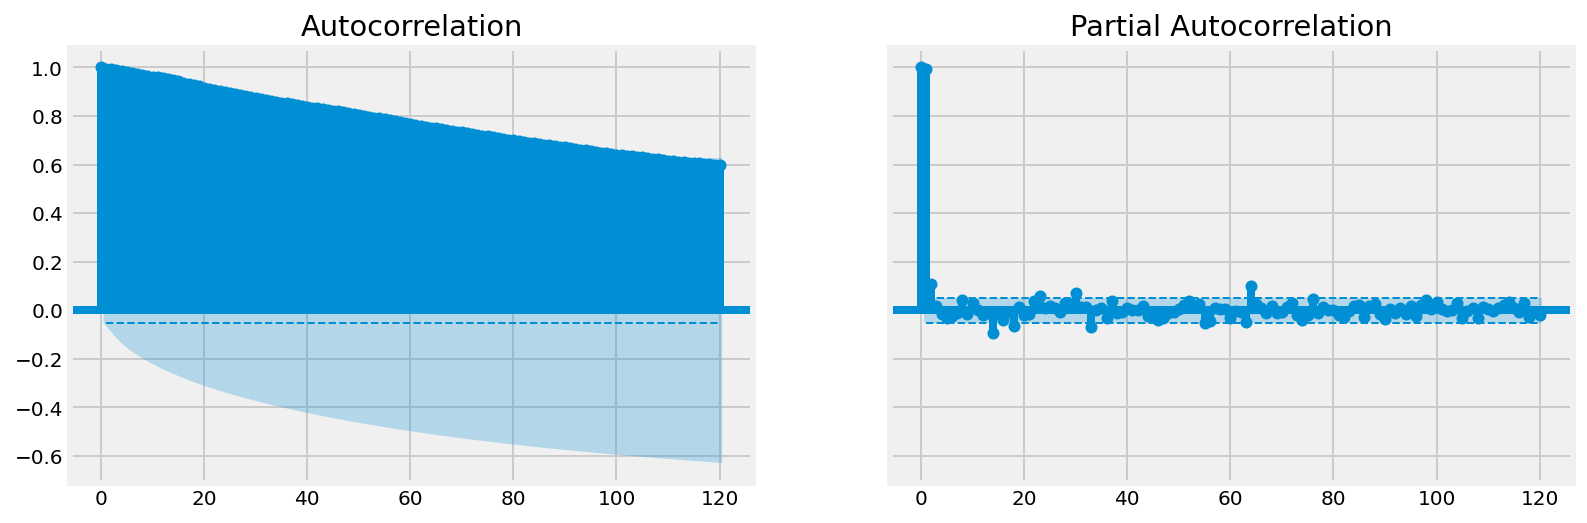

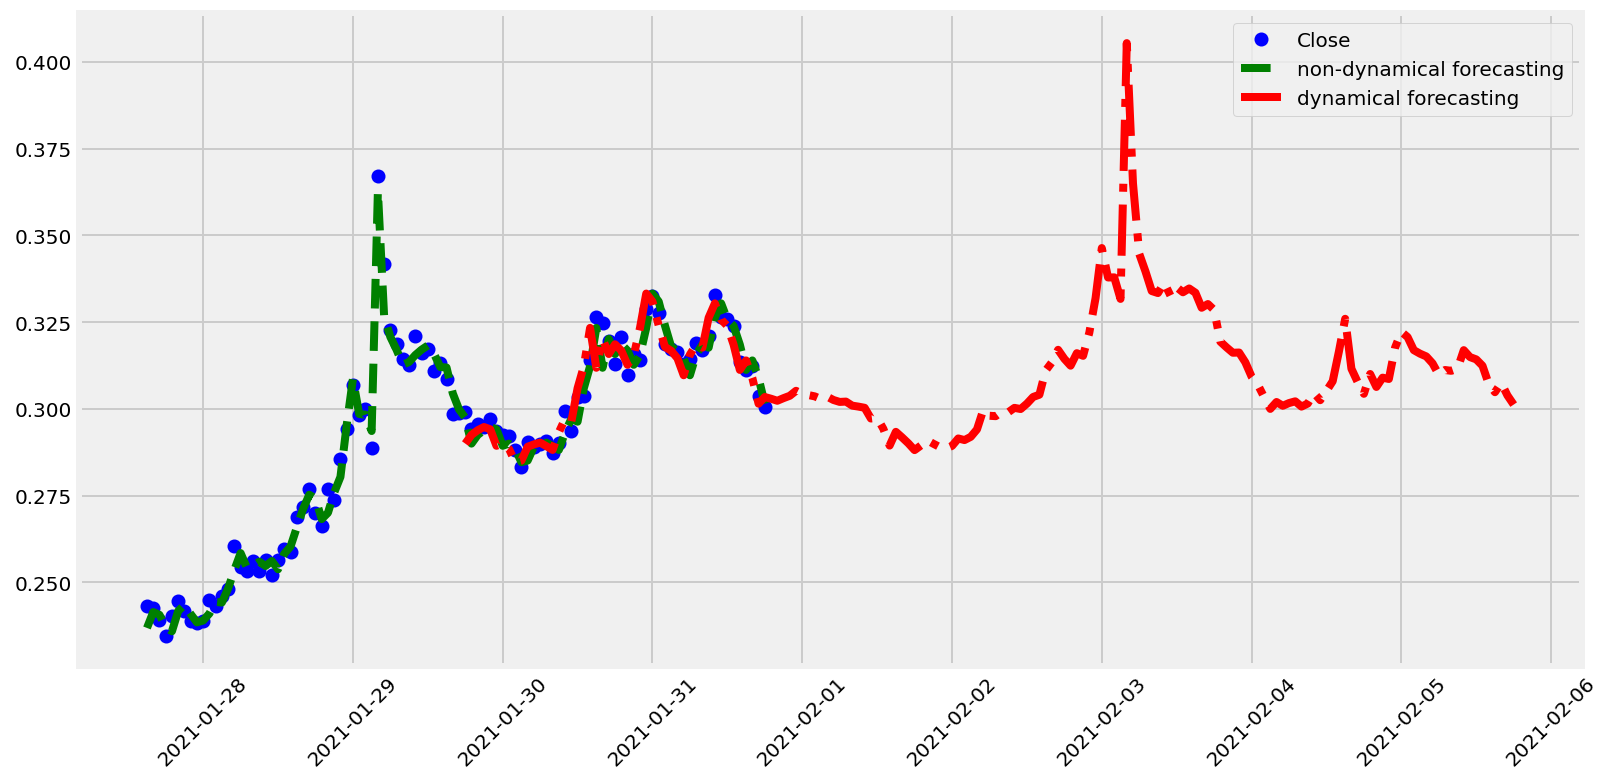

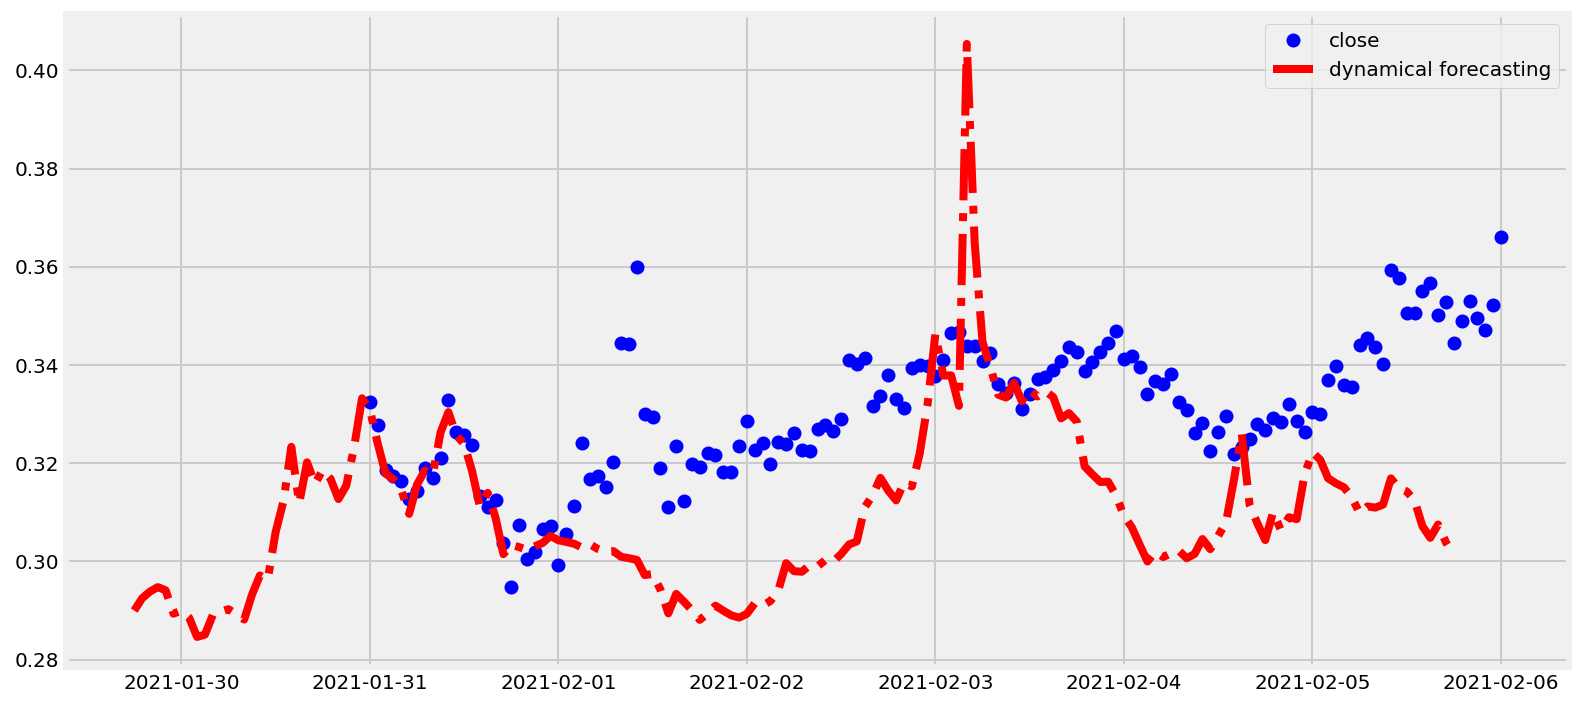

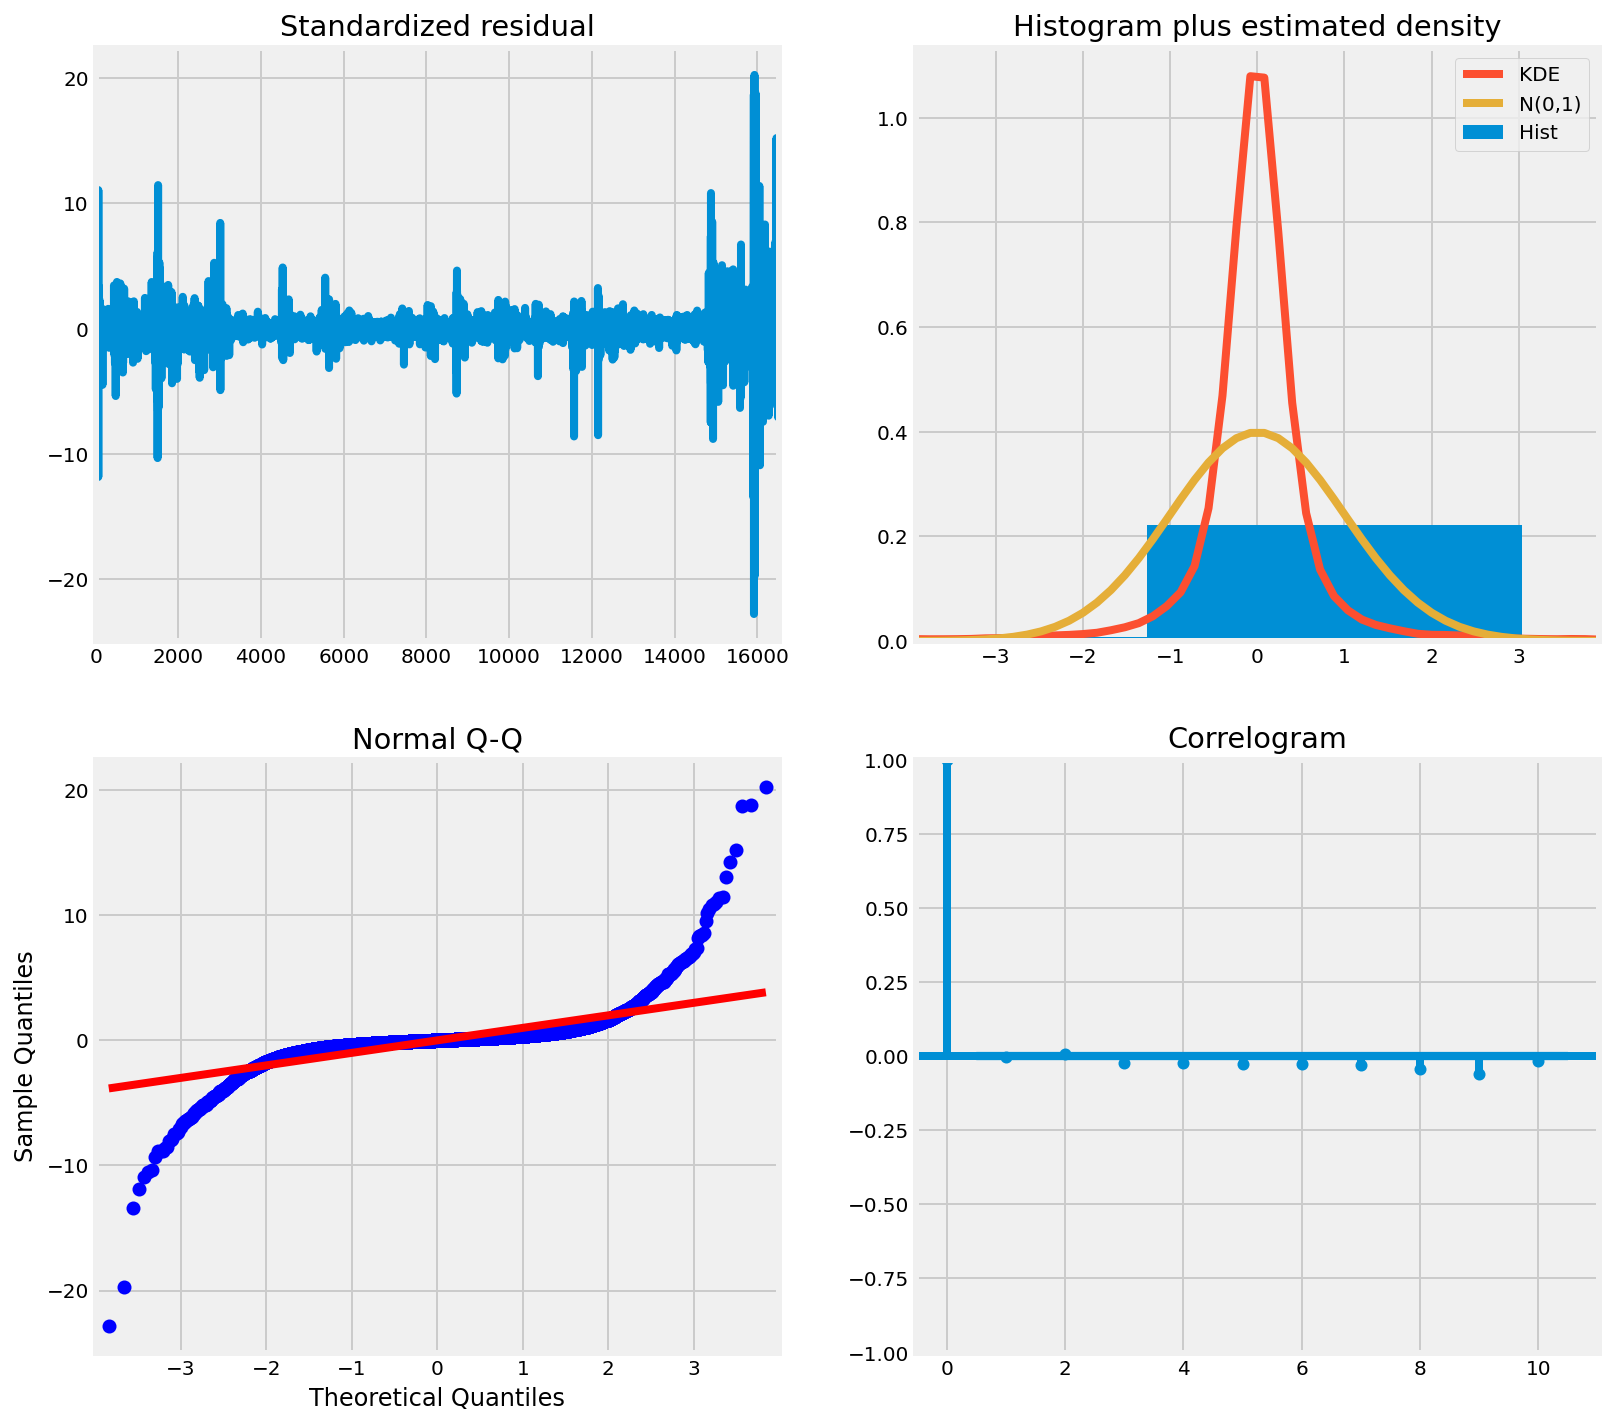

RMSE:  0.0009868616019746309


In [133]:
xlm_arima_volume = model_4a(xlm_ta, "XLM-USD", volume_tis)
xlm_arima_volume


# DASH MODEL & PLOTS

'close' Stationarity:  1
trend_macd Stationarity:  0
trend_macd_signal Stationarity:  0
trend_macd_diff Stationarity:  0
trend_sma_fast Stationarity:  1
trend_sma_slow Stationarity:  1
trend_ema_fast Stationarity:  1
trend_ema_slow Stationarity:  1
trend_adx Stationarity:  0
trend_adx_pos Stationarity:  1
trend_adx_neg Stationarity:  1
trend_vortex_ind_pos Stationarity:  1
trend_vortex_ind_neg Stationarity:  0
trend_vortex_ind_diff Stationarity:  1
trend_trix Stationarity:  0
trend_mass_index Stationarity:  0
trend_cci Stationarity:  1
trend_dpo Stationarity:  0
trend_kst Stationarity:  0
trend_kst_sig Stationarity:  0
trend_kst_diff Stationarity:  0
trend_ichimoku_conv Stationarity:  1
trend_ichimoku_base Stationarity:  1
trend_ichimoku_a Stationarity:  1
trend_ichimoku_b Stationarity:  1
trend_visual_ichimoku_a Stationarity:  1
trend_visual_ichimoku_b Stationarity:  1
trend_aroon_up Stationarity:  1
trend_aroon_down Stationarity:  1
trend_aroon_ind Stationarity:  1
trend_psar_up Stat

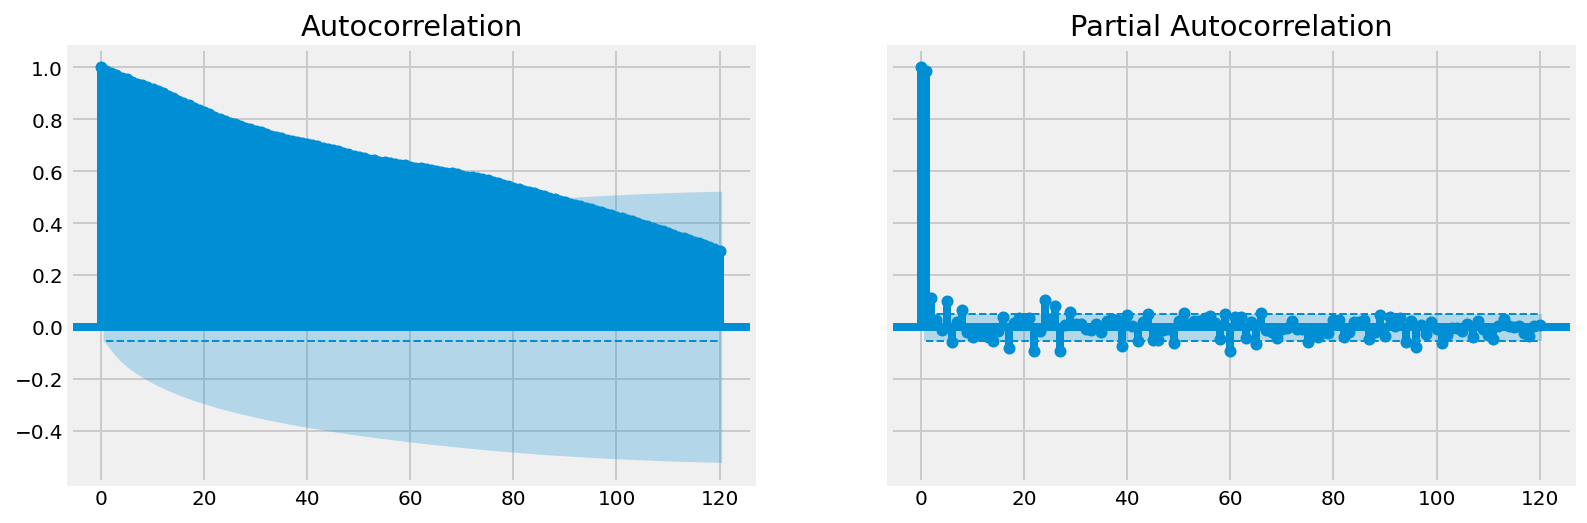

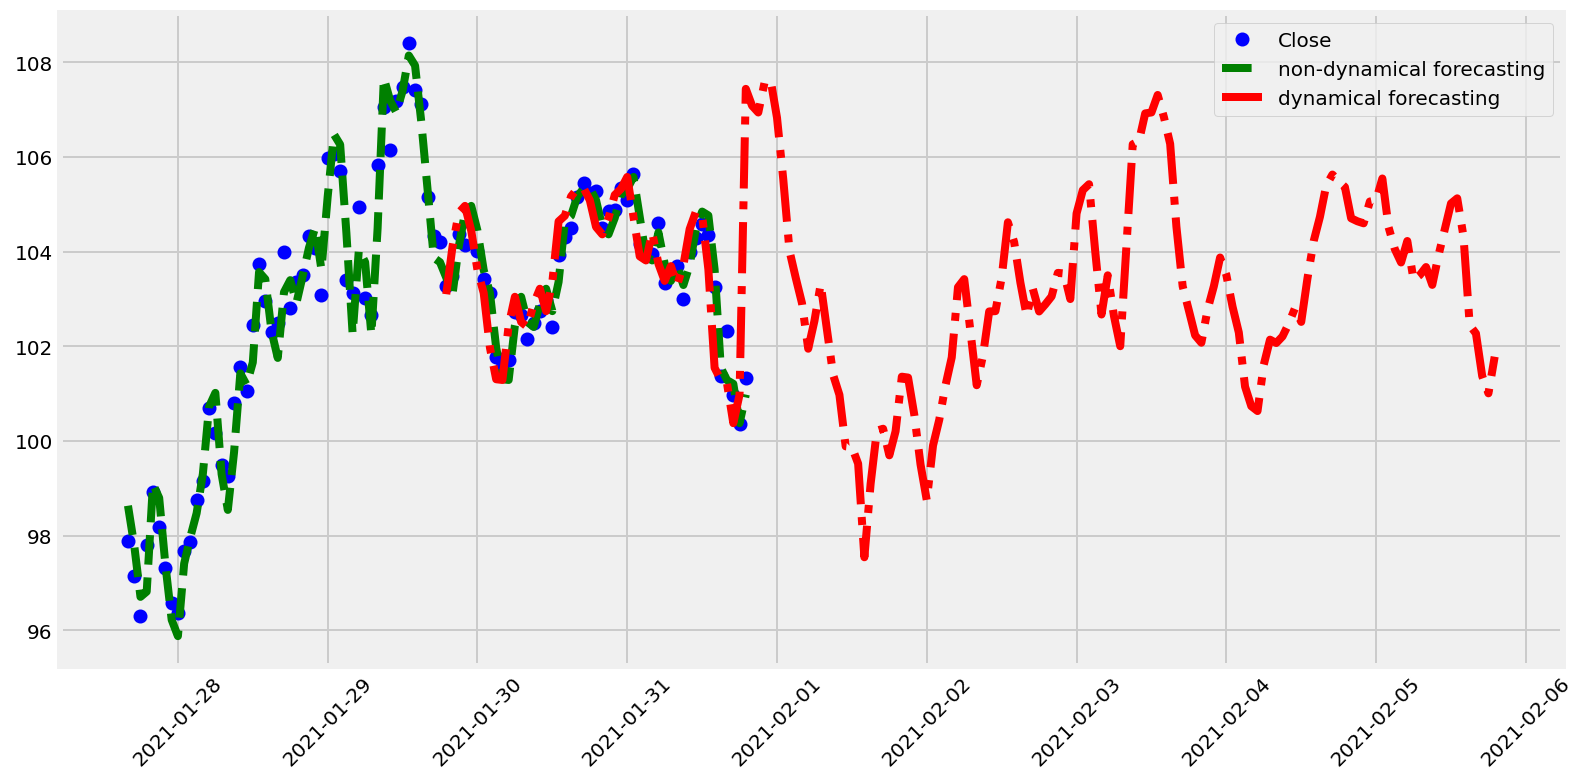

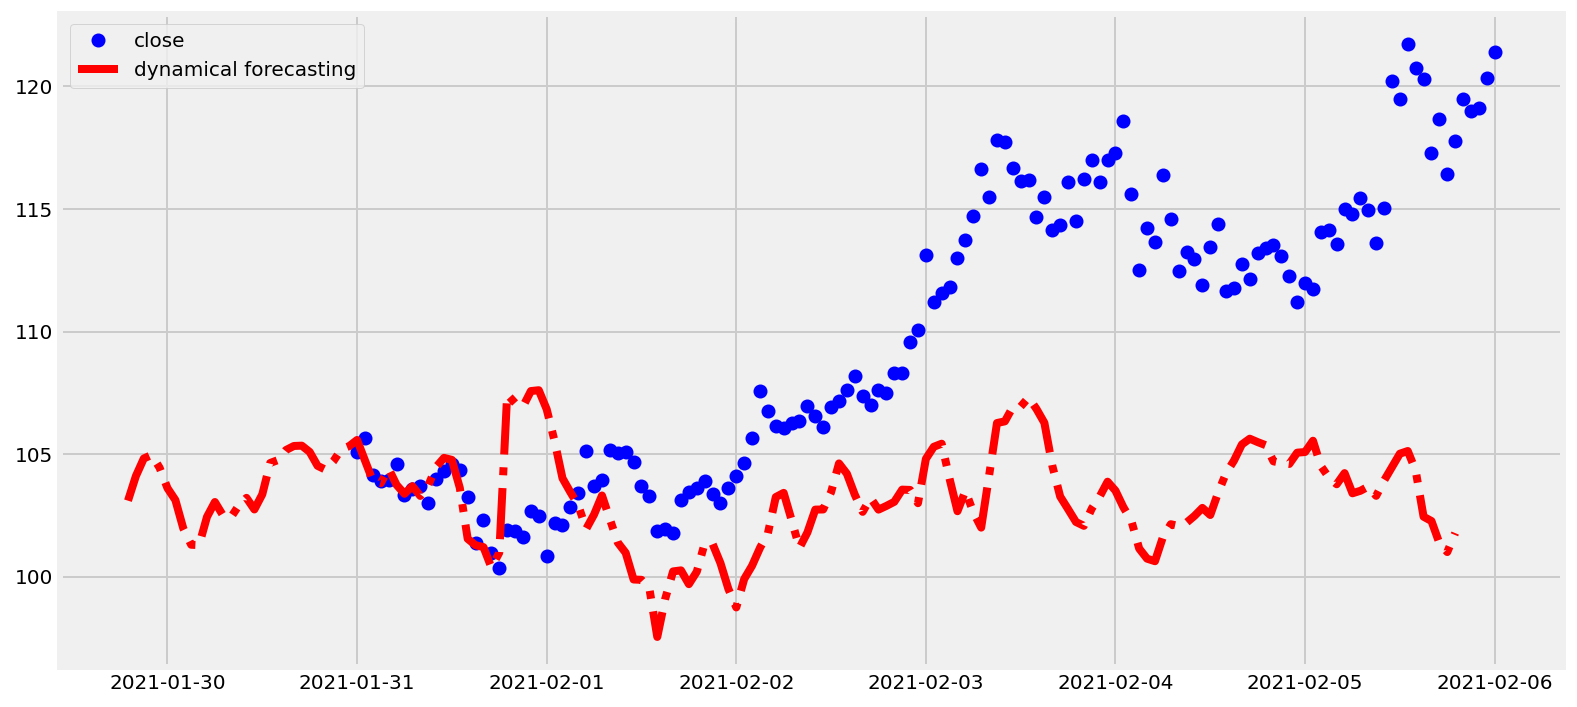

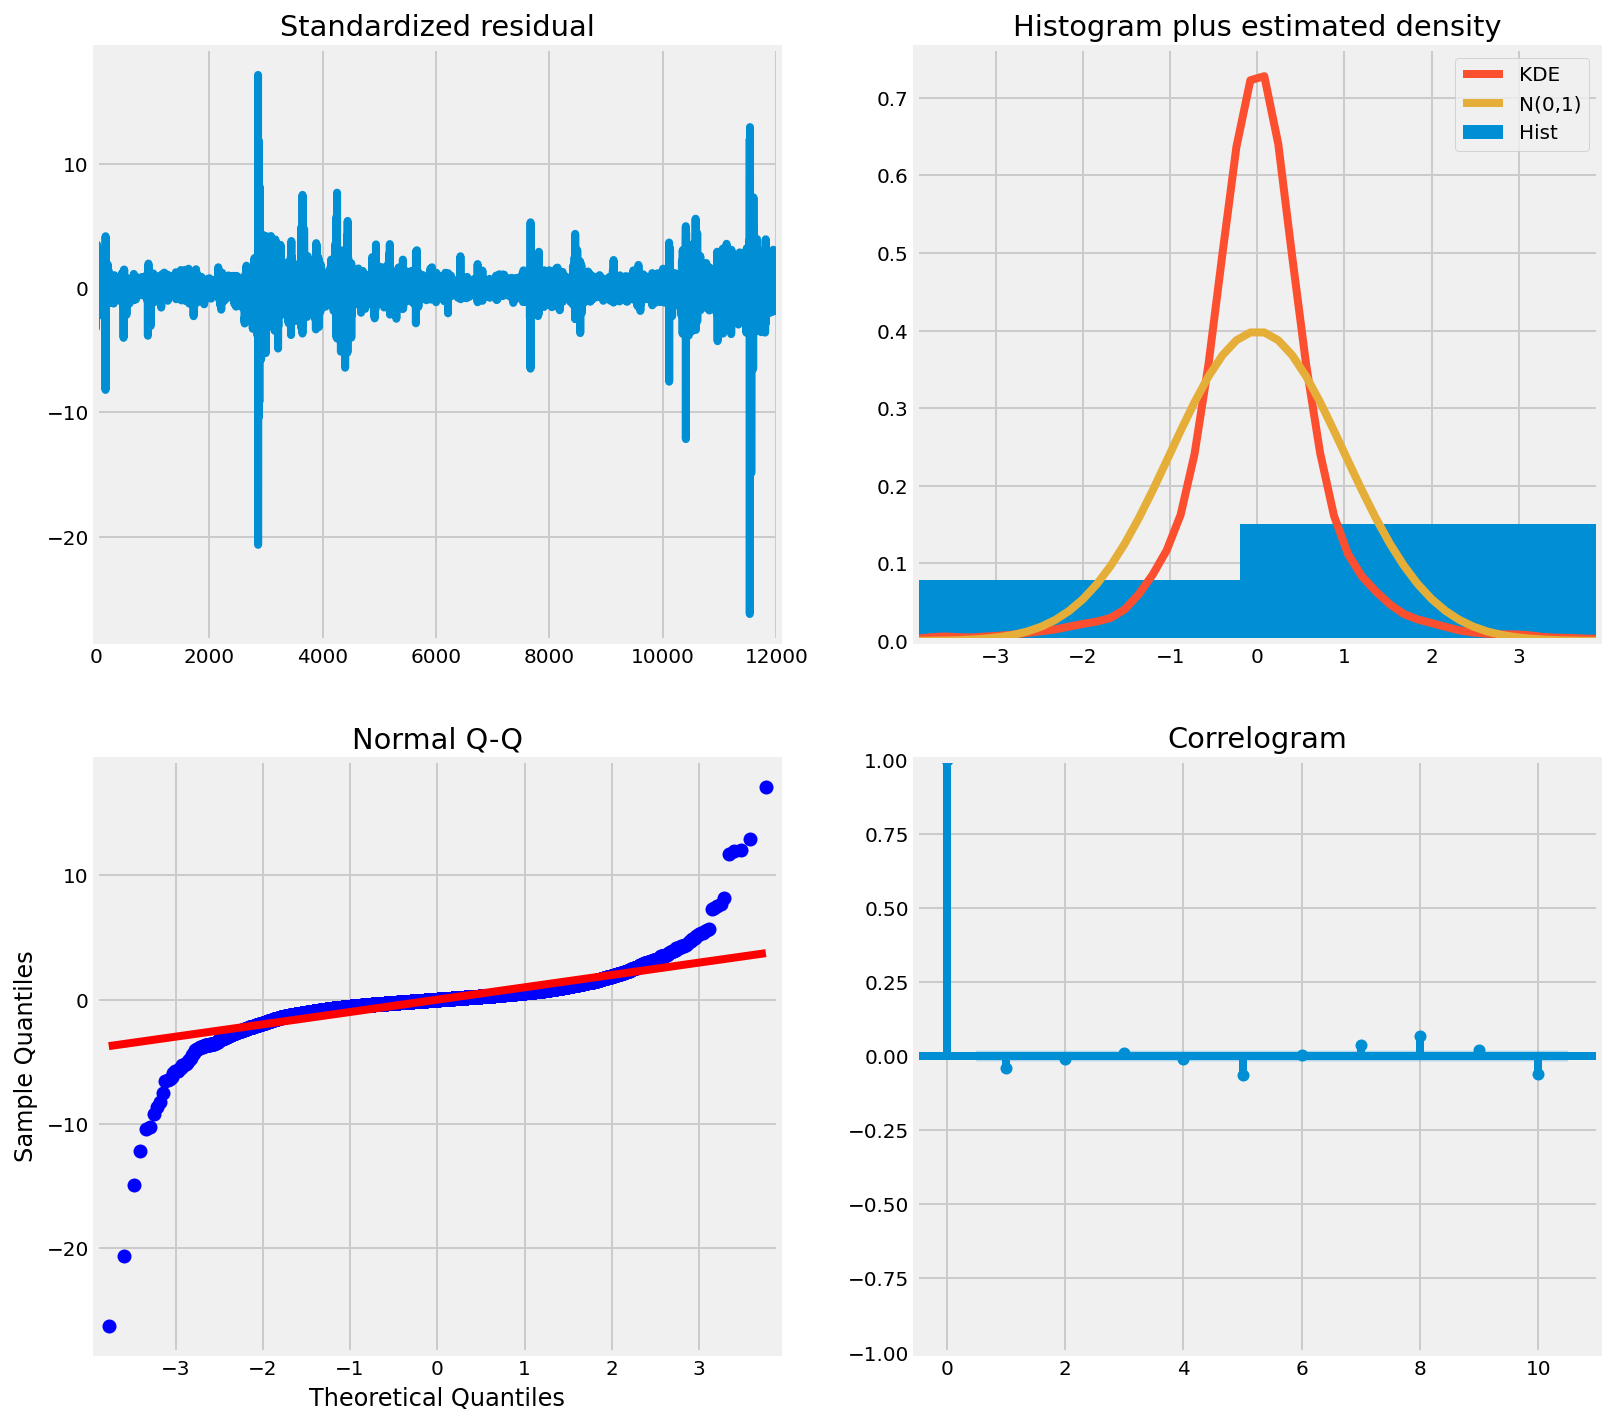

RMSE:  0.8808089236704788


In [134]:
dash_arima_trend = model_4a(dash_ta, "DASH-USD", trend_tis)
dash_arima_trend


'close' Stationarity:  1
others_dr Stationarity:  0
others_dlr Stationarity:  0
others_cr Stationarity:  1


Total period: 

1 Hour Lag AutoCorr 0.9981773060656093
6 Hour Lag AutoCorr 0.9916147381253222
12 Hour Lag AutoCorr 0.984246007951688
24 Hour Lag AutoCorr 0.9658300107792077


Recent period (60 Days): 

12 Hour Lag AutoCorr 0.9008805792659197
24 Hour Lag AutoCorr 0.7940719164869994
48 Hour Lag AutoCorr 0.666802401594958
120 Hour Lag AutoCorr 0.29543397418540907


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12049
Model:               SARIMAX(1, 1, 0)   Log Likelihood              127829.492
Date:                Wed, 24 Feb 2021   AIC                        -255648.983
Time:                        19:29:16   BIC                        -255612.000
Sample:                             0   HQIC                       -255636.580
                              - 12049               

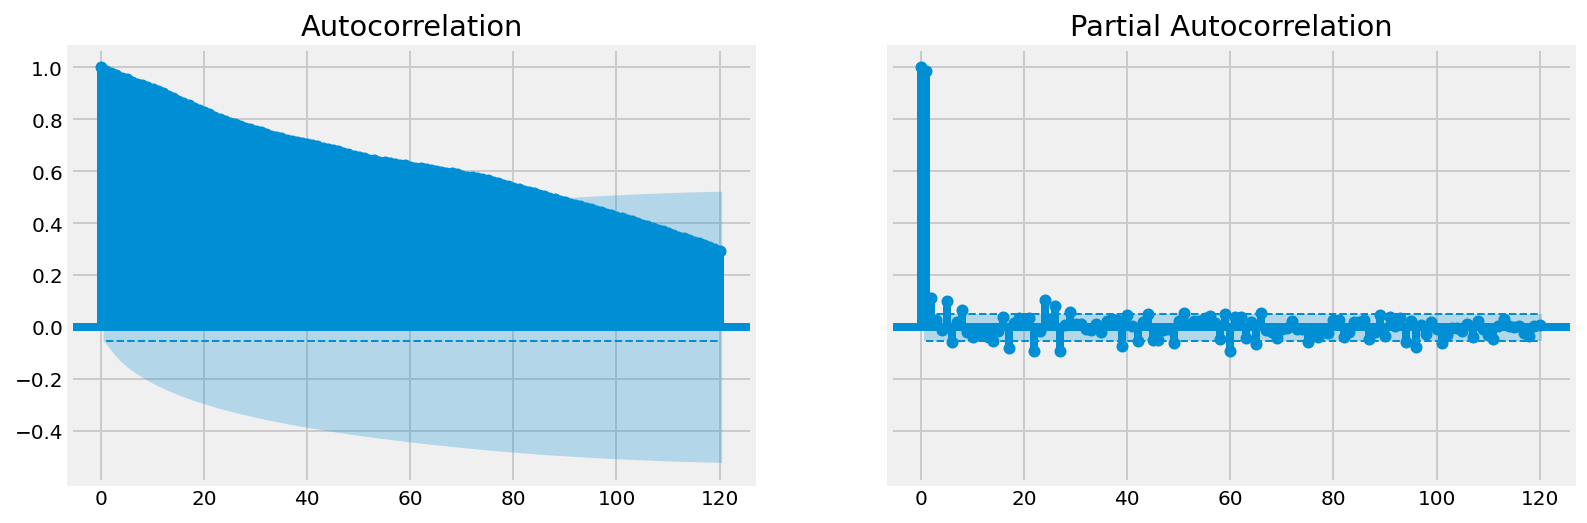

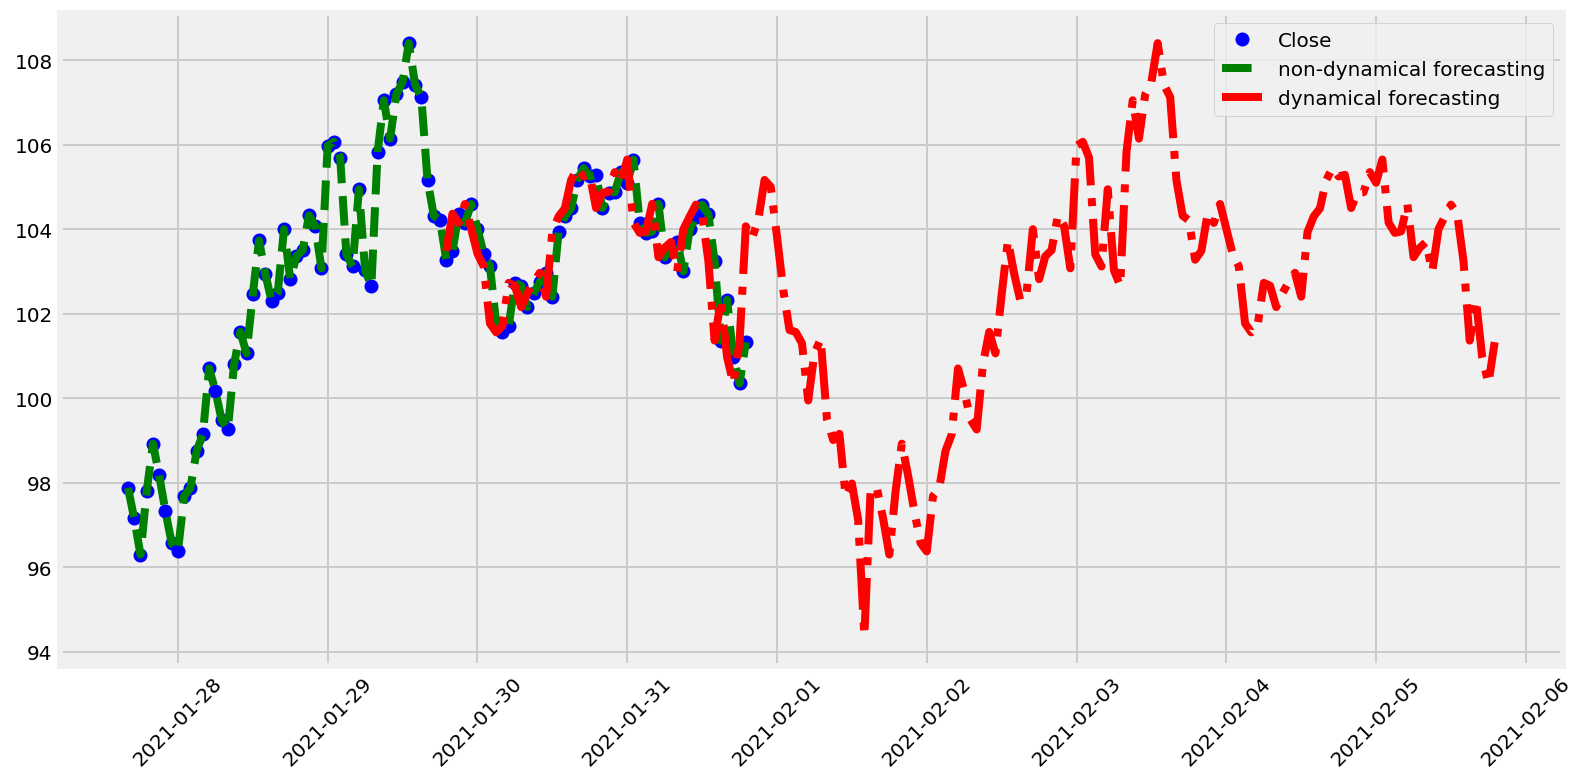

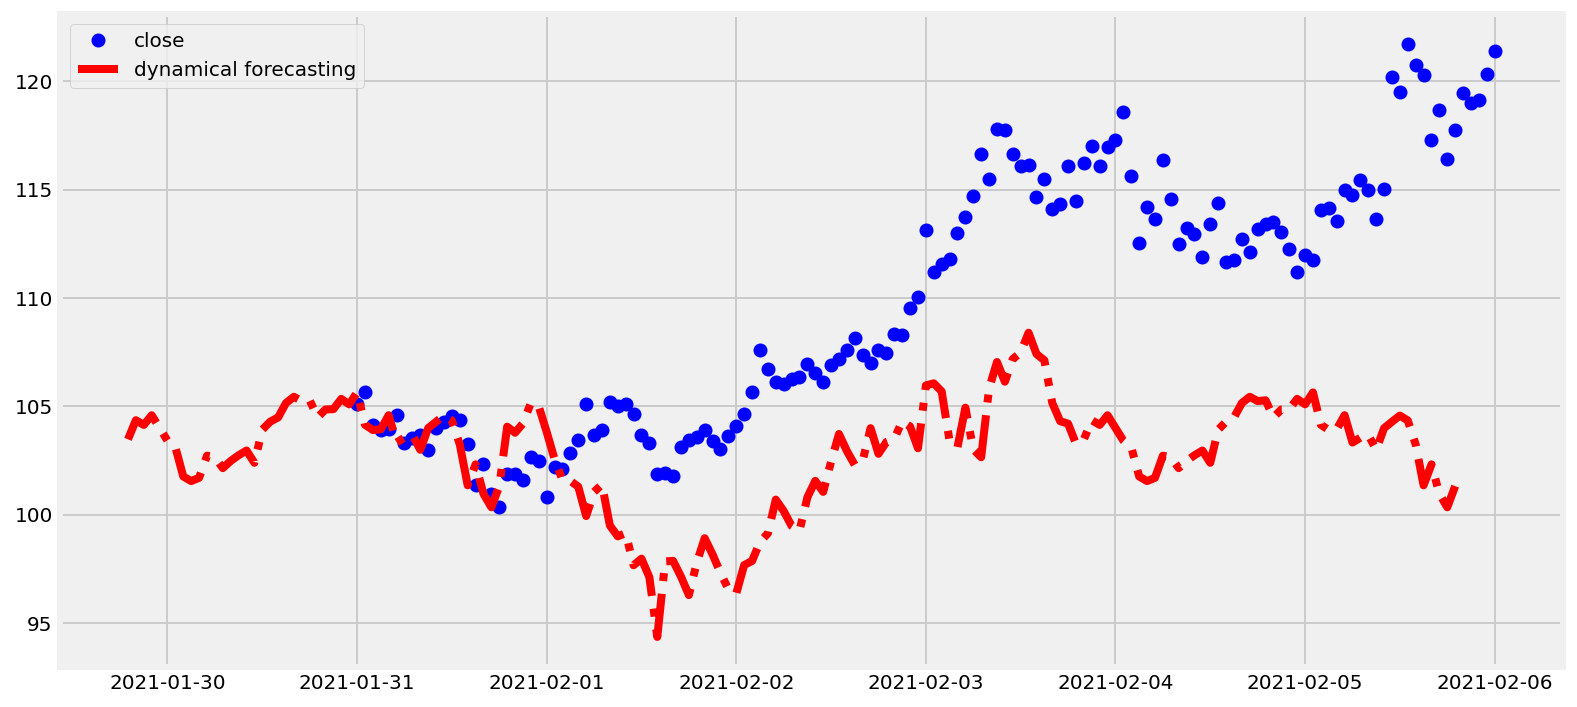

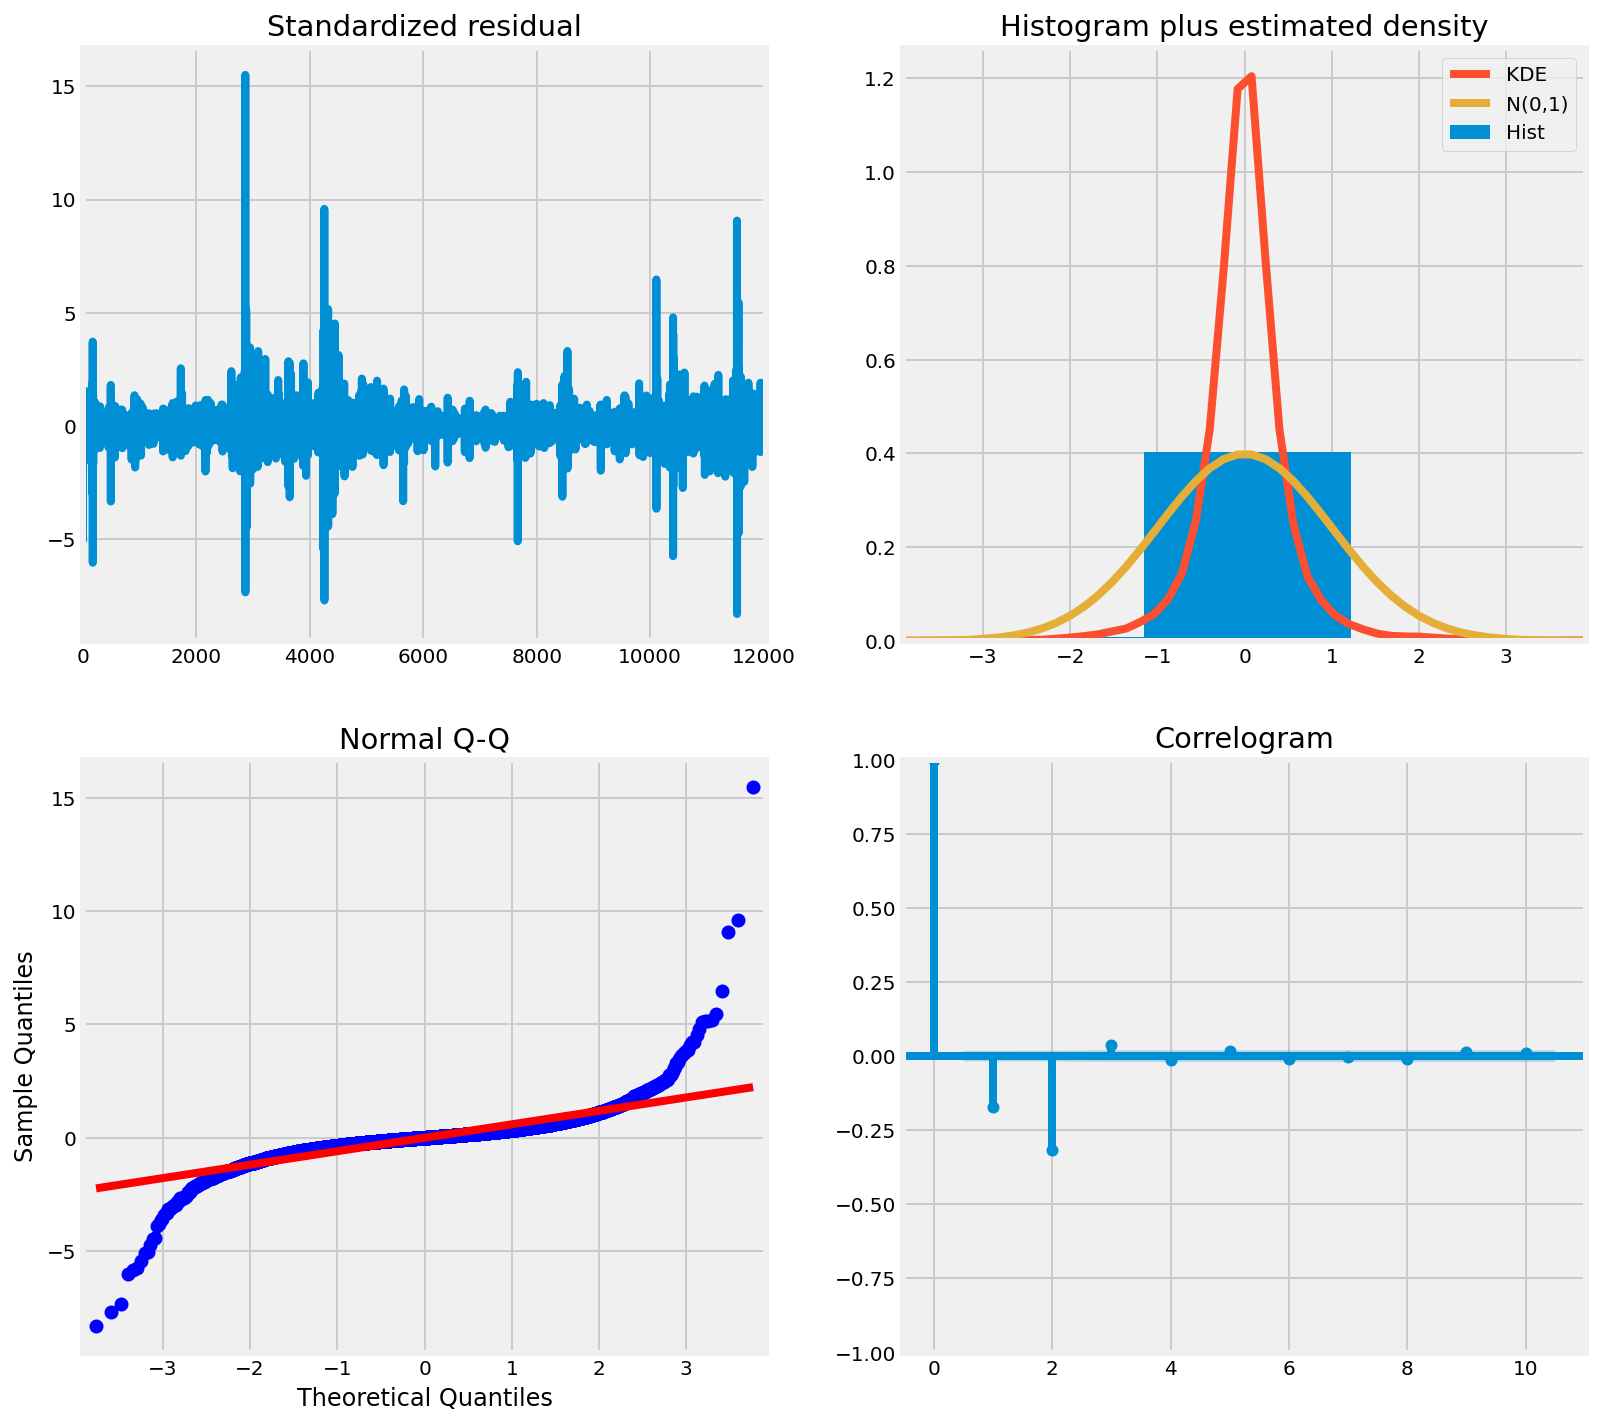

RMSE:  0.9019030215032332


In [135]:
dash_arima_others = model_4a(dash_ta, "DASH-USD", others_tis)
dash_arima_others


# LINK MODEL & PLOTS

'close' Stationarity:  1
trend_macd Stationarity:  1
trend_macd_signal Stationarity:  1
trend_macd_diff Stationarity:  0
trend_sma_fast Stationarity:  1
trend_sma_slow Stationarity:  2
trend_ema_fast Stationarity:  1
trend_ema_slow Stationarity:  2
trend_adx Stationarity:  0
trend_adx_pos Stationarity:  0
trend_adx_neg Stationarity:  1
trend_vortex_ind_pos Stationarity:  1
trend_vortex_ind_neg Stationarity:  1
trend_vortex_ind_diff Stationarity:  1
trend_trix Stationarity:  1
trend_mass_index Stationarity:  0
trend_cci Stationarity:  1
trend_dpo Stationarity:  0
trend_kst Stationarity:  1
trend_kst_sig Stationarity:  1
trend_kst_diff Stationarity:  0
trend_ichimoku_conv Stationarity:  1
trend_ichimoku_base Stationarity:  2
trend_ichimoku_a Stationarity:  1
trend_ichimoku_b Stationarity:  2
trend_visual_ichimoku_a Stationarity:  2
trend_visual_ichimoku_b Stationarity:  2
trend_aroon_up Stationarity:  1
trend_aroon_down Stationarity:  0
trend_aroon_ind Stationarity:  1
trend_psar_up Stat

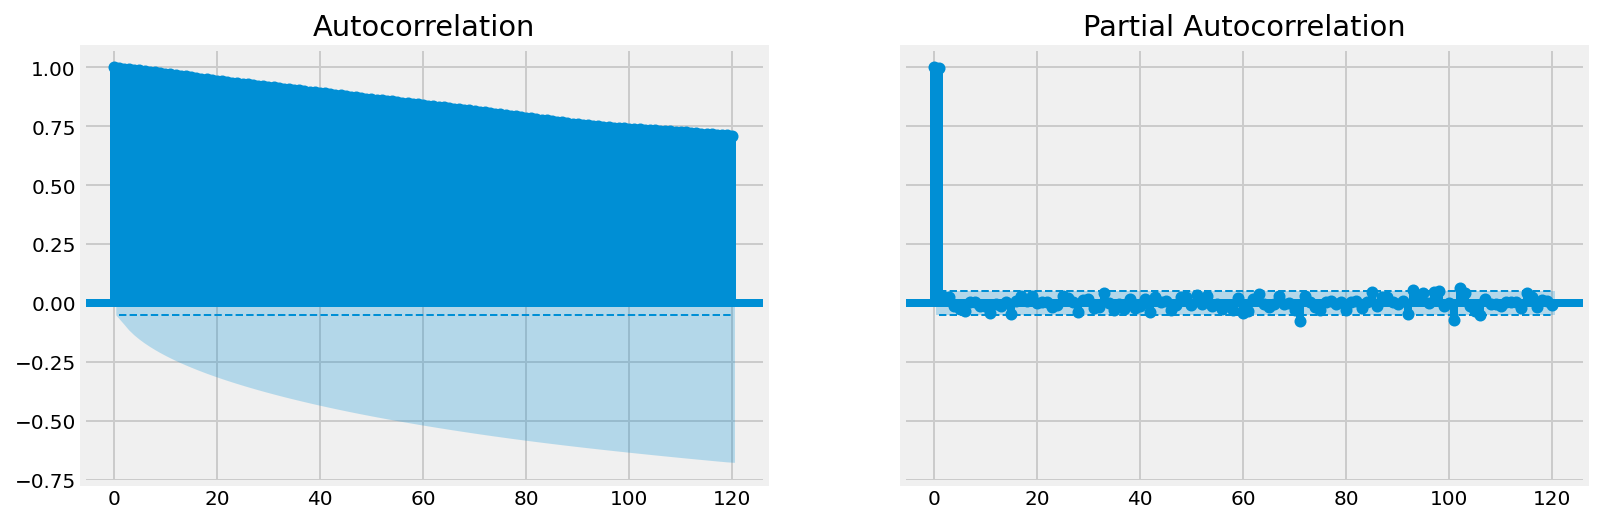

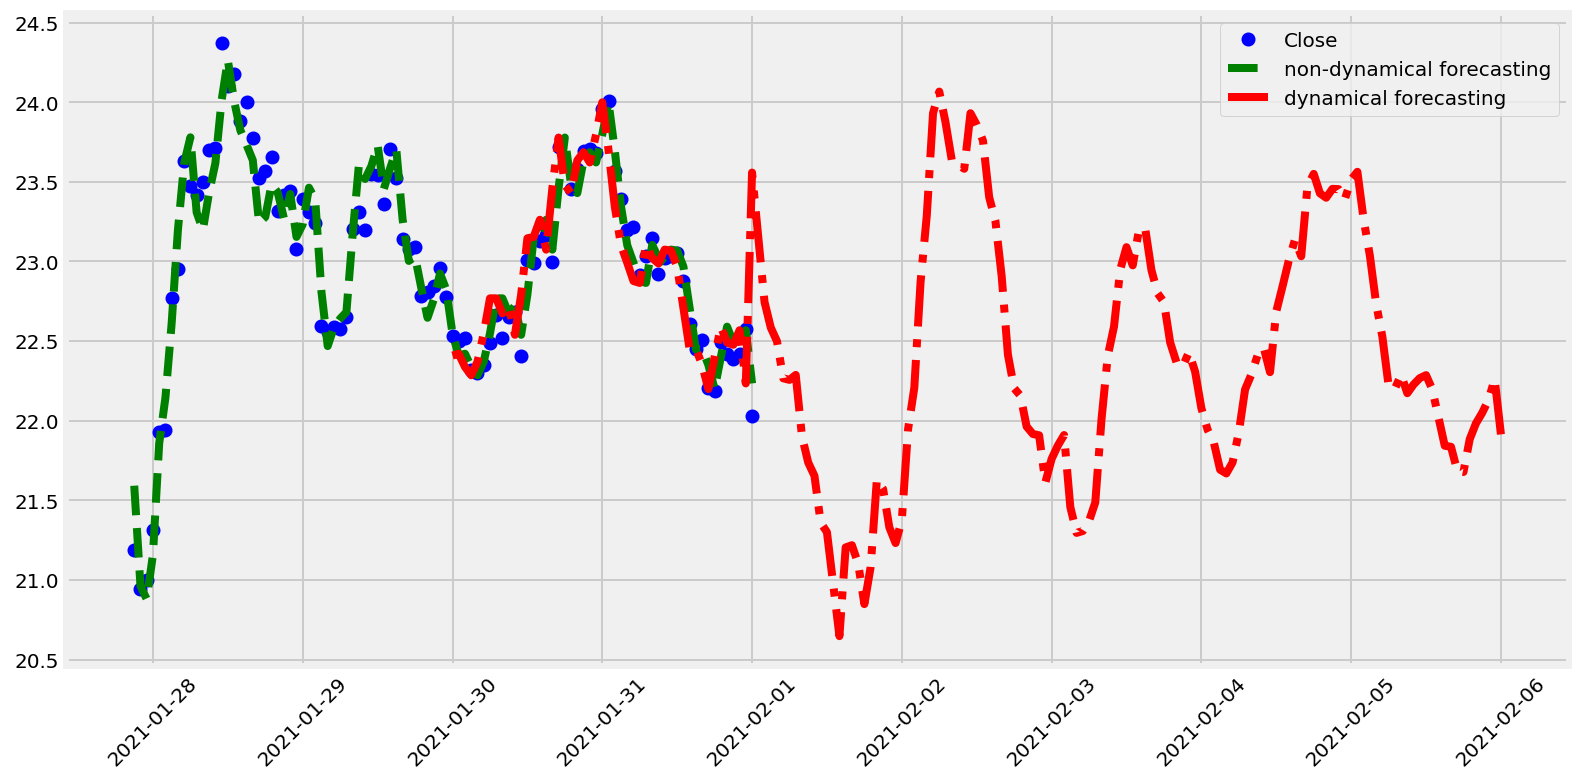

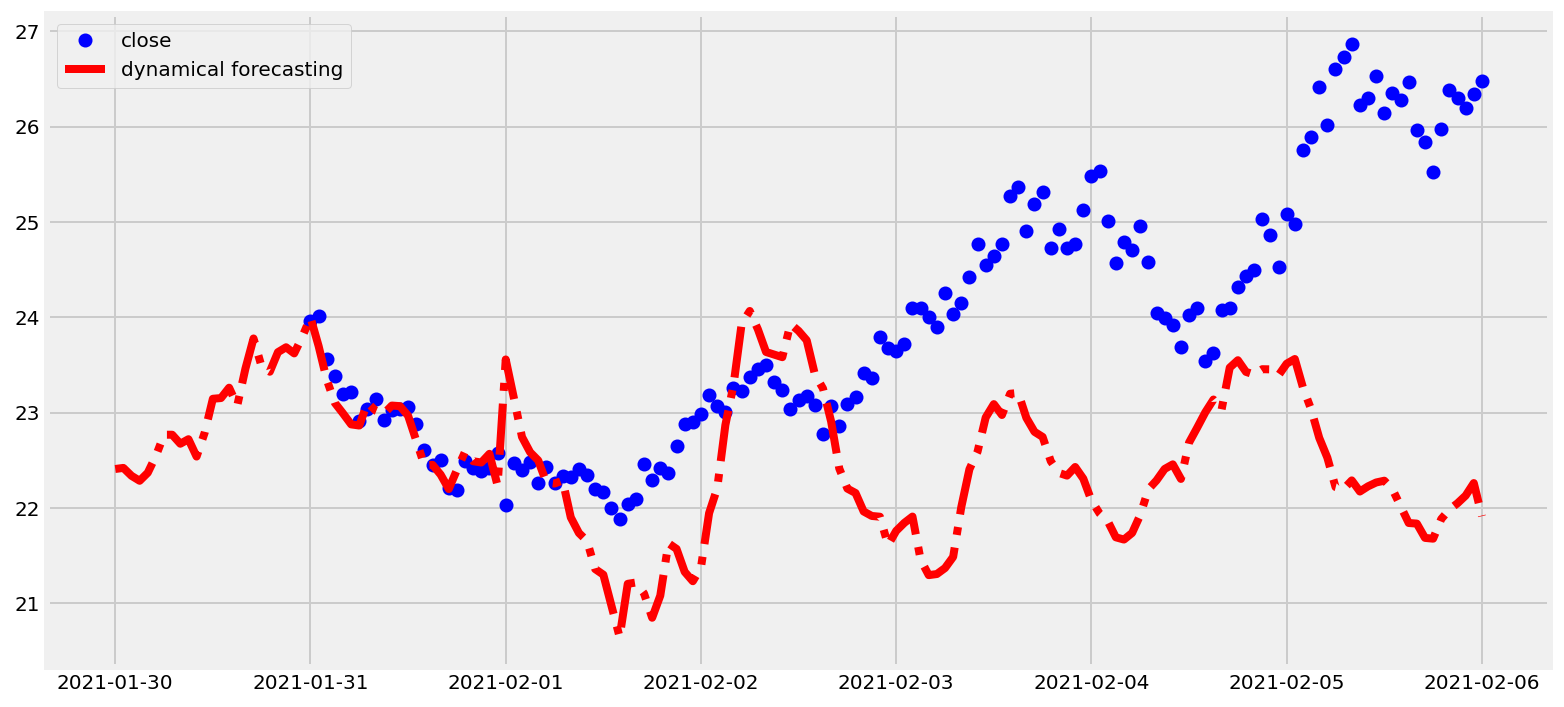

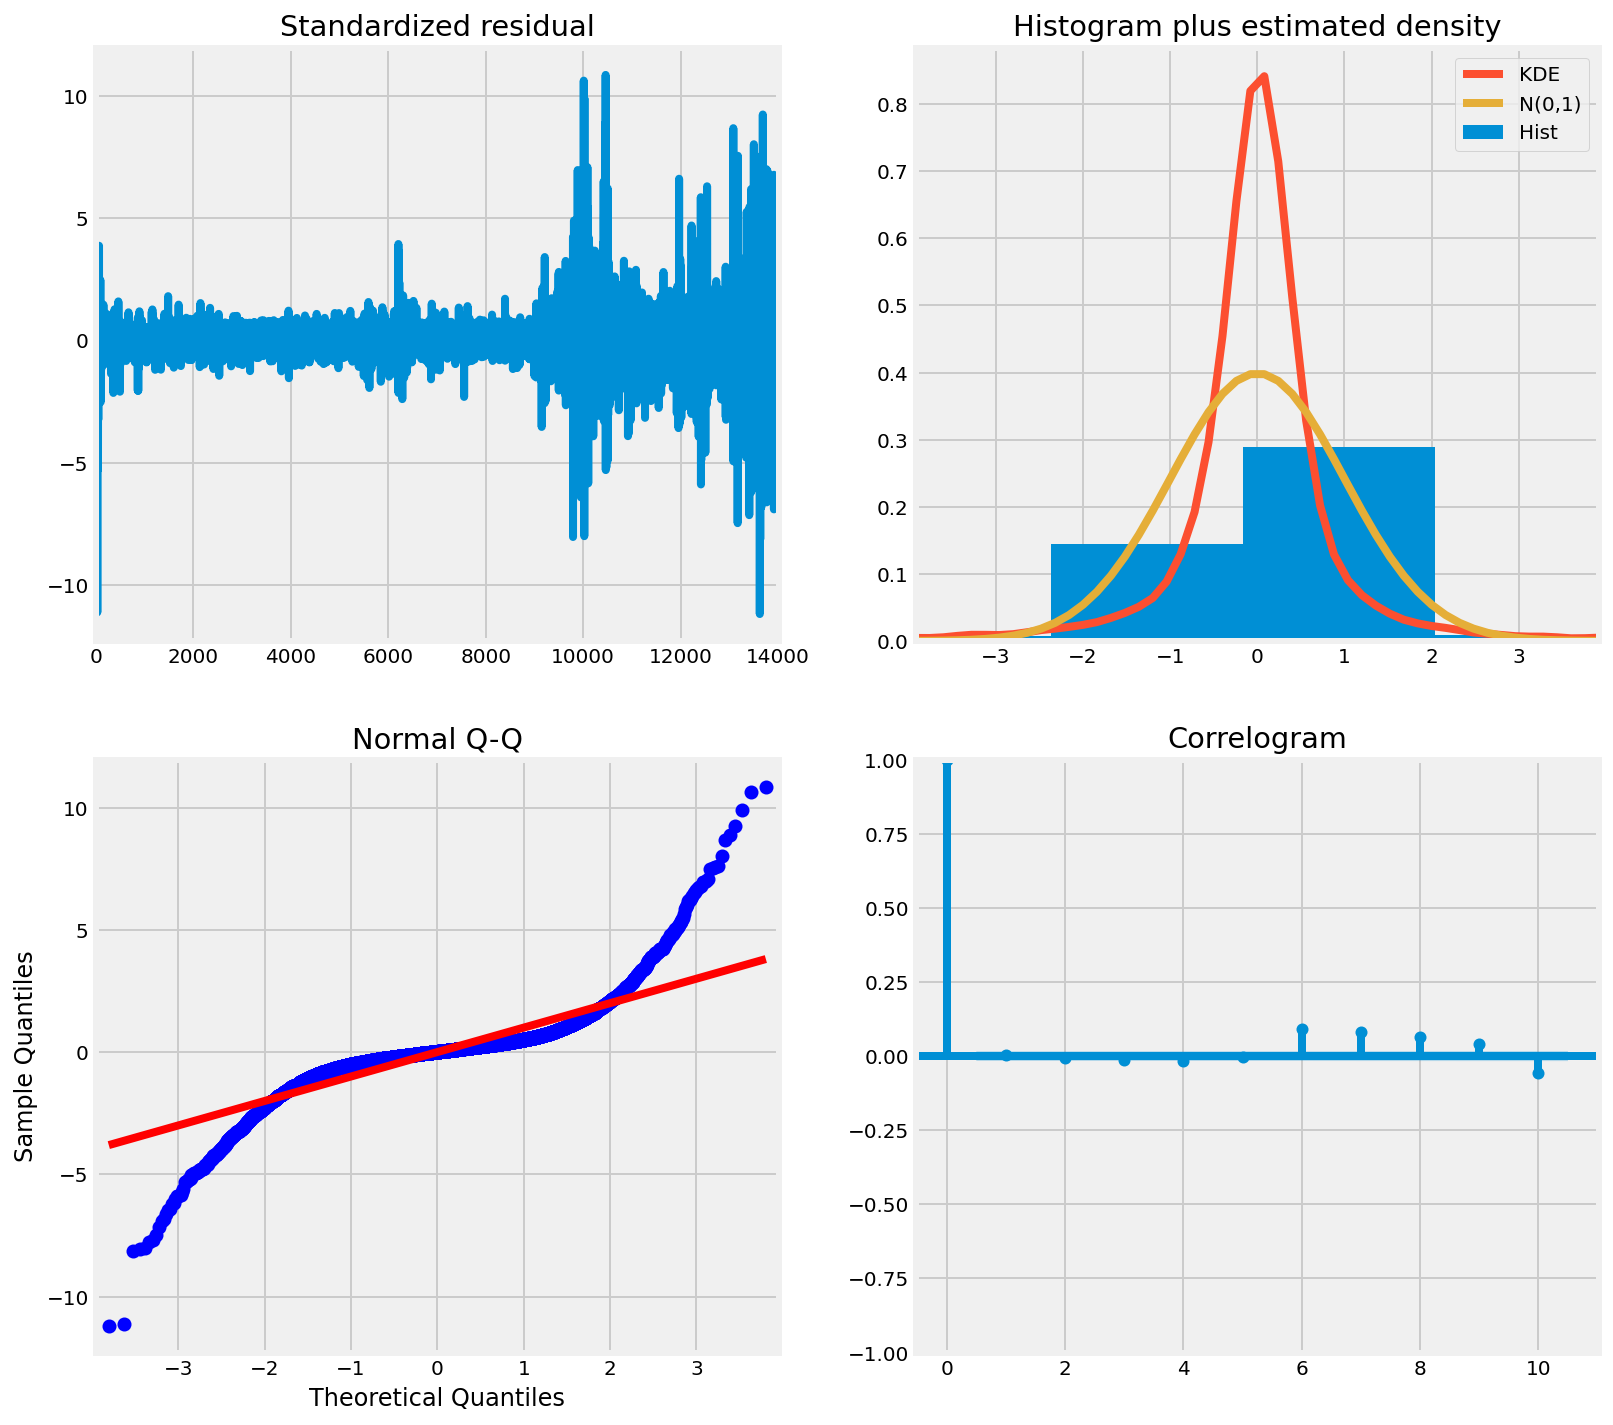

RMSE:  0.07142291822426473


In [136]:
link_arima_trend = model_4a(link_ta, "LINK-USD", trend_tis)
link_arima_trend


'close' Stationarity:  1
momentum_rsi Stationarity:  1
momentum_stoch_rsi Stationarity:  0
momentum_stoch_rsi_k Stationarity:  0
momentum_stoch_rsi_d Stationarity:  0
momentum_tsi Stationarity:  1
momentum_uo Stationarity:  1
momentum_stoch Stationarity:  1
momentum_stoch_signal Stationarity:  1
momentum_wr Stationarity:  1
momentum_ao Stationarity:  1
momentum_kama Stationarity:  1
momentum_roc Stationarity:  0
momentum_ppo Stationarity:  0
momentum_ppo_signal Stationarity:  0
momentum_ppo_hist Stationarity:  0


Total period: 

1 Hour Lag AutoCorr 0.9993731741231124
6 Hour Lag AutoCorr 0.9964335046485622
12 Hour Lag AutoCorr 0.9927206638054599
24 Hour Lag AutoCorr 0.9846721745001162


Recent period (60 Days): 

12 Hour Lag AutoCorr 0.968183821278034
24 Hour Lag AutoCorr 0.9334533019542887
48 Hour Lag AutoCorr 0.8707884874322276
120 Hour Lag AutoCorr 0.7113562904750936


                               SARIMAX Results                                
Dep. Variable:                      

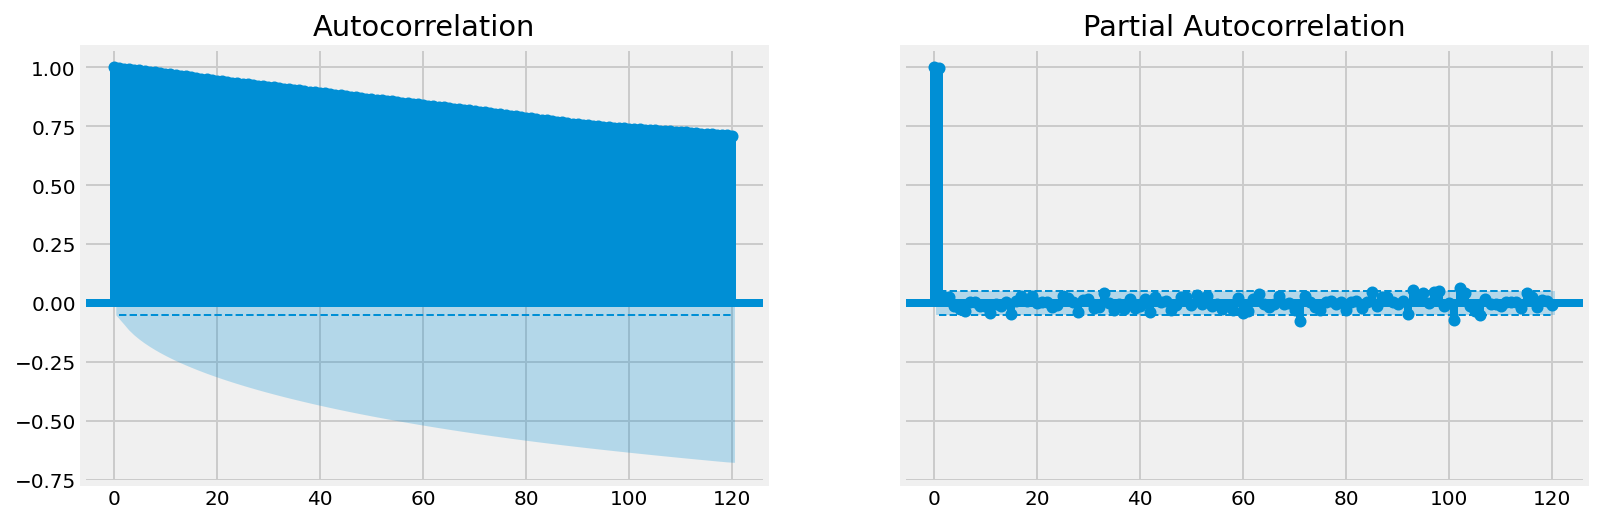

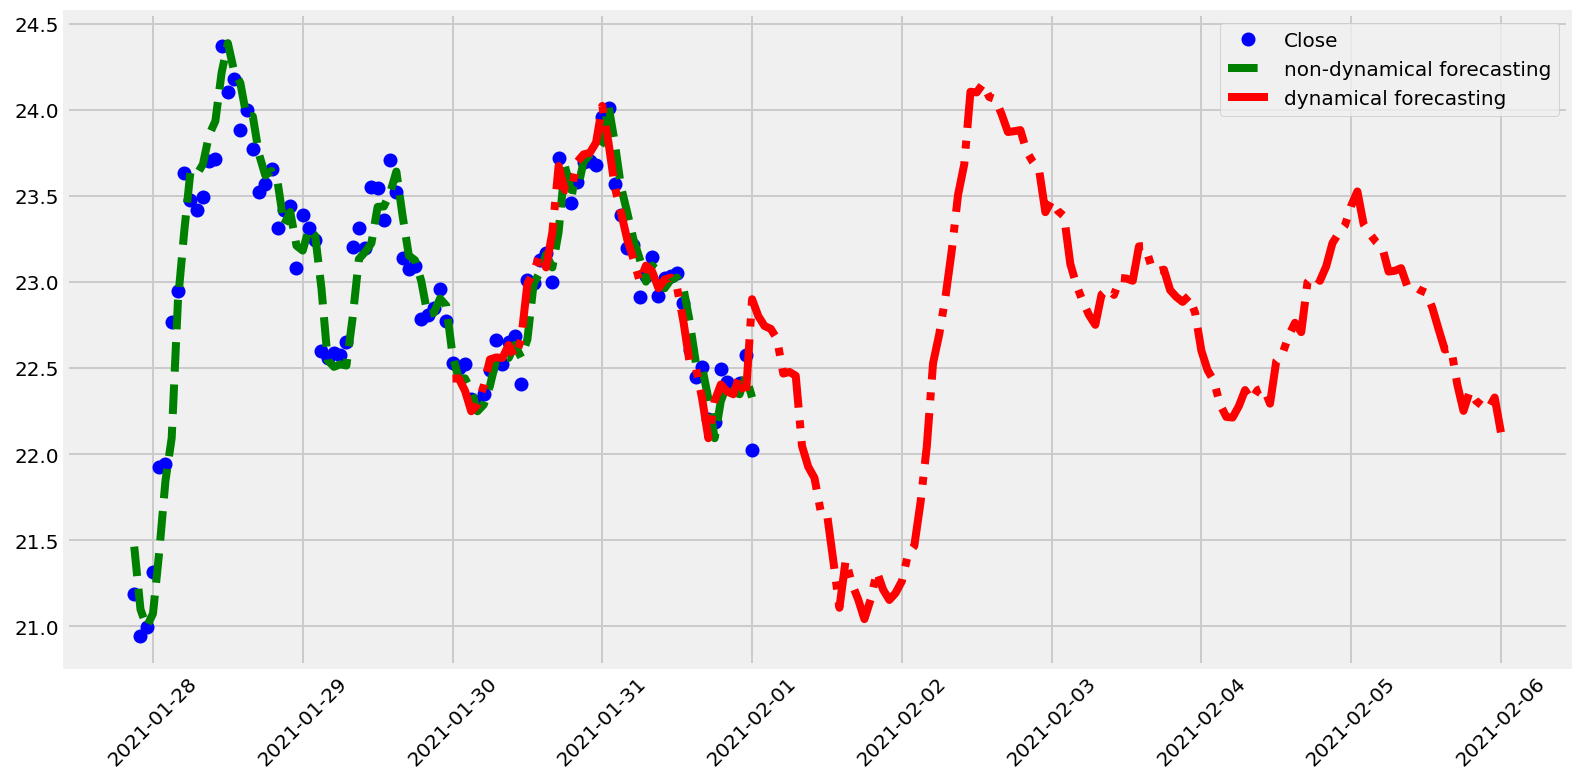

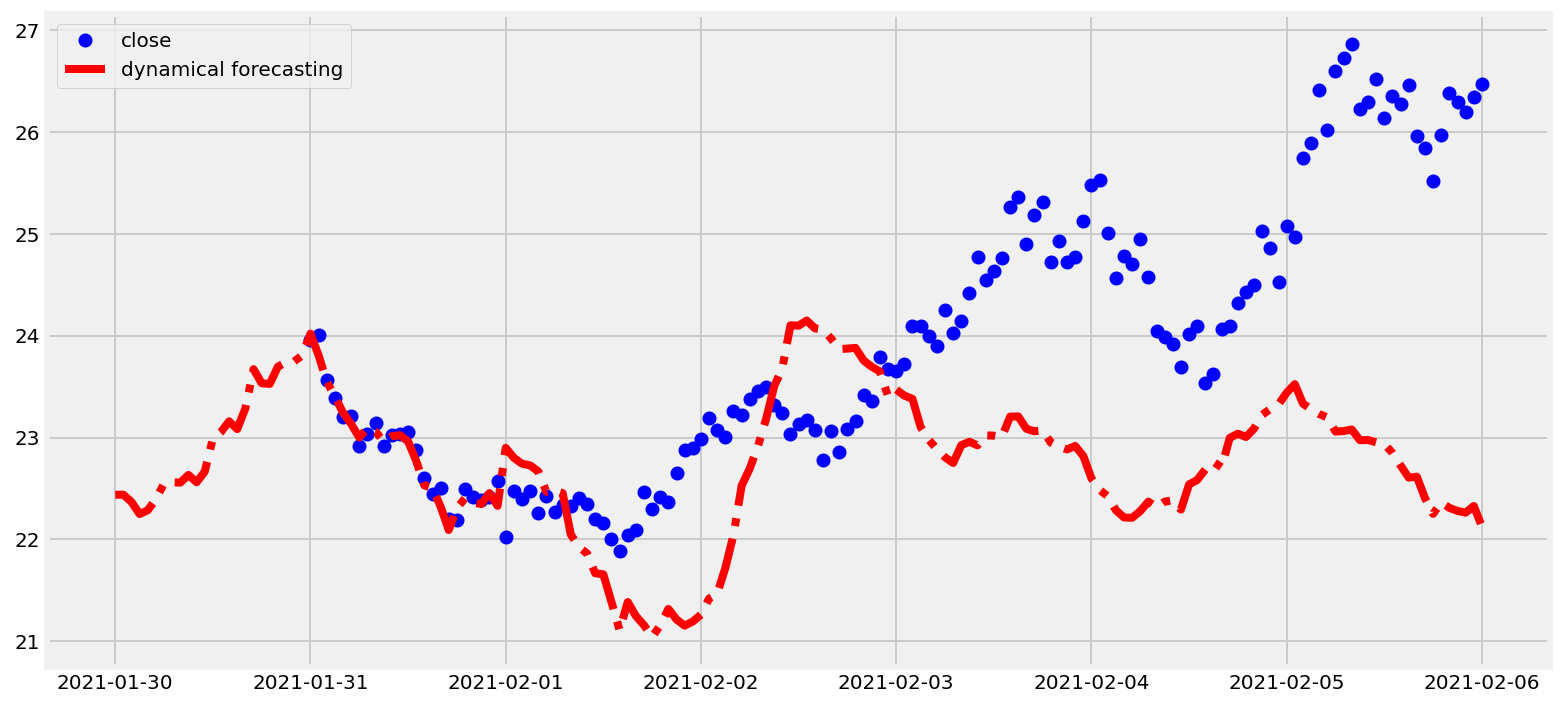

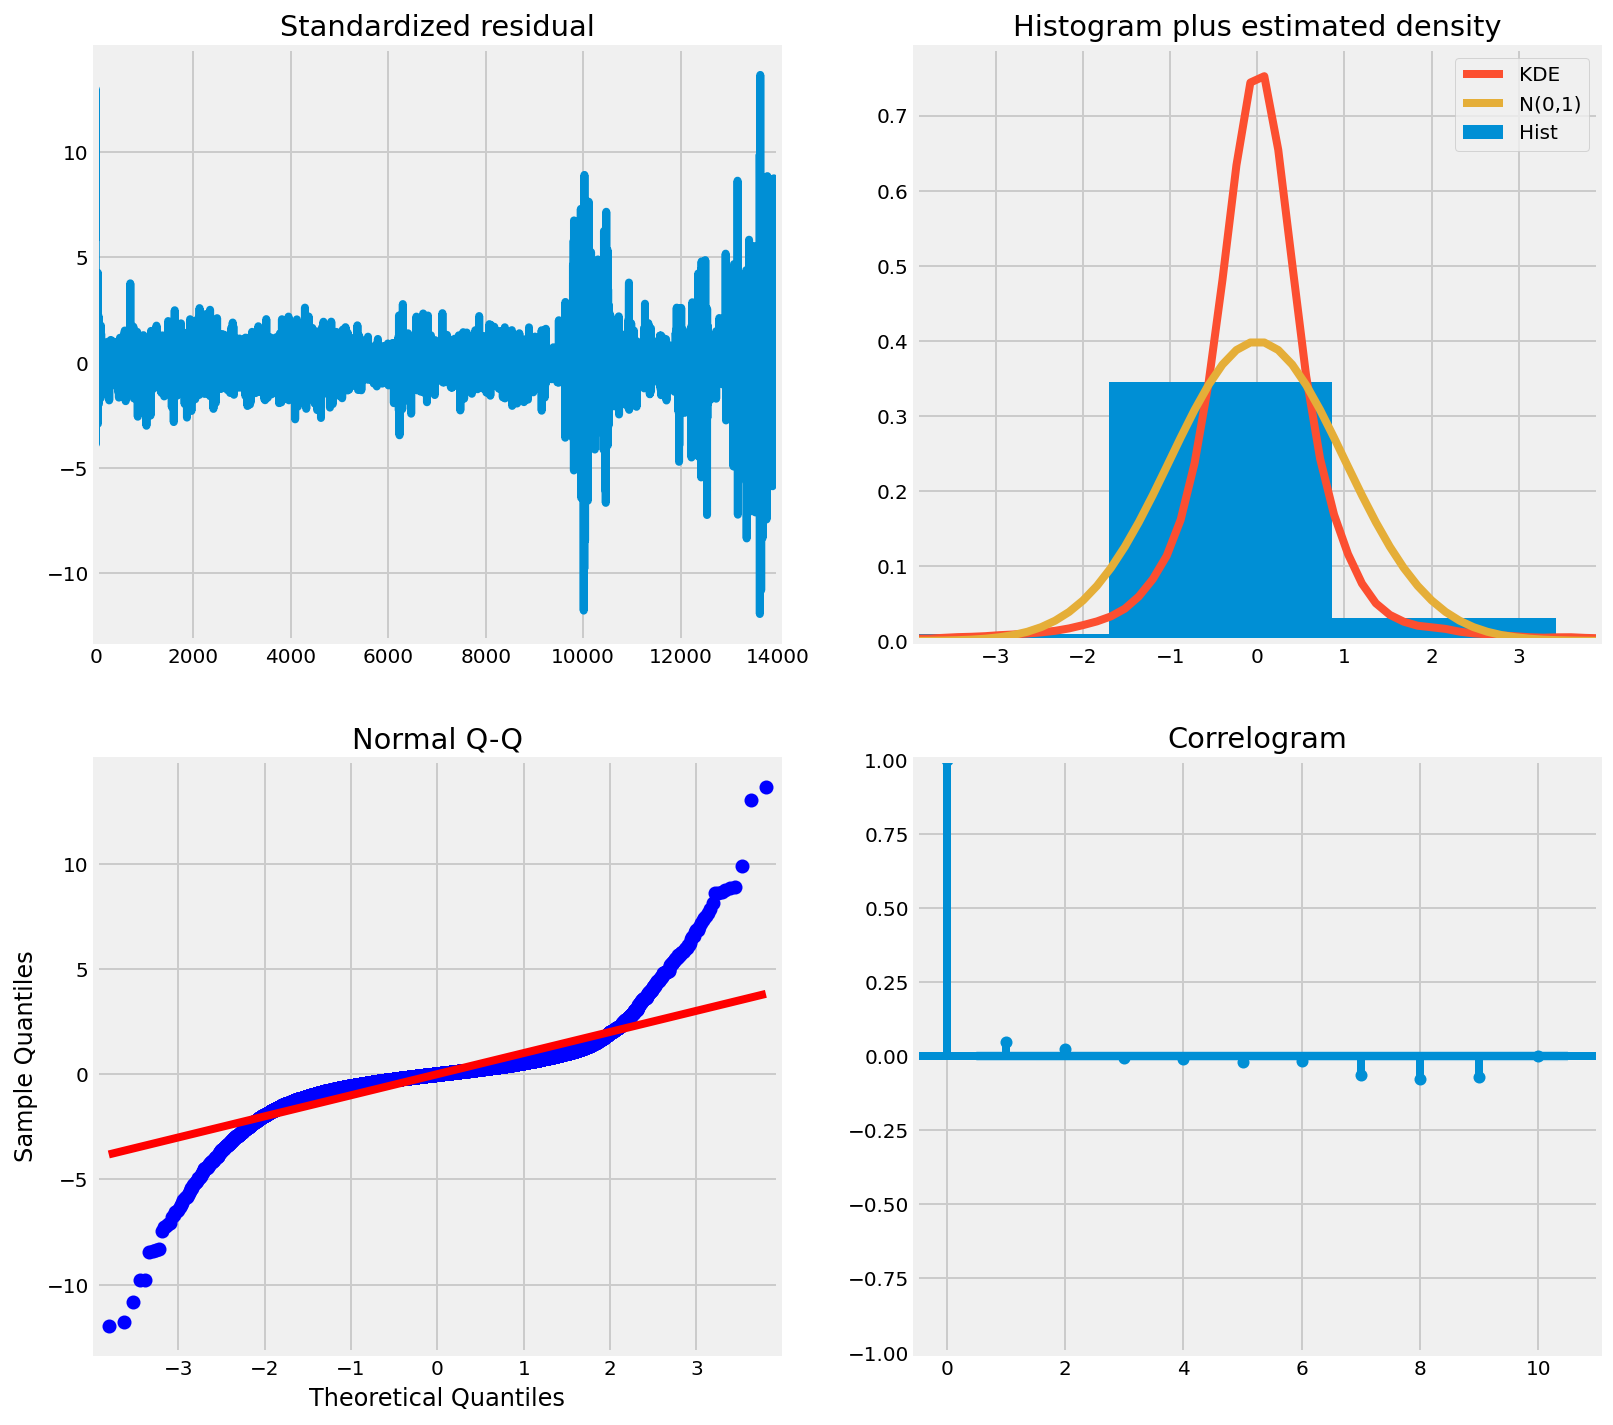

RMSE:  0.0838364554329782


In [137]:
link_arima_momentum = model_4a(link_ta, "LINK-USD", momentum_tis)
link_arima_momentum


# Model Review (fix or remove this)

#### Overview


#### Data Loading & Cleaning

All 6 cryptocurrency datasets, where each observation is an hourly account of their prices, were loaded via separate csvs and were cleaned by placing a chronological datetime index. Then we can begin feature engineering by creating shifted columns for our features/technical indicators by 1 period forward. A binarizer was also used to create our target variable, where 1 indicating the price increasing and 0 for the price decreasing/remaining stationary. After scaling our features with a MinMaxScaler, they were ready for classifier modeling.

#### Technical Indicators

A total of


#### ARIMA Modeling

- BTC:
- ETH:
- LTC:
- XLM:
- DASH:
- LINK:


#### Forecasting

#### Model Metrics and Review (Partial and Full Autocorrelation), AIC, RMSE, 

#### Summary

# Phase 4b: Classifiers on Technical Indicators (NEW NOTEBOOK)
- Creating a binary column on Price going up or down/stays the same
- Run a multitude of classifiers to identify feature importances & best model in predicting price change

# Phase 4c and beyond (post course): 

- Deep Learning Models - LSTM, GARCH, etc. to significantly improve model scores
- Use with continuous live data - smaller interval periods? (More suitable for swing trading as opposed to day trading)
- Trading Bot (simulated data)
- Trading App (will have to explore the developer route)